In [1]:
#!/usr/bin/py
import sklearn
import logging
import os
import warnings
import numpy as np
import tsfel
from collections import namedtuple
from contextlib import contextmanager
from datetime import datetime
from zipfile import ZipFile, is_zipfile
import matplotlib.pyplot as plt
import pandas as pd
import math
import tsfresh.feature_extraction.feature_calculators as feature
from tsfresh.utilities.distribution import MultiprocessingDistributor
import seaborn as sns
from datetime import date

In [2]:
HEADER_LINE_PREFIX = '% '
HEADER_END_LINE_PREFIX = '%-'
HEADER_KEYS = ['date_time', 'prog_version', 'serial', 'mech_unit', 'axis', 'sampling_period', 'tool', 'rob_ax', 'ext_ax']
DATETIME_FORMAT = '%Y%m%d_%H%M%S'

MIN_SAMPLES = 600
SAMPLING_PERIOD = 0.004032
FREQUENCY = 1/SAMPLING_PERIOD

# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain()



In [3]:
MccRun = namedtuple('MccRun', 'mode series')
MccResult = namedtuple('MccResult', 'status value average distance')
OperationMode = namedtuple('OperationMode', ['axis', 'mech_unit', 'tool', 'rob_ax', 'ext_ax', 'prog_version'])

In [4]:
@contextmanager
def open_zip(file):
    if not is_zipfile(file):
        raise TypeError(f'{file} is not a valid zip file')

    zip_archive = ZipFile(file, 'r')
    files = zip_archive.namelist()
    try:
        extracted = [zip_archive.open(f) for f in files]
        yield extracted
    finally:
        for f in extracted:
            f.close()
        zip_archive.close()

In [5]:
def read_header(file):
    header = {}
    for line in file:
        line = line.decode('utf-8')
        if line.startswith(HEADER_LINE_PREFIX):
    
            parameter, value = (element.strip() for element in line.split(':'))
            if 'Meas time' in parameter:
                header['date_time'] = datetime.strptime(value, DATETIME_FORMAT)
            if 'Program version' in parameter:
                header['prog_version'] = value
            elif 'Robot serial number' in parameter:
                header['serial'] = value
            elif 'Mech unit' in parameter:
                header['mech_unit'] = value
            elif 'Axis' in parameter:
                header['axis'] = int(value)
            elif 'Sample time' in parameter:
                header['sampling_period'] = float(value)
            elif 'Tool' in parameter:
                header['tool'] = value
            elif 'RobAx' in parameter:
                header['rob_ax'] = value
            elif 'ExtAx' in parameter:
                header['ext_ax'] = value
            elif 'Meas type' in parameter:
                continue
            else:
                #logging.debug(f'Parameter {parameter} and value {value} not handled')
                continue

        elif line.startswith(HEADER_END_LINE_PREFIX):
            continue

        else:
            break
#     if not header:
#         logging.warning(f'Empty header in {file.name}')
#         return None
    return header

In [6]:
def read_data(file):
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            data = np.loadtxt(file, dtype=np.float64, delimiter='\t')
        except Warning:
            logging.warning(f'{file.name} has no data')
            return None
#         except Exception:
#             logging.error(f'{file.name} is broken')
            return None

    n_samples, n_columns = data.shape

    if n_columns == 3:
        data = _decrypt3(data)
    elif n_columns == 4:
        data = _decrypt3(data[:, 1:]) 
    elif n_columns == 5:
        data = _decrypt4(data[:, 1:])
    else:
        logging.warning(f'Unhandled case with {n_columns} columns in {handle.name}')
        return None
    if n_samples < MIN_SAMPLES:
        logging.warning(f'Case with {n_samples} samples')

    data = data[10:-10]
    return np.asarray(data)
def _decrypt3(data):
    return data * np.matrix([[0.5, 0.5, 0], [-0.5, 0, 0.5], [0, 0.5, -0.5]])


def _decrypt4(data):
    return data * np.matrix([[0.5, 0.5, 0, 0], [-0.5, 0, 0, 0.5], [0, 0, 0.5, -0.5], [0, 0.5, -0.5, 0]])

In [7]:

class MccTimeSeries():
    def __init__(self, series, date_time, sampling_period):
        self.series = series
        self.date_time = date_time
        self.sampling_period = sampling_period
    
    def __getitem__(self, index):
        return self.series[index]

    def __len__(self):
        return len(self.series)

    @property
    def torque_ff(self):
        return self.series[:, 0]

    @property
    def velocity(self):
        return self.series[:, 1]
    
    @property
    def torque(self):
        return self.series[:, 2]

    @property
    def time_index(self):
        return np.arange(0, self.torque.size)[:, np.newaxis] * self.sampling_period

    @property
    def sampling_frequency(self):
        return 1 / self.sampling_period

    def normalized_torque(self):
        return (self.torque - self.torque.min()) / (self.torque.max() - self.torque.min())
    
    def standardized_torque(self):
        return (self.torque - self.torque.mean()) / self.torque.std()
    def mean_torque(self):
        return self.torque.mean()
    
    def find_reference_point(self):
        ref = self.standardized_torque()
        mean_value = self.torque.mean()
        stv = self.torque.std(ddof=0)
        return ref, mean_value, stv
        
    
    

# Get the reference points

# Failure Case 2

In [8]:
axes = ['axis1', 'axis2', 'axis3', 'axis4', 'axis5', 'axis6']

def process_file(file_path):
    ref = {}
    mean = {}
    stv = {}

    with ZipFile(file_path) as File:
        print(File)
        for file in File.namelist():
            with File.open(file) as f:
                header = read_header(f)
                data = read_data(f)
                mode = OperationMode(axis=header['axis'], mech_unit=header['mech_unit'], tool=header['tool'], rob_ax=header['rob_ax'], ext_ax=header['ext_ax'], prog_version=header['prog_version'])
                series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))                
                for ax in axes:
                    if ax in file:
                        ref[ax], mean[ax], stv[ax] = series.find_reference_point()
                        

        return ref, mean, stv



In [9]:
# Use the standard deviation and the mean of reference points
def standardized_torque(data,ref_mean,ref_stv):
    return (data - ref_mean) / ref_stv

In [10]:
# Caculate the corss-correlation of two consecutive measurements
from scipy import signal
def cross_correlation(ref,d):
    Shift = []
    corr = signal.correlate(ref,d)
#Find the index of the maximum of cross-correlation
    indx = np.argmax(corr, axis=0)
#Offset of the two series
    lags = signal.correlation_lags(len(ref), len(d))
    Shift.append(lags[indx])
    offset = lags[indx]
    min_length = min(d.size,ref.size)-abs(offset)
    d_m, ref_m = shift_signal(offset, min_length, d, ref)
    return d_m, ref_m, offset

In [11]:
def shift_signal(offset, min_length, d, ref):    
    if offset > 0:
        d = d[:min_length] ;
        ref = ref[offset:];
    elif offset < 0:
        d = d[-offset:];
        ref = ref[:min_length]
    return d,ref

In [12]:
def trimmedMean(mcc_torque):   
    mcc_torque = mcc_torque[np.abs(mcc_torque) > 1e-4]
    try:
          return mcc_torque.mean()      
    except:
          return null

In [13]:
def torque_fftFeatures_maxamplitude(mcc_torque):   
    amplitudes = np.fft.fft(mcc_torque)
    realAmplitudes = abs(amplitudes)  # real valued amplitudes
    maxAmplitude = np.max(realAmplitudes)
    return maxAmplitude

In [14]:
def torque_fftFeatures_entropy(mcc_torque):
      try:  
            amplitudes = np.fft.fft(mcc_torque)
            realAmplitudes = abs(amplitudes)  # real valued amplitudes
            N = mcc_torque.shape[0]
            entropy = 0
            for i in realAmplitudes:
                  try:
                        entropy += i * log(i)
                  except:
                        entropy += 0
            entropy = -entropy / np.float(log(N))
            return entropy
      except:
            return 0           


In [15]:
def area_signal(d, ref, ref_mean, dx):
    abs(np.trapz(abs(d), axis = ref_mean, dx=dx) - np.trapz(abs(ref), axis = ref_mean, dx=dx))

In [16]:
def generate_more_feature(Filepath,ref,mean,stv):    
    File_path = Filepath
    ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
    columns=['axis1','axis2','axis3','axis4','axis5','axis6']
    RMS_Value=pd.DataFrame(columns=columns)
    Skewness_value = pd.DataFrame(columns=columns)
    Kurtosis_value = pd.DataFrame(columns=columns)
    
    Energy = pd.DataFrame(columns=columns)
    Stv = pd.DataFrame(columns=columns)
    Variance = pd.DataFrame(columns=columns)
    Impulse_factor = pd.DataFrame(columns=columns)
    Shape_factor = pd.DataFrame(columns=columns)
    MAX_AMP = pd.DataFrame(columns=columns)
    torque_areaUnderSignal = pd.DataFrame(columns=columns)
    torque_trimmedMean = pd.DataFrame(columns=columns)
    torque_signalNoise = pd.DataFrame(columns=columns)
    MAX_AMP = pd.DataFrame(columns=columns)
    fig, (x1, x2, xf1) = plt.subplots(3)
    fig, (x3, x4, xf2) = plt.subplots(3)
    fig, (x5, x6, xf3) = plt.subplots(3)
    fig, (x7, x8, xf4) = plt.subplots(3)
    fig, (x9, x10, xf5) = plt.subplots(3)
    fig, (x11, x12, xf6) = plt.subplots(3)
    
    i = 0
    for loop_file in os.listdir(File_path):
        route = os.path.join(File_path,loop_file)

        with ZipFile(route) as File:
            for file in File.namelist():
                with File.open(file) as f:
                    header = read_header(f)
                    #Set the index
                    date = header['date_time']
    #                 i = date.date()
                    #Read data
                    data = read_data(f)
                    mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
                    series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
                    index = series.time_index
                    if ax1 in file:
                    # Extract features for axis1
                        d1 = standardized_torque(series.torque,mean[ax1], stv[ax1])
                        s1 = series.velocity
                        xf1.plot(s1)
                        
                        #ff_d1 = series.torque_ff
                        #xf1.plot(ff_d1)
                        xf1.set_xlabel('Timestamp')  
                        xf1.set_ylabel('Speed axis1')
                        d_m1, ref_m1,offset1 = cross_correlation(ref[ax1], d1) 
                        corr_1 = np.corrcoef(d_m1, ref_m1)
                        
                        if abs(offset1) > 10 or corr_1[0,1] <0.9:
                            continue
                        else:
                            torque_areaUnderSignal.loc[i, 'time'] = date.date()
                            torque_areaUnderSignal.loc[i, 'axis1'] = abs(np.trapz(abs(d_m1), dx = index[1] - index[0]) - np.trapz(abs(ref_m1), dx = index[1] - index[0]))
                            
                            torque_trimmedMean.loc[i, 'time'] = date.date()
                            torque_trimmedMean.loc[i, 'axis1'] = abs(trimmedMean(d_m1)- trimmedMean(ref_m1))

                            torque_signalNoise.loc[i, 'time'] = date.date()
                            torque_signalNoise.loc[i, 'axis1'] = abs((d_m1-ref_m1).mean()/(d_m1-ref_m1).std(ddof=0))
                            
                            RMS_Value.loc[i, 'time'] = date.date()
                            RMS_Value.loc[i, 'axis1'] = feature.root_mean_square(d_m1-ref_m1)

                            Skewness_value.loc[i, 'time'] = date.date()
                            Skewness_value.loc[i, 'axis1'] = feature.skewness(d_m1-ref_m1)

                            Kurtosis_value.loc[i, 'time'] = date.date()
                            Kurtosis_value.loc[i, 'axis1'] = feature.kurtosis(d_m1-ref_m1)

                            Energy.loc[i, 'time'] = date.date()
                            Energy.loc[i, 'axis1'] = feature.abs_energy(d_m1-ref_m1)

                            Stv.loc[i, 'time'] = date.date()
                            Stv.loc[i, 'axis1'] = (d_m1-ref_m1).std(ddof=0)

                            Variance.loc[i, 'time'] = date.date()
                            Variance.loc[i, 'axis1'] = (d_m1-ref_m1).var()

                            Impulse_factor.loc[i, 'time'] = date.date()
                            Impulse_factor.loc[i, 'axis1'] = max(d_m1-ref_m1)/abs(feature.mean(d_m1-ref_m1))

                            Shape_factor.loc[i, 'time'] = date.date()
                            Shape_factor.loc[i, 'axis1'] = feature.root_mean_square(d_m1-ref_m1)/abs(feature.mean(d_m1-ref_m1))
                            
                            MAX_AMP.loc[i, 'time'] = date.date()
                            MAX_AMP.loc[i, 'axis1'] = torque_fftFeatures_maxamplitude(d_m1-ref_m1)
                            
                            

                            x1.plot(d1)
                            x2.plot(d_m1)
                            x1.set_xlabel('Timestamp')  
                            x1.set_ylabel('Torque axis1')
                            x2.set_xlabel('Timestamp')  
                            x2.set_ylabel('Torque axis1')


                    elif ax2 in file:
                    # Extract features for axis2
                        ff_d2 = series.torque_ff
                        xf2.plot(ff_d2)
                        xf2.set_xlabel('Timestamp')  
                        xf2.set_ylabel('FF Torque axis2')

                        d2 = standardized_torque(series.torque,mean[ax2], stv[ax2])
                        d_m2, ref_m2, offset2 = cross_correlation(ref[ax2], d2)
                        corr_2 = np.corrcoef(d_m2, ref_m2)
                        if abs(offset2) > 10 or corr_2[0,1] <0.9:
                            continue
                        else:
                            x3.plot(d2)
                            x4.plot(d_m2)
                            x3.set_xlabel('Timestamp')  
                            x3.set_ylabel('Torque axis2')
                            x4.set_xlabel('Timestamp')  
                            x4.set_ylabel('Torque axis2')
                            torque_areaUnderSignal.loc[i, 'axis2'] = abs(np.trapz(abs(d_m2), dx = index[1] - index[0]) - np.trapz(abs(ref_m2), dx = index[1] - index[0]))
                            torque_trimmedMean.loc[i, 'axis2'] = abs(trimmedMean(d_m2)- trimmedMean(ref_m2))
                            torque_signalNoise.loc[i, 'axis2'] = abs((d_m2-ref_m2).mean()/(d_m2-ref_m2).std(ddof=0))
                            RMS_Value.loc[i, 'axis2'] = feature.root_mean_square(d_m2-ref_m2)
                            Skewness_value.loc[i, 'axis2'] = feature.skewness(d_m2-ref_m2)
                            Kurtosis_value.loc[i, 'axis2'] = feature.kurtosis(d_m2-ref_m2)
                            Energy.loc[i, 'axis2'] = feature.abs_energy(d_m2-ref_m2)
                            Stv.loc[i, 'axis2'] = (d_m2-ref_m2).std(ddof=0)
                            Variance.loc[i, 'axis2'] = (d_m2-ref_m2).var()
                            Impulse_factor.loc[i, 'axis2'] = max(d_m2-ref_m2)/abs(feature.mean(d_m2-ref_m2))
                            Shape_factor.loc[i, 'axis2'] = feature.root_mean_square(d_m2-ref_m2)/abs(feature.mean(d_m2-ref_m2))
                            MAX_AMP.loc[i, 'axis2'] = torque_fftFeatures_maxamplitude(d_m2-ref_m2)                        
                            
                            
                            
                    elif ax3 in file:
                    # Extract features for axis3
                        ff_d3 = series.torque_ff
                        xf3.plot(ff_d3)
                        xf3.set_xlabel('Timestamp')  
                        xf3.set_ylabel('FF Torque axis3')
                        d3 = standardized_torque(series.torque,mean[ax3], stv[ax3])
                        d_m3, ref_m3,offset3 = cross_correlation(ref[ax3], d3)
                        corr_3 = np.corrcoef(d_m3, ref_m3)
                        
                        if abs(offset3) > 10 or corr_3[0,1] <0.9:
                            continue
                        else:
                            
                            x5.plot(d3)
                            x6.plot(d_m3)
                            x5.set_xlabel('Timestamp')  
                            x5.set_ylabel('Torque axis3')
                            x6.set_xlabel('Timestamp')  
                            x6.set_ylabel('Torque axis3')
                            torque_areaUnderSignal.loc[i, 'axis3'] = abs(np.trapz(abs(d_m3), dx = index[1] - index[0]) - np.trapz(abs(ref_m3), dx = index[1] - index[0]))
                            torque_trimmedMean.loc[i, 'axis3'] = abs(trimmedMean(d_m3)- trimmedMean(ref_m3))
                            torque_signalNoise.loc[i, 'axis3'] = abs((d_m3-ref_m3).mean()/(d_m3-ref_m3).std(ddof=0))
                            RMS_Value.loc[i, 'axis3'] = feature.root_mean_square(d_m3-ref_m3)
                            Skewness_value.loc[i, 'axis3'] = feature.skewness(d_m3-ref_m3)
                            Kurtosis_value.loc[i, 'axis3'] = feature.kurtosis(d_m3-ref_m3)
                            Stv.loc[i, 'axis3'] = (d_m3-ref_m3).std(ddof=0)
                            Variance.loc[i, 'axis3'] = (d_m3-ref_m3).var()
                            Energy.loc[i, 'axis3'] = feature.abs_energy(d_m3-ref_m3)
                            Impulse_factor.loc[i, 'axis3'] = max(d_m3-ref_m3)/abs(feature.mean(d_m3-ref_m3))
                            Shape_factor.loc[i, 'axis3'] = feature.root_mean_square(d_m3-ref_m3)/abs(feature.mean(d_m3-ref_m3))
                            MAX_AMP.loc[i, 'axis3'] = torque_fftFeatures_maxamplitude(d_m3-ref_m3)                        
                        
                    elif ax4 in file:
                    # Extract features for axis4
                        ff_d4 = series.torque_ff
                        xf4.plot(ff_d4)
                        xf4.set_xlabel('Timestamp')  
                        xf4.set_ylabel('FF Torque axis4')
                        d4 = standardized_torque(series.torque,mean[ax4], stv[ax4])
                        d_m4, ref_m4, offset4 = cross_correlation(ref[ax4], d4)
                        corr_4 = np.corrcoef(d_m4, ref_m4)
                        if abs(offset4) > 10 or corr_4[0,1] < 0.9:
                            continue
                        else:
                            x7.plot(d4)

                            x8.plot(d_m4)
                            x7.set_xlabel('Timestamp')  
                            x7.set_ylabel('Torque axis4')
                            x8.set_xlabel('Timestamp')  
                            x8.set_ylabel('Torque axis4')
                            torque_areaUnderSignal.loc[i, 'axis4'] = abs(np.trapz(abs(d_m4), dx = index[1] - index[0]) - np.trapz(abs(ref_m4), dx = index[1] - index[0]))
                            torque_trimmedMean.loc[i, 'axis4'] = abs(trimmedMean(d_m4)- trimmedMean(ref_m4))
                            torque_signalNoise.loc[i, 'axis4'] = abs((d_m4-ref_m4).mean()/(d_m4-ref_m4).std(ddof=0))
                            RMS_Value.loc[i, 'axis4'] = feature.root_mean_square(d_m4-ref_m4)
                            Skewness_value.loc[i, 'axis4'] = feature.skewness(d_m4-ref_m4)
                            Kurtosis_value.loc[i, 'axis4'] = feature.kurtosis(d_m4-ref_m4)
                            Energy.loc[i, 'axis4'] = feature.abs_energy(d_m4-ref_m4)
                            Stv.loc[i, 'axis4'] = (d_m4-ref_m4).std(ddof=0)
                            Variance.loc[i, 'axis4'] = (d_m4-ref_m4).var()
                            Impulse_factor.loc[i, 'axis4'] = max(d_m4-ref_m4)/abs(feature.mean(d_m4-ref_m4))
                            Shape_factor.loc[i, 'axis4'] = feature.root_mean_square(d_m4-ref_m4)/abs(feature.mean(d_m4-ref_m4))
                            MAX_AMP.loc[i, 'axis4'] = torque_fftFeatures_maxamplitude(d_m4-ref_m4) 
                            
                    elif ax5 in file:
                    # Extract features for axis5
                        ff_d5 = series.torque_ff
                        xf5.plot(ff_d5)
                        xf5.set_xlabel('Timestamp')  
                        xf5.set_ylabel('FF Torque axis5')
                        d5 = standardized_torque(series.torque,mean[ax5], stv[ax5])
                        d_m5, ref_m5,offset5 = cross_correlation(ref[ax5], d5)
                        corr_5 = np.corrcoef(d_m5, ref_m5)
                        if abs(offset5) > 10 or corr_5[0,1] <0.9:
                            continue
                        else:
                            x9.plot(d5)
                            x10.plot(d_m5)
                            x9.set_xlabel('Timestamp')  
                            x9.set_ylabel('Torque axis5')
                            x10.set_xlabel('Timestamp')  
                            x10.set_ylabel('Torque axis5')
                            torque_areaUnderSignal.loc[i, 'axis5'] = abs(np.trapz(abs(d_m5), dx = index[1] - index[0]) - np.trapz(abs(ref_m5), dx = index[1] - index[0]))
                            torque_trimmedMean.loc[i, 'axis5'] = abs(trimmedMean(d_m5)- trimmedMean(ref_m5))
                            torque_signalNoise.loc[i, 'axis5'] = abs((d_m5-ref_m5).mean()/(d_m5-ref_m5).std(ddof=0))
                            RMS_Value.loc[i, 'axis5'] = feature.root_mean_square(d_m5-ref_m5)
                            Skewness_value.loc[i, 'axis5'] = feature.skewness(d_m5-ref_m5)
                            Kurtosis_value.loc[i, 'axis5'] = feature.kurtosis(d_m5-ref_m5)
                            Energy.loc[i, 'axis5'] = feature.abs_energy(d_m5-ref_m5)
                            Stv.loc[i, 'axis5'] = (d_m5-ref_m5).std(ddof=0)
                            Variance.loc[i, 'axis5'] = (d_m5-ref_m5).var()
                            Impulse_factor.loc[i, 'axis5'] = max(d_m5-ref_m5)/abs(feature.mean(d_m5-ref_m5))
                            Shape_factor.loc[i, 'axis5'] = feature.root_mean_square(d_m5-ref_m5)/abs(feature.mean(d_m5-ref_m5))
                            MAX_AMP.loc[i, 'axis5'] = torque_fftFeatures_maxamplitude(d_m5-ref_m5)         
                            
                    elif ax6 in file:
                    # Extract features for axis6
                        ff_d6 = series.torque_ff
                        xf6.plot(ff_d6)
                        xf6.set_xlabel('Timestamp')  
                        xf6.set_ylabel('FF Torque axis6')
                        d6 = standardized_torque(series.torque,mean[ax6], stv[ax6])
                        d_m6, ref_m6,offset6 = cross_correlation(ref[ax6], d6)
                        corr_6 = np.corrcoef(d_m6, ref_m6)
                        
                        if abs(offset6) > 10 or corr_6[0,1] <0.9:
                            continue
                        else:
                            
                            x11.plot(d6)
                            x12.plot(d_m6)
                            x11.set_xlabel('Timestamp')  
                            x11.set_ylabel('Torque axis6')
                            x12.set_xlabel('Timestamp')  
                            x12.set_ylabel('Torque axis6')
                            torque_areaUnderSignal.loc[i, 'axis6'] = abs(np.trapz(abs(d_m6), dx = index[1] - index[0]) - np.trapz(abs(ref_m6), dx = index[1] - index[0])) 
                            torque_trimmedMean.loc[i, 'axis6'] = abs(trimmedMean(d_m6)- trimmedMean(ref_m6))
                            torque_signalNoise.loc[i, 'axis6'] = abs((d_m6-ref_m6).mean()/(d_m6-ref_m6).std(ddof=0))
                            RMS_Value.loc[i, 'axis6'] = feature.root_mean_square(d_m6-ref_m6)
                            Skewness_value.loc[i, 'axis6'] = feature.skewness(d_m6-ref_m6)
                            Kurtosis_value.loc[i, 'axis6'] = feature.kurtosis(d_m6-ref_m6)
                            Energy.loc[i, 'axis6'] = feature.abs_energy(d_m6-ref_m6)
                            Stv.loc[i, 'axis6'] = (d_m6-ref_m6).std(ddof=0)
                            Variance.loc[i, 'axis6'] = (d_m6-ref_m6).var()
                            Impulse_factor.loc[i, 'axis6'] = max(d_m6-ref_m6)/feature.mean(d_m6-ref_m6)
                            Shape_factor.loc[i, 'axis6'] = feature.root_mean_square(d_m6-ref_m6)/abs(feature.mean(d_m6-ref_m6))
                            MAX_AMP.loc[i, 'axis6'] = torque_fftFeatures_maxamplitude(d_m6-ref_m6)                        
                            
        i = i + 1
    return RMS_Value,Stv,Impulse_factor,Shape_factor,torque_areaUnderSignal, torque_trimmedMean, torque_signalNoise, MAX_AMP
               

<zipfile.ZipFile filename='C:/Users/semihua/Desktop/Mingjie/test data/FC2_7142240_66-51134/1343-0024-56_DIAGDATA_20140822_185018__MCC.zip' mode='r'>


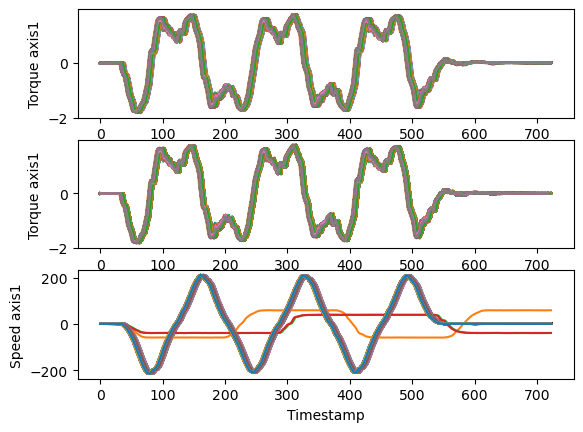

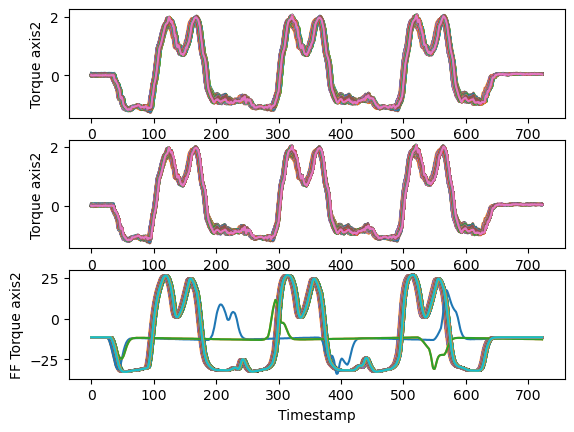

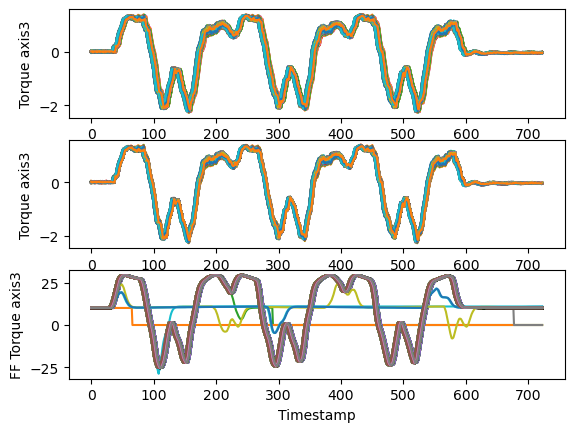

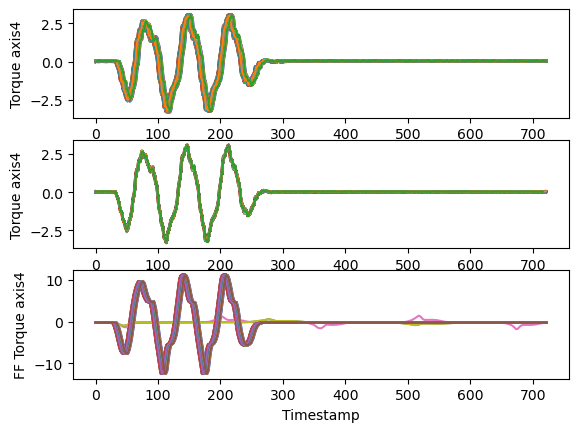

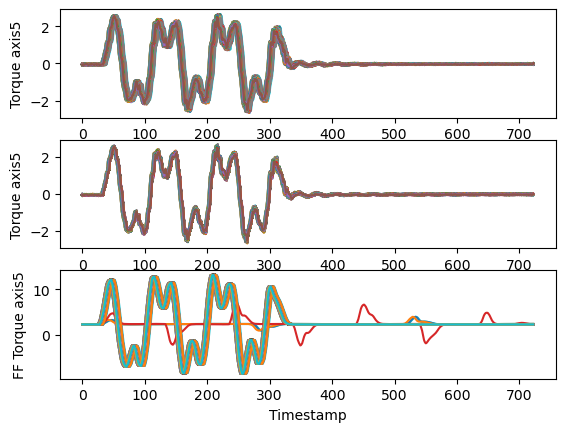

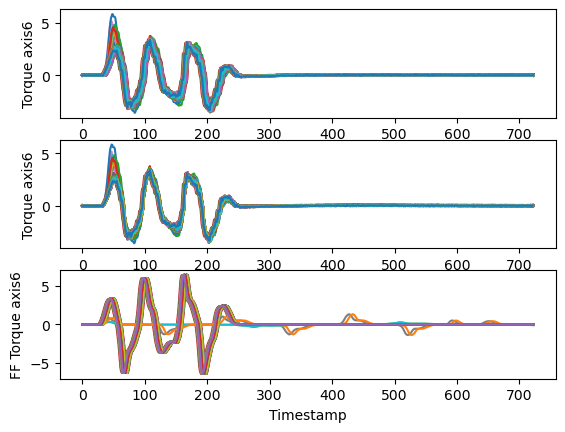

In [17]:
#Failure Case 2
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC2_7142240_66-51134/1343-0024-56_DIAGDATA_20140822_185018__MCC.zip'
ref_FC2, mean_FC2, stv_FC2 = process_file(file_path)

File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC2_7142240_66-51134/MCCFiles'
RMS_Value_FC2,Stv_FC2,Impulse_factor_FC2,Shape_factor_FC2,torque_areaUnderSignal_FC2, torque_trimmedMean_FC2,torque_signalNoise_FC2, MAX_AMP_FC2 = generate_more_feature(File_path,ref_FC2, mean_FC2, stv_FC2)



In [18]:
RMS_Value_FC2 = RMS_Value_FC2.dropna(axis=0,how='any')
Stv_FC2 = Stv_FC2.dropna(axis=0,how='any')
torque_areaUnderSignal_FC2 = torque_areaUnderSignal_FC2.dropna(axis=0,how='any')
torque_trimmedMean_FC2 = torque_trimmedMean_FC2.dropna(axis=0,how='any')
torque_signalNoise_FC2 = torque_signalNoise_FC2.dropna(axis=0,how='any')
MAX_AMP_FC2 = MAX_AMP_FC2.dropna(axis=0,how='any')


In [19]:
RMS_Value_FC2 = RMS_Value_FC2.groupby(by='time').mean()
Stv_FC2 = Stv_FC2.groupby(by='time').mean()
torque_areaUnderSignal_FC2 = torque_areaUnderSignal_FC2.groupby(by='time').mean()
torque_trimmedMean_FC2 = torque_trimmedMean_FC2.groupby(by='time').mean()
torque_signalNoise_FC2 = torque_signalNoise_FC2.groupby(by='time').mean()
MAX_AMP_FC2 = MAX_AMP_FC2.groupby(by='time').mean()

<zipfile.ZipFile filename='C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139/04-64139_DIAGDATA_20170918_135452_3ece932f-a030-4c95-bd2c-e6d899ed8871_MCC.zip' mode='r'>


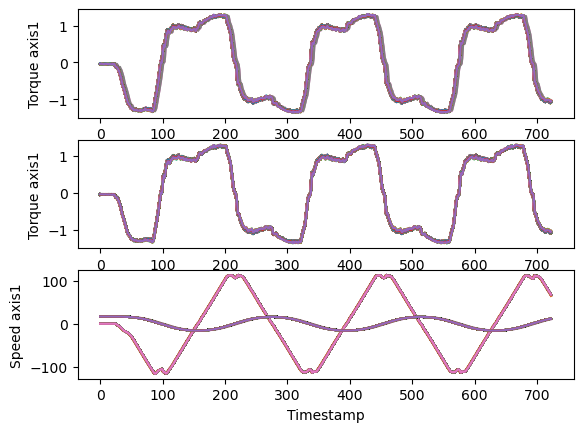

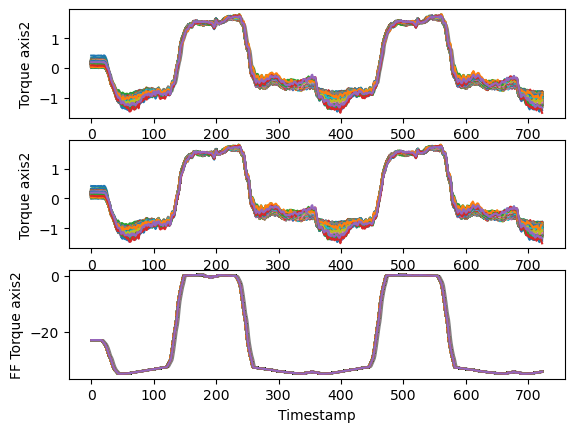

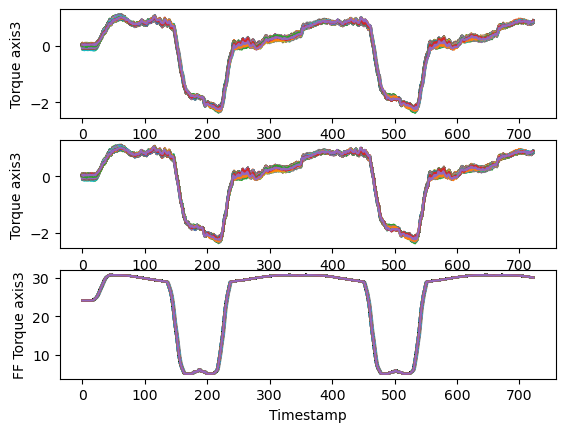

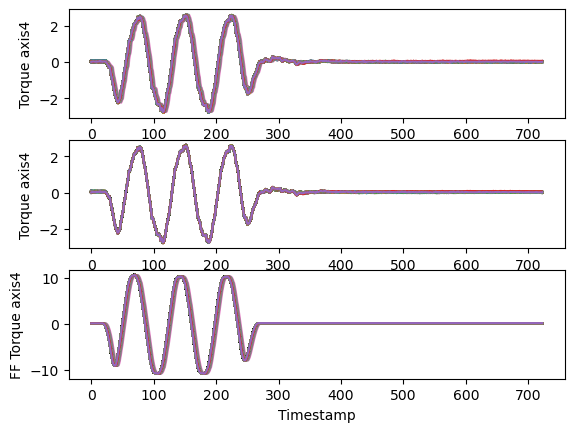

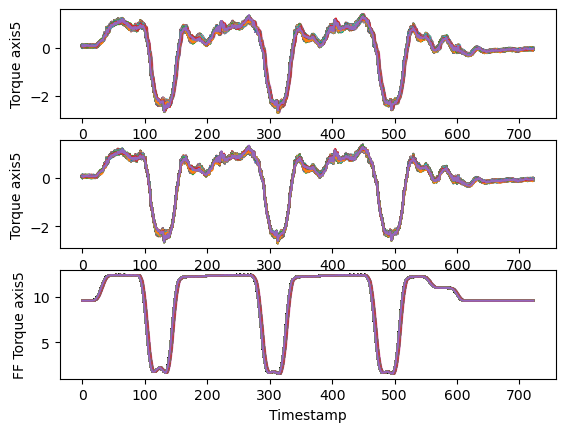

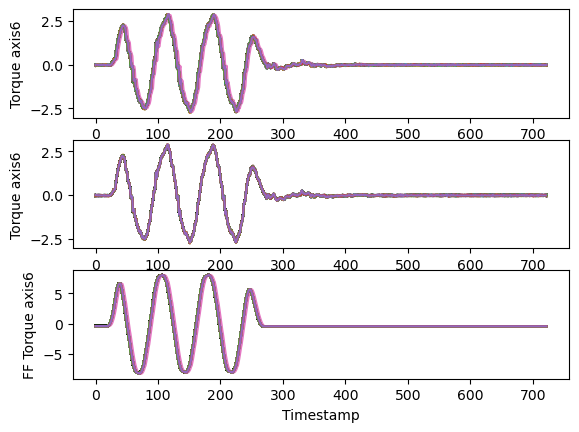

In [20]:
#Failure Case 10
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139/04-64139_DIAGDATA_20170918_135452_3ece932f-a030-4c95-bd2c-e6d899ed8871_MCC.zip'
ref_FC10, mean_FC10, stv_FC10 = process_file(file_path)
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139/MCC Flies'
RMS_Value_FC10,Stv_FC10,Impulse_factor_FC10,Shape_factor_FC10, torque_areaUnderSignal_FC10, torque_trimmedMean_FC10,torque_signalNoise_FC10, MAX_AMP_FC10  = generate_more_feature(File_path,ref_FC10, mean_FC10, stv_FC10)

In [21]:
RMS_Value_FC10 = RMS_Value_FC10.dropna(axis=0,how='any')
Stv_FC10 = Stv_FC10.dropna(axis=0,how='any')
torque_areaUnderSignal_FC10 = torque_areaUnderSignal_FC10.dropna(axis=0,how='any')
torque_trimmedMean_FC10 = torque_trimmedMean_FC10.dropna(axis=0,how='any')
torque_signalNoise_FC10 = torque_signalNoise_FC10.dropna(axis=0,how='any')
MAX_AMP_FC10 = MAX_AMP_FC10.dropna(axis=0,how='any')


In [22]:
RMS_Value_FC10 = RMS_Value_FC10.groupby(by='time').mean()
Stv_FC10 = Stv_FC10.groupby(by='time').mean()
torque_areaUnderSignal_FC10 = torque_areaUnderSignal_FC10.groupby(by='time').mean()
torque_trimmedMean_FC10 = torque_trimmedMean_FC10.groupby(by='time').mean()
torque_signalNoise_FC10 = torque_signalNoise_FC10.groupby(by='time').mean()
MAX_AMP_FC10 = MAX_AMP_FC10.groupby(by='time').mean()

In [23]:
def generate_feature_refresh_reference(Filepath,ref,mean,stv, refresh_date):    
    File_path = Filepath
    ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
    columns=['axis1','axis2','axis3','axis4','axis5','axis6']
    RMS_Value=pd.DataFrame(columns=columns)
    Skewness_value = pd.DataFrame(columns=columns)
    Kurtosis_value = pd.DataFrame(columns=columns)
    
    Energy = pd.DataFrame(columns=columns)
    Stv = pd.DataFrame(columns=columns)
    Variance = pd.DataFrame(columns=columns)
    Impulse_factor = pd.DataFrame(columns=columns)
    Shape_factor = pd.DataFrame(columns=columns)
    MAX_AMP = pd.DataFrame(columns=columns)
    torque_areaUnderSignal = pd.DataFrame(columns=columns)
    torque_trimmedMean = pd.DataFrame(columns=columns)
    torque_signalNoise = pd.DataFrame(columns=columns)
    MAX_AMP = pd.DataFrame(columns=columns)
    NTEST = 0
    OFFSET2 = []
    CORR2 = []
    fig, x1 = plt.subplots()
    i = 0
    for loop_file in os.listdir(File_path):
        route = os.path.join(File_path,loop_file)

        with ZipFile(route) as File:
            for file in File.namelist():
                with File.open(file) as f:
                    header = read_header(f)
                    #Set the index
                    date = header['date_time']
                    DATE = date.date()
                    #Read data
                    data = read_data(f)
                    mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
                    series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
                    index = series.time_index
                    if DATE == refresh_date:
                        ref, mean, stv = process_file(route)
                        NTEST = i
                        break


                    else:
                        if ax1 in file:
                        # Extract features for axis1
                            d1 = standardized_torque(series.torque,mean[ax1], stv[ax1])
                            d_m1, ref_m1,offset1 = cross_correlation(ref[ax1], d1) 
#                             OFFSET1.append(offset1)
                            corr_1 = np.corrcoef(d_m1, ref_m1)

                            if abs(offset1) > 10 or corr_1[0,1] <0.99:
                                continue
                            else:
                                torque_areaUnderSignal.loc[i, 'time'] = date.date()
                                torque_areaUnderSignal.loc[i, 'axis1'] = abs(np.trapz(abs(d_m1), dx = index[1] - index[0]) - np.trapz(abs(ref_m1), dx = index[1] - index[0]))

                                torque_trimmedMean.loc[i, 'time'] = date.date()
                                torque_trimmedMean.loc[i, 'axis1'] = abs(trimmedMean(d_m1)- trimmedMean(ref_m1))

                                torque_signalNoise.loc[i, 'time'] = date.date()
                                torque_signalNoise.loc[i, 'axis1'] = abs((d_m1-ref_m1).mean()/(d_m1-ref_m1).std(ddof=0))

                                RMS_Value.loc[i, 'time'] = date.date()
                                RMS_Value.loc[i, 'axis1'] = feature.root_mean_square(d_m1-ref_m1)

                                Skewness_value.loc[i, 'time'] = date.date()
                                Skewness_value.loc[i, 'axis1'] = feature.skewness(d_m1-ref_m1)

                                Kurtosis_value.loc[i, 'time'] = date.date()
                                Kurtosis_value.loc[i, 'axis1'] = feature.kurtosis(d_m1-ref_m1)

                                Energy.loc[i, 'time'] = date.date()
                                Energy.loc[i, 'axis1'] = feature.abs_energy(d_m1-ref_m1)

                                Stv.loc[i, 'time'] = date.date()
                                Stv.loc[i, 'axis1'] = (d_m1-ref_m1).std(ddof=0)

                                Variance.loc[i, 'time'] = date.date()
                                Variance.loc[i, 'axis1'] = (d_m1-ref_m1).var()

                                Impulse_factor.loc[i, 'time'] = date.date()
                                Impulse_factor.loc[i, 'axis1'] = max(d_m1-ref_m1)/abs(feature.mean(d_m1-ref_m1))

                                Shape_factor.loc[i, 'time'] = date.date()
                                Shape_factor.loc[i, 'axis1'] = feature.root_mean_square(d_m1-ref_m1)/abs(feature.mean(d_m1-ref_m1))

                                MAX_AMP.loc[i, 'time'] = date.date()
                                MAX_AMP.loc[i, 'axis1'] = torque_fftFeatures_maxamplitude(d_m1-ref_m1)


                        elif ax2 in file:
                        # Extract features for axis2

                            d2 = standardized_torque(series.torque,mean[ax2], stv[ax2])
                            d_m2, ref_m2, offset2 = cross_correlation(ref[ax2], d2)
                            OFFSET2.append(offset2)
                            corr_2 = np.corrcoef(d_m2, ref_m2)
                            
                            if abs(offset2) > 10 or corr_2[0,1] <0.99:
                                continue
                            else:
    
                                torque_areaUnderSignal.loc[i, 'axis2'] = abs(np.trapz(abs(d_m2), axis = -1, dx = index[1] - index[0]) - np.trapz(abs(ref_m2), axis = -1, dx = index[1] - index[0]))
                                torque_trimmedMean.loc[i, 'axis2'] = abs(trimmedMean(d_m2)- trimmedMean(ref_m2))
                                torque_signalNoise.loc[i, 'axis2'] = abs((d_m2-ref_m2).mean()/(d_m2-ref_m2).std(ddof=0))
                                RMS_Value.loc[i, 'axis2'] = feature.root_mean_square(d_m2-ref_m2)
                                Skewness_value.loc[i, 'axis2'] = feature.skewness(d_m2-ref_m2)
                                Kurtosis_value.loc[i, 'axis2'] = feature.kurtosis(d_m2-ref_m2)
                                Energy.loc[i, 'axis2'] = feature.abs_energy(d_m2-ref_m2)
                                Stv.loc[i, 'axis2'] = (d_m2-ref_m2).std(ddof=0)
                                Variance.loc[i, 'axis2'] = (d_m2-ref_m2).var()
                                Impulse_factor.loc[i, 'axis2'] = max(d_m2-ref_m2)/abs(feature.mean(d_m2-ref_m2))
                                Shape_factor.loc[i, 'axis2'] = feature.root_mean_square(d_m2-ref_m2)/abs(feature.mean(d_m2-ref_m2))
                                MAX_AMP.loc[i, 'axis2'] = torque_fftFeatures_maxamplitude(d_m2-ref_m2)
                                if i >200 and i < 210:
                                    x1.plot(ref_m2, 'b')
                                    x1.plot(d_m2, 'g')
                                    x1.set_xlabel('Timestamp')  
                                    x1.set_ylabel('Torque axis4')
                                


                        elif ax3 in file:
                        # Extract features for axis3
                            d3 = standardized_torque(series.torque,mean[ax3], stv[ax3])
                            d_m3, ref_m3,offset3 = cross_correlation(ref[ax3], d3)
                            corr_3 = np.corrcoef(d_m3, ref_m3)

                            if abs(offset3) > 10 or corr_3[0,1] <0.99:
                                continue
                            else:
                                torque_areaUnderSignal.loc[i, 'axis3'] = abs(np.trapz(abs(d_m3), dx = index[1] - index[0]) - np.trapz(abs(ref_m3), dx = index[1] - index[0]))
                                torque_trimmedMean.loc[i, 'axis3'] = abs(trimmedMean(d_m3)- trimmedMean(ref_m3))
                                torque_signalNoise.loc[i, 'axis3'] = abs((d_m3-ref_m3).mean()/(d_m3-ref_m3).std(ddof=0))
                                RMS_Value.loc[i, 'axis3'] = feature.root_mean_square(d_m3-ref_m3)
                                Skewness_value.loc[i, 'axis3'] = feature.skewness(d_m3-ref_m3)
                                Kurtosis_value.loc[i, 'axis3'] = feature.kurtosis(d_m3-ref_m3)
                                Stv.loc[i, 'axis3'] = (d_m3-ref_m3).std(ddof=0)
                                Variance.loc[i, 'axis3'] = (d_m3-ref_m3).var()
                                Energy.loc[i, 'axis3'] = feature.abs_energy(d_m3-ref_m3)
                                Impulse_factor.loc[i, 'axis3'] = max(d_m3-ref_m3)/abs(feature.mean(d_m3-ref_m3))
                                Shape_factor.loc[i, 'axis3'] = feature.root_mean_square(d_m3-ref_m3)/abs(feature.mean(d_m3-ref_m3))
                                MAX_AMP.loc[i, 'axis3'] = torque_fftFeatures_maxamplitude(d_m3-ref_m3)                        

                        elif ax4 in file:
                        # Extract features for axis4
                            d4 = standardized_torque(series.torque,mean[ax4], stv[ax4])
                            d_m4, ref_m4, offset4 = cross_correlation(ref[ax4], d4)
                            corr_4 = np.corrcoef(d_m4, ref_m4)
                            if abs(offset4) > 10 or corr_4[0,1] < 0.99:
                                continue
                            else:
                                torque_areaUnderSignal.loc[i, 'axis4'] = abs(np.trapz(abs(d_m4), dx = index[1] - index[0]) - np.trapz(abs(ref_m4), dx = index[1] - index[0]))
                                torque_trimmedMean.loc[i, 'axis4'] = abs(trimmedMean(d_m4)- trimmedMean(ref_m4))
                                torque_signalNoise.loc[i, 'axis4'] = abs((d_m4-ref_m4).mean()/(d_m4-ref_m4).std(ddof=0))
                                RMS_Value.loc[i, 'axis4'] = feature.root_mean_square(d_m4-ref_m4)
                                Skewness_value.loc[i, 'axis4'] = feature.skewness(d_m4-ref_m4)
                                Kurtosis_value.loc[i, 'axis4'] = feature.kurtosis(d_m4-ref_m4)
                                Energy.loc[i, 'axis4'] = feature.abs_energy(d_m4-ref_m4)
                                Stv.loc[i, 'axis4'] = (d_m4-ref_m4).std(ddof=0)
                                Variance.loc[i, 'axis4'] = (d_m4-ref_m4).var()
                                Impulse_factor.loc[i, 'axis4'] = max(d_m4-ref_m4)/abs(feature.mean(d_m4-ref_m4))
                                Shape_factor.loc[i, 'axis4'] = feature.root_mean_square(d_m4-ref_m4)/abs(feature.mean(d_m4-ref_m4))
                                MAX_AMP.loc[i, 'axis4'] = torque_fftFeatures_maxamplitude(d_m4-ref_m4) 

                        elif ax5 in file:
                        # Extract features for axis5
                            d5 = standardized_torque(series.torque,mean[ax5], stv[ax5])
                            d_m5, ref_m5,offset5 = cross_correlation(ref[ax5], d5)
                            corr_5 = np.corrcoef(d_m5, ref_m5)
                            CORR2.append(corr_5)
                            if abs(offset5) > 10 or corr_5[0,1] <0.99:
                                continue
                            else:
                                torque_areaUnderSignal.loc[i, 'axis5'] = abs(np.trapz(abs(d_m5), dx = index[1] - index[0]) - np.trapz(abs(ref_m5), dx = index[1] - index[0]))
                                torque_trimmedMean.loc[i, 'axis5'] = abs(trimmedMean(d_m5)- trimmedMean(ref_m5))
                                torque_signalNoise.loc[i, 'axis5'] = abs((d_m5-ref_m5).mean()/(d_m5-ref_m5).std(ddof=0))
                                RMS_Value.loc[i, 'axis5'] = feature.root_mean_square(d_m5-ref_m5)
                                Skewness_value.loc[i, 'axis5'] = feature.skewness(d_m5-ref_m5)
                                Kurtosis_value.loc[i, 'axis5'] = feature.kurtosis(d_m5-ref_m5)
                                Energy.loc[i, 'axis5'] = feature.abs_energy(d_m5-ref_m5)
                                Stv.loc[i, 'axis5'] = (d_m5-ref_m5).std(ddof=0)
                                Variance.loc[i, 'axis5'] = (d_m5-ref_m5).var()
                                Impulse_factor.loc[i, 'axis5'] = max(d_m5-ref_m5)/abs(feature.mean(d_m5-ref_m5))
                                Shape_factor.loc[i, 'axis5'] = feature.root_mean_square(d_m5-ref_m5)/abs(feature.mean(d_m5-ref_m5))
                                MAX_AMP.loc[i, 'axis5'] = torque_fftFeatures_maxamplitude(d_m5-ref_m5)         

                        elif ax6 in file:
                        # Extract features for axis6
                            d6 = standardized_torque(series.torque,mean[ax6], stv[ax6])
                            d_m6, ref_m6,offset6 = cross_correlation(ref[ax6], d6)
                            corr_6 = np.corrcoef(d_m6, ref_m6)

                            if abs(offset6) > 10 or corr_6[0,1] <0.99:
                                continue
                            else:
                                torque_areaUnderSignal.loc[i, 'axis6'] = abs(np.trapz(abs(d_m6), dx = index[1] - index[0]) - np.trapz(abs(ref_m6), dx = index[1] - index[0]))
                                torque_trimmedMean.loc[i, 'axis6'] = abs(trimmedMean(d_m6)- trimmedMean(ref_m6))
                                torque_signalNoise.loc[i, 'axis6'] = abs((d_m6-ref_m6).mean()/(d_m6-ref_m6).std(ddof=0))
                                RMS_Value.loc[i, 'axis6'] = feature.root_mean_square(d_m6-ref_m6)
                                Skewness_value.loc[i, 'axis6'] = feature.skewness(d_m6-ref_m6)
                                Kurtosis_value.loc[i, 'axis6'] = feature.kurtosis(d_m6-ref_m6)
                                Energy.loc[i, 'axis6'] = feature.abs_energy(d_m6-ref_m6)
                                Stv.loc[i, 'axis6'] = (d_m6-ref_m6).std(ddof=0)
                                Variance.loc[i, 'axis6'] = (d_m6-ref_m6).var()
                                Impulse_factor.loc[i, 'axis6'] = max(d_m6-ref_m6)/feature.mean(d_m6-ref_m6)
                                Shape_factor.loc[i, 'axis6'] = feature.root_mean_square(d_m6-ref_m6)/abs(feature.mean(d_m6-ref_m6))
                                MAX_AMP.loc[i, 'axis6'] = torque_fftFeatures_maxamplitude(d_m6-ref_m6)                        
                            
        i = i + 1
    return RMS_Value,Stv,Impulse_factor,Shape_factor,torque_areaUnderSignal, torque_trimmedMean, torque_signalNoise, MAX_AMP, NTEST, CORR2
               

<zipfile.ZipFile filename='C:/Users/semihua/Desktop/Mingjie/test data/FC1_113727087_6700-101962/1426-0051-56_DIAGDATA_20151016_090000__MCC.zip' mode='r'>
<zipfile.ZipFile filename='C:/Users/semihua/Desktop/Mingjie/test data/FC1_113727087_6700-101962/MCCFiles\\1426-0051-56_DIAGDATA_20151224_070044__MCC.zip' mode='r'>


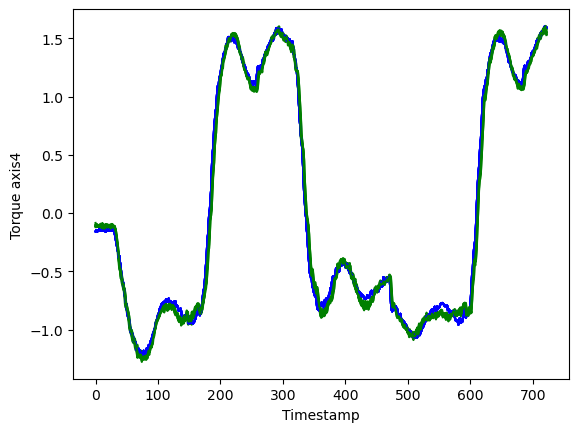

In [24]:
date_FC1 = date(2015, 12, 24)
#Failure Case 1

file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC1_113727087_6700-101962/1426-0051-56_DIAGDATA_20151016_090000__MCC.zip'
ref_FC1, mean_FC1, stv_FC1 = process_file(file_path)

File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC1_113727087_6700-101962/MCCFiles'
RMS_Value_FC1,Stv_FC1,Impulse_factor_FC1,Shape_factor_FC1,torque_areaUnderSignal_FC1, torque_trimmedMean_FC1,torque_signalNoise_FC1, MAX_AMP_FC1, drop_F1, CORR1 = generate_feature_refresh_reference(File_path,ref_FC1, mean_FC1, stv_FC1, date_FC1)

In [25]:
RMS_Value_FC1 = RMS_Value_FC1.dropna(axis=0,how='any')
Stv_FC1 = Stv_FC1.dropna(axis=0,how='any')
torque_areaUnderSignal_FC1 = torque_areaUnderSignal_FC1.dropna(axis=0,how='any')
torque_trimmedMean_FC1 = torque_trimmedMean_FC1.dropna(axis=0,how='any')
torque_signalNoise_FC1 = torque_signalNoise_FC1.dropna(axis=0,how='any')
MAX_AMP_FC1 = MAX_AMP_FC1.dropna(axis=0,how='any')



In [26]:
RMS_Value_FC1 = RMS_Value_FC1.groupby(by='time').mean()
Stv_FC1 = Stv_FC1.groupby(by='time').mean()
torque_areaUnderSignal_FC1 = torque_areaUnderSignal_FC1.groupby(by='time').mean()
torque_trimmedMean_FC1 = torque_trimmedMean_FC1.groupby(by='time').mean()
torque_signalNoise_FC1 = torque_signalNoise_FC1.groupby(by='time').mean()
MAX_AMP_FC1 = MAX_AMP_FC1.groupby(by='time').mean()

<AxesSubplot:xlabel='time'>

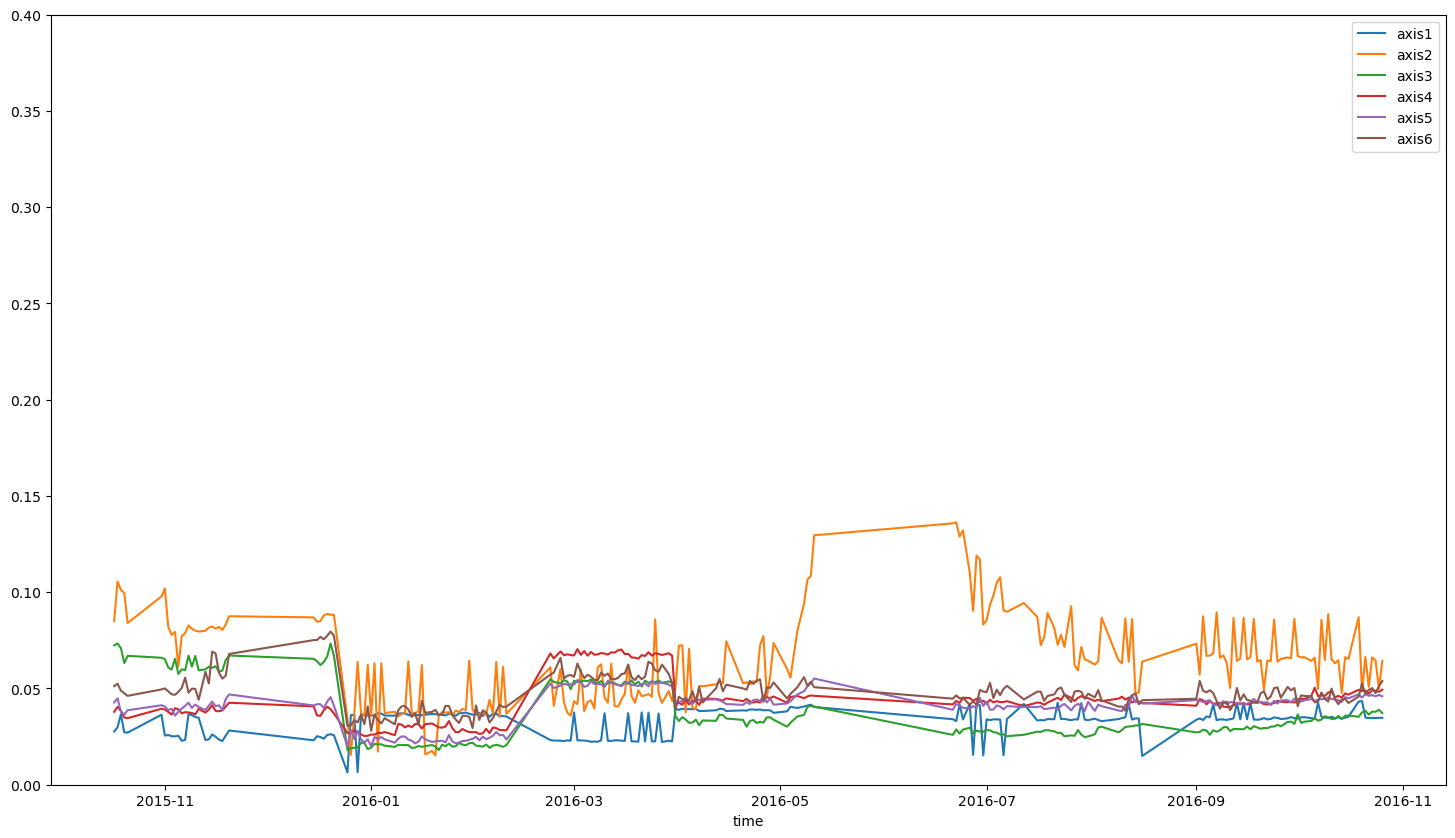

In [27]:


RMS_Value_FC1.plot(figsize=(18,10), ylim =(0,0.4))

<zipfile.ZipFile filename='C:/Users/semihua/Desktop/Mingjie/test data/FC6_33016615_66-62028/1218-0079-56_DIAGDATA_20150410_142226__MCC.zip' mode='r'>
<zipfile.ZipFile filename='C:/Users/semihua/Desktop/Mingjie/test data/FC6_33016615_66-62028/MCCFiles\\1218-0079-56_DIAGDATA_20150821_082242__MCC.zip' mode='r'>


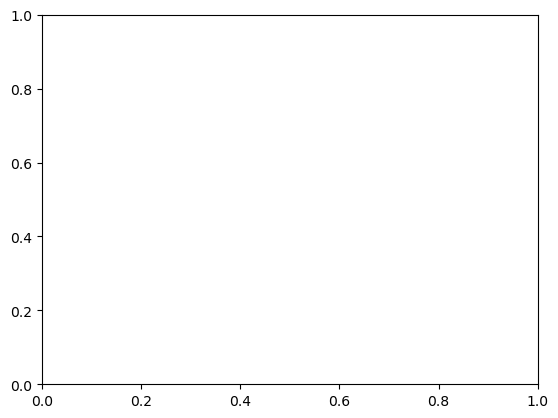

In [28]:
#Failure Case 6
date_FC6 = date(2015, 8, 21)
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC6_33016615_66-62028/1218-0079-56_DIAGDATA_20150410_142226__MCC.zip'
ref_FC6, mean_FC6, stv_FC6 = process_file(file_path)

File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC6_33016615_66-62028/MCCFiles'
RMS_Value_FC6,Stv_FC6,Impulse_factor_FC6,Shape_factor_FC6,torque_areaUnderSignal_FC6, torque_trimmedMean_FC6,torque_signalNoise_FC6, MAX_AMP_FC6, drop_FC6, CORR6 = generate_feature_refresh_reference(File_path,ref_FC6, mean_FC6, stv_FC6, date_FC6)

In [29]:
CORR6[50:]

[array([[1.        , 0.99434304],
        [0.99434304, 1.        ]]),
 array([[1.        , 0.99505025],
        [0.99505025, 1.        ]]),
 array([[1.        , 0.99523854],
        [0.99523854, 1.        ]]),
 array([[1.        , 0.99118401],
        [0.99118401, 1.        ]]),
 array([[1.       , 0.9779173],
        [0.9779173, 1.       ]]),
 array([[1.        , 0.99582809],
        [0.99582809, 1.        ]]),
 array([[1.       , 0.9970016],
        [0.9970016, 1.       ]]),
 array([[1.        , 0.99607836],
        [0.99607836, 1.        ]]),
 array([[1.       , 0.9956359],
        [0.9956359, 1.       ]]),
 array([[1.        , 0.99597142],
        [0.99597142, 1.        ]]),
 array([[1.        , 0.99626837],
        [0.99626837, 1.        ]]),
 array([[1.        , 0.99544948],
        [0.99544948, 1.        ]]),
 array([[1.        , 0.99528185],
        [0.99528185, 1.        ]]),
 array([[1.        , 0.99551176],
        [0.99551176, 1.        ]]),
 array([[1.        , 0.99535457]

<zipfile.ZipFile filename='C:/Users/semihua/Desktop/Mingjie/test data/FC6_33016615_66-62028/1218-0079-56_DIAGDATA_20150410_142226__MCC.zip' mode='r'>


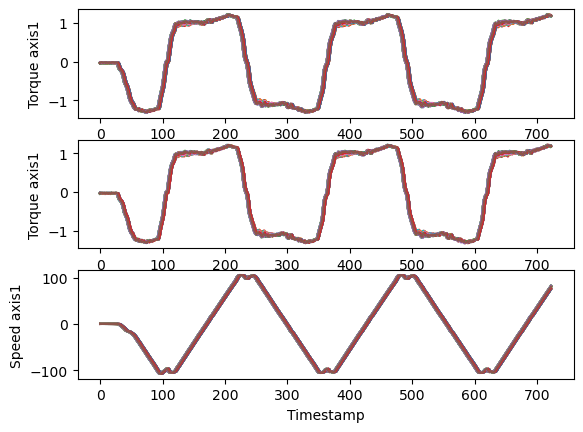

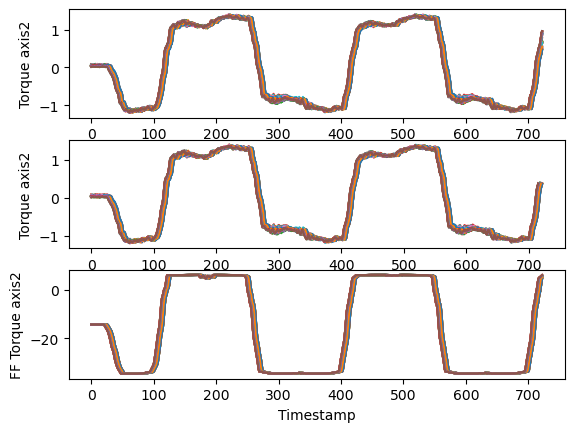

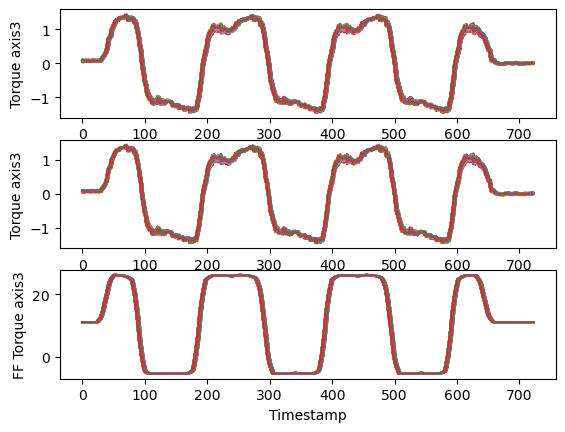

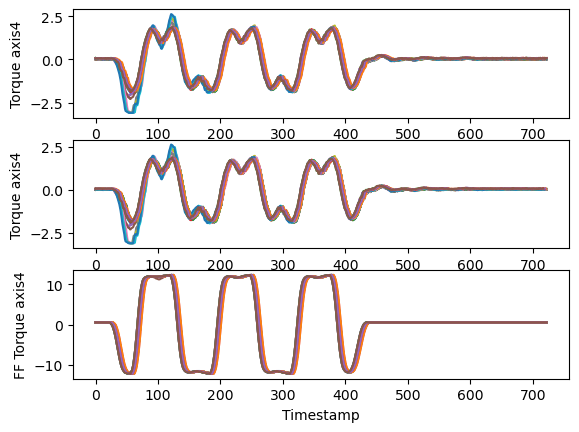

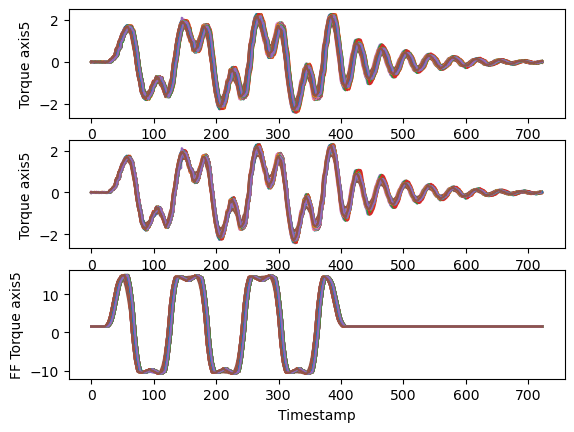

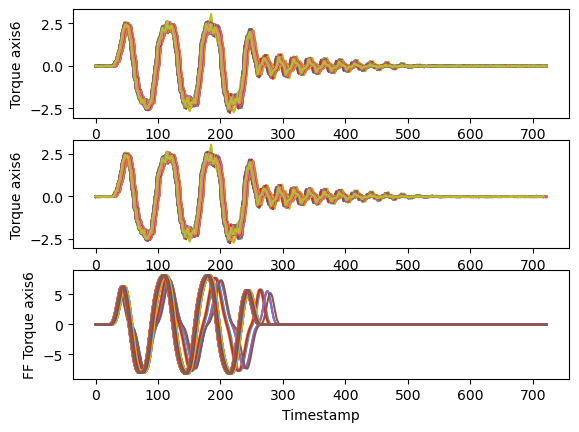

In [30]:
#Failure Case 6
date_FC6 = date(2015, 9, 4)
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC6_33016615_66-62028/1218-0079-56_DIAGDATA_20150410_142226__MCC.zip'
ref_FC6, mean_FC6, stv_FC6 = process_file(file_path)

File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC6_33016615_66-62028/MCCFiles'
RMS_Value_FC6,Stv_FC6,Impulse_factor_FC6,Shape_factor_FC6,torque_areaUnderSignal_FC6, torque_trimmedMean_FC6,torque_signalNoise_FC6, MAX_AMP_FC6 = generate_more_feature(File_path,ref_FC6, mean_FC6, stv_FC6)

In [31]:
RMS_Value_FC6 = RMS_Value_FC6.dropna(axis=0,how='any')
Stv_FC6 = Stv_FC6.dropna(axis=0,how='any')
torque_areaUnderSignal_FC6 = torque_areaUnderSignal_FC6.dropna(axis=0,how='any')
torque_trimmedMean_FC6 = torque_trimmedMean_FC6.dropna(axis=0,how='any')
torque_signalNoise_FC6 = torque_signalNoise_FC6.dropna(axis=0,how='any')
MAX_AMP_FC6 = MAX_AMP_FC6.dropna(axis=0,how='any')

In [32]:
RMS_Value_FC6 = RMS_Value_FC6.groupby(by='time').mean()
Stv_FC6 = Stv_FC6.groupby(by='time').mean()
torque_areaUnderSignal_FC6 = torque_areaUnderSignal_FC6.groupby(by='time').mean()
torque_trimmedMean_FC6 = torque_trimmedMean_FC6.groupby(by='time').mean()
torque_signalNoise_FC6 = torque_signalNoise_FC6.groupby(by='time').mean()
MAX_AMP_FC6 = MAX_AMP_FC6.groupby(by='time').mean()

<AxesSubplot:xlabel='time'>

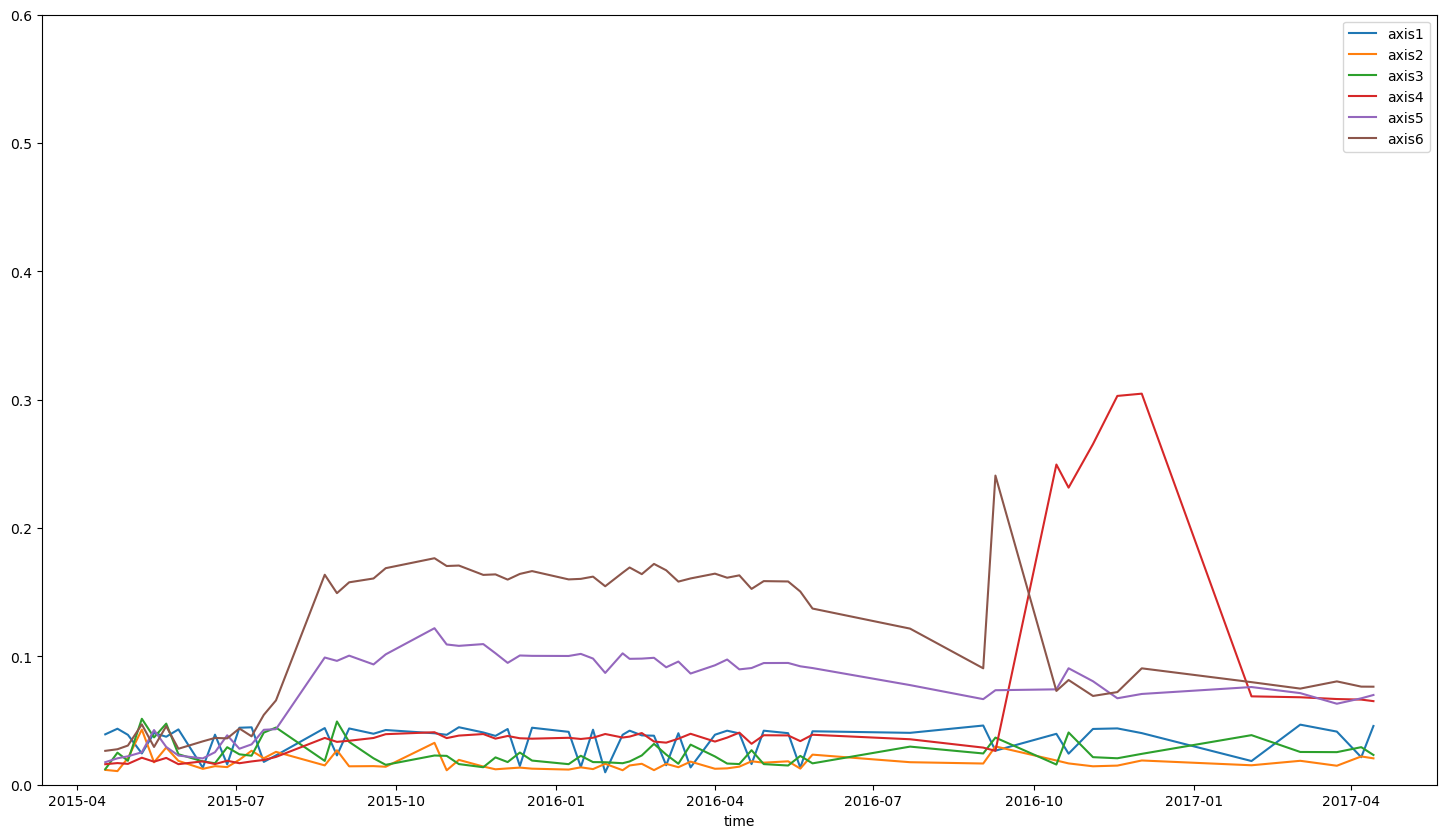

In [33]:
RMS_Value_FC6.plot(figsize=(18,10), ylim = (0,0.6))

<zipfile.ZipFile filename='C:/Users/semihua/Desktop/Mingjie/test data/FC7_130270916_7600-102993/7600-102993_DIAGDATA_20160331_050019__MCC.zip' mode='r'>


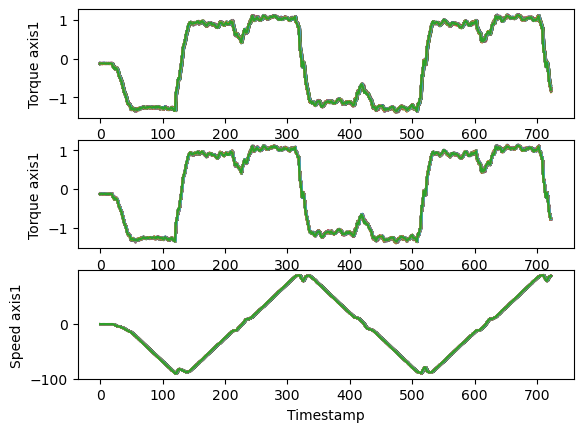

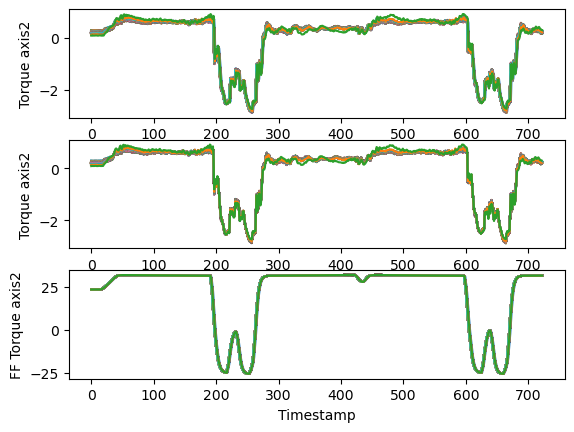

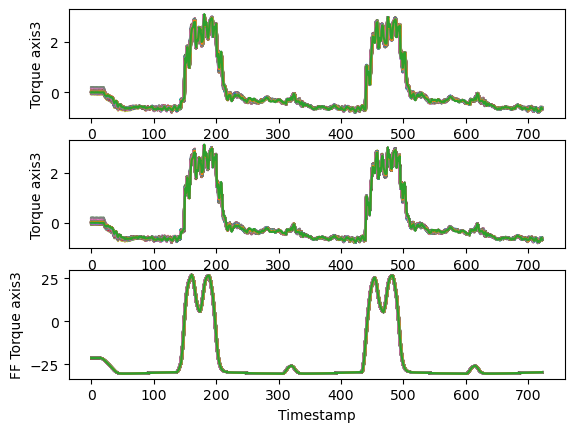

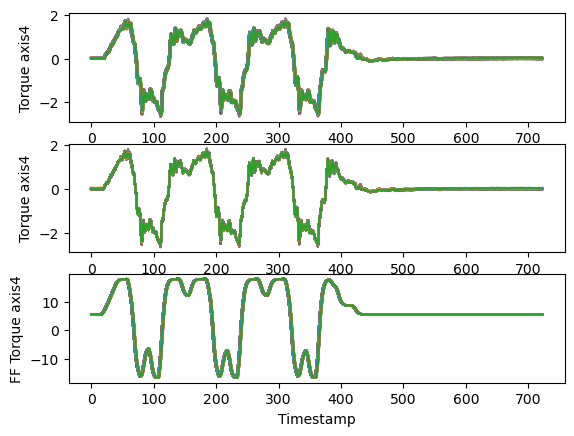

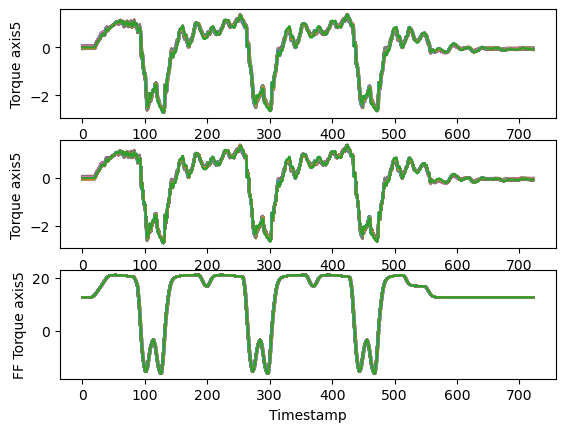

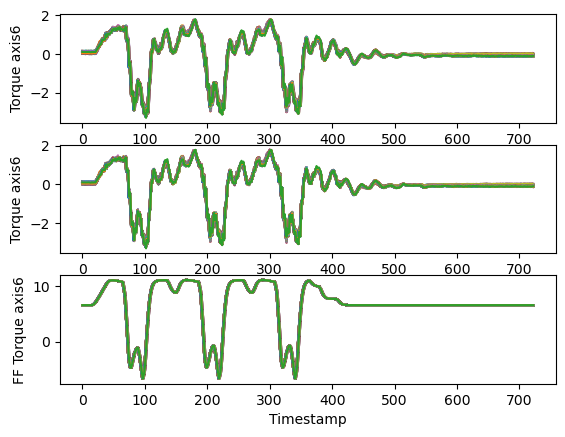

In [34]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC7_130270916_7600-102993/7600-102993_DIAGDATA_20160331_050019__MCC.zip'
ref_FC7, mean_FC7, stv_FC7 = process_file(file_path)
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC7_130270916_7600-102993/MCCFiles'
RMS_Value_FC7,Stv_FC7,Impulse_factor_FC7,Shape_factor_FC7, torque_areaUnderSignal_FC7, torque_trimmedMean_FC7,torque_signalNoise_FC7, MAX_AMP_FC7 = generate_more_feature(File_path,ref_FC7, mean_FC7, stv_FC7)

<zipfile.ZipFile filename='C:/Users/semihua/Desktop/Mingjie/test data/FC7_130270916_7600-102993/7600-102993_DIAGDATA_20160331_050019__MCC.zip' mode='r'>
<zipfile.ZipFile filename='C:/Users/semihua/Desktop/Mingjie/test data/FC7_130270916_7600-102993/MCCFiles\\7600-102993_DIAGDATA_20160703_050008__MCC.zip' mode='r'>


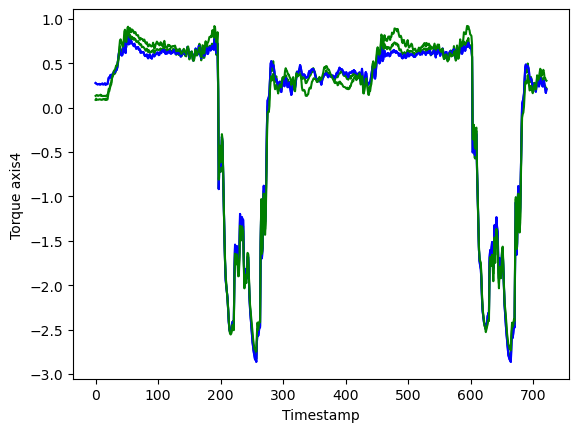

In [35]:
date_FC7 = date(2016, 7, 3)
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC7_130270916_7600-102993/7600-102993_DIAGDATA_20160331_050019__MCC.zip'
ref_FC7, mean_FC7, stv_FC7 = process_file(file_path)
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC7_130270916_7600-102993/MCCFiles'
RMS_Value_FC7,Stv_FC7,Impulse_factor_FC7,Shape_factor_FC7, torque_areaUnderSignal_FC7, torque_trimmedMean_FC7,torque_signalNoise_FC7, MAX_AMP_FC7, drop_FC7, CORR7 = generate_feature_refresh_reference(File_path,ref_FC7, mean_FC7, stv_FC7, date_FC7)

In [36]:
RMS_Value_FC7 = RMS_Value_FC7.dropna(axis=0,how='any')
Stv_FC7 = Stv_FC7.dropna(axis=0,how='any')
torque_areaUnderSignal_FC7 = torque_areaUnderSignal_FC7.dropna(axis=0,how='any')
torque_trimmedMean_FC7 = torque_trimmedMean_FC7.dropna(axis=0,how='any')
torque_signalNoise_FC7 = torque_signalNoise_FC7.dropna(axis=0,how='any')
MAX_AMP_FC7 = MAX_AMP_FC7.dropna(axis=0,how='any')

In [37]:
RMS_Value_FC7 = RMS_Value_FC7.groupby(by='time').mean()
Stv_FC7 = Stv_FC7.groupby(by='time').mean()
torque_areaUnderSignal_FC7 = torque_areaUnderSignal_FC7.groupby(by='time').mean()
torque_trimmedMean_FC7 = torque_trimmedMean_FC7.groupby(by='time').mean()
torque_signalNoise_FC7 = torque_signalNoise_FC7.groupby(by='time').mean()
MAX_AMP_FC7 = MAX_AMP_FC7.groupby(by='time').mean()


<AxesSubplot:xlabel='time'>

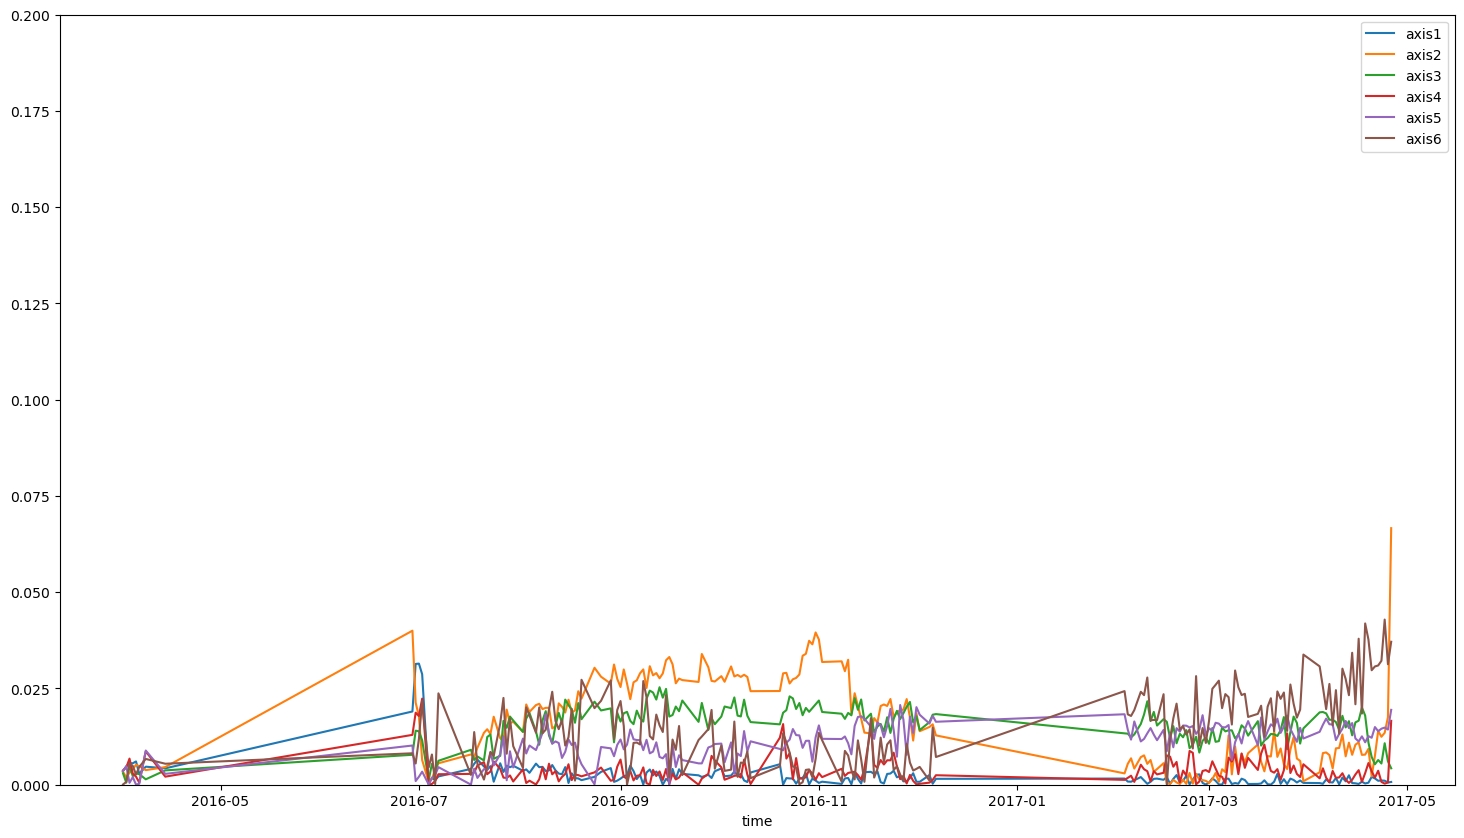

In [38]:
torque_areaUnderSignal_FC7.plot(figsize=(18,10), ylim =(0,0.2))

<zipfile.ZipFile filename='C:/Users/semihua/Desktop/Mingjie/test data/FC8_103507723_6700-100888/1237-0041-56_DIAGDATA_20141107_131229_1a2edf8e-8453-4210-8f9d-4bbc65e75273_MCC.zip' mode='r'>


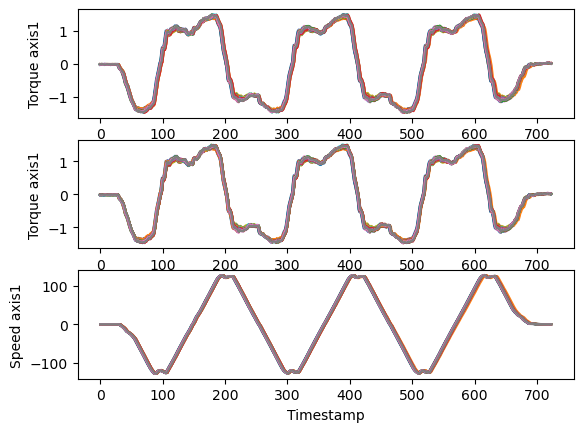

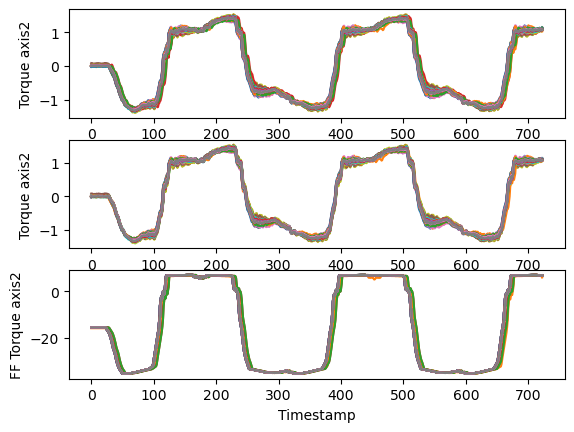

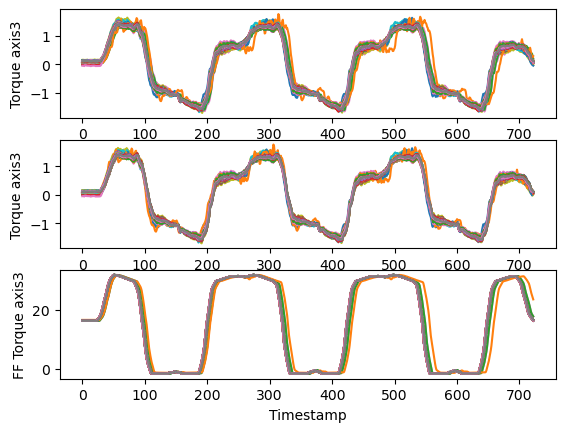

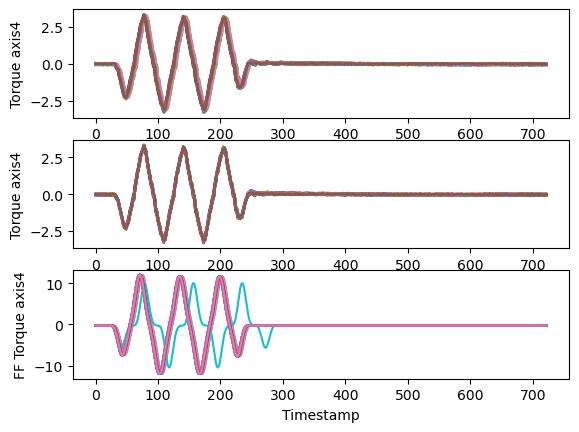

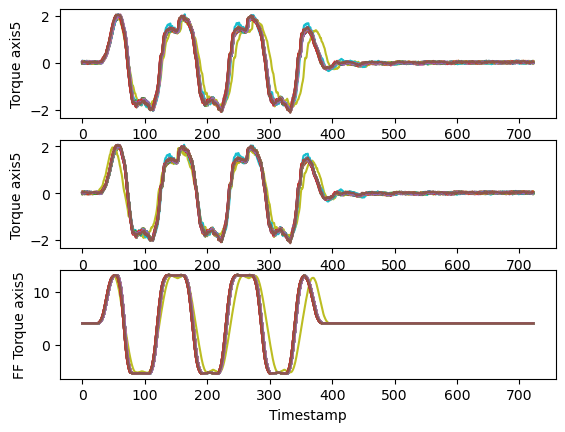

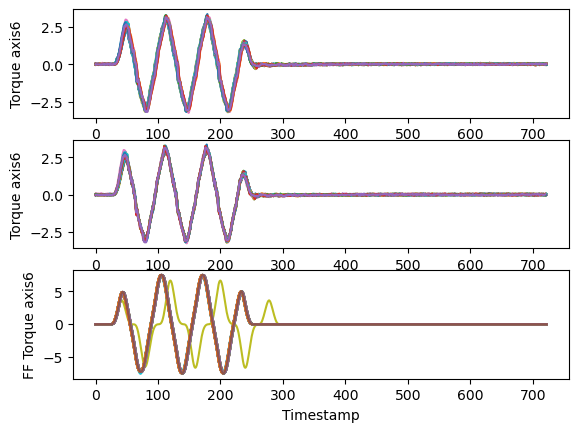

In [39]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC8_103507723_6700-100888/1237-0041-56_DIAGDATA_20141107_131229_1a2edf8e-8453-4210-8f9d-4bbc65e75273_MCC.zip'
ref_FC8, mean_FC8, stv_FC8 = process_file(file_path)
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC8_103507723_6700-100888/MCCFiles'
RMS_Value_FC8,Stv_FC8,Impulse_factor_FC8,Shape_factor_FC8, torque_areaUnderSignal_FC8, torque_trimmedMean_FC8,torque_signalNoise_FC8, MAX_AMP_FC8 = generate_more_feature(File_path,ref_FC8, mean_FC8, stv_FC8)

In [40]:
RMS_Value_FC8 = RMS_Value_FC8.dropna(axis=0,how='any')
Stv_FC8 = Stv_FC8.dropna(axis=0,how='any')
torque_areaUnderSignal_FC8 = torque_areaUnderSignal_FC8.dropna(axis=0,how='any')
torque_trimmedMean_FC8 = torque_trimmedMean_FC8.dropna(axis=0,how='any')
torque_signalNoise_FC8 = torque_signalNoise_FC8.dropna(axis=0,how='any')
MAX_AMP_FC8 = MAX_AMP_FC8.dropna(axis=0,how='any')


In [41]:
RMS_Value_FC8 = RMS_Value_FC8.groupby(by='time').mean()
Stv_FC8 = Stv_FC8.groupby(by='time').mean()
torque_areaUnderSignal_FC8 = torque_areaUnderSignal_FC8.groupby(by='time').mean()
torque_trimmedMean_FC8 = torque_trimmedMean_FC8.groupby(by='time').mean()
torque_signalNoise_FC8 = torque_signalNoise_FC8.groupby(by='time').mean()
MAX_AMP_FC8 = MAX_AMP_FC8.groupby(by='time').mean()


<zipfile.ZipFile filename='C:/Users/semihua/Desktop/Mingjie/test data/FC11_117360760_6640-108111/6640-108111_DIAGDATA_20160223_083249_3f0c9af8-e4b6-44de-ba75-53e13801feb1_MCC.zip' mode='r'>


C:\Temp\ipykernel_17640\2775334714.py:63: RuntimeWarning: invalid value encountered in double_scalars
  torque_signalNoise.loc[i, 'axis1'] = abs((d_m1-ref_m1).mean()/(d_m1-ref_m1).std(ddof=0))
C:\Temp\ipykernel_17640\2775334714.py:84: RuntimeWarning: invalid value encountered in double_scalars
  Impulse_factor.loc[i, 'axis1'] = max(d_m1-ref_m1)/abs(feature.mean(d_m1-ref_m1))
C:\Temp\ipykernel_17640\2775334714.py:87: RuntimeWarning: invalid value encountered in double_scalars
  Shape_factor.loc[i, 'axis1'] = feature.root_mean_square(d_m1-ref_m1)/abs(feature.mean(d_m1-ref_m1))
C:\Temp\ipykernel_17640\2775334714.py:107: RuntimeWarning: invalid value encountered in double_scalars
  torque_signalNoise.loc[i, 'axis2'] = abs((d_m2-ref_m2).mean()/(d_m2-ref_m2).std(ddof=0))
C:\Temp\ipykernel_17640\2775334714.py:114: RuntimeWarning: invalid value encountered in double_scalars
  Impulse_factor.loc[i, 'axis2'] = max(d_m2-ref_m2)/abs(feature.mean(d_m2-ref_m2))
C:\Temp\ipykernel_17640\2775334714.py:

<zipfile.ZipFile filename='C:/Users/semihua/Desktop/Mingjie/test data/FC11_117360760_6640-108111/MCCFiles\\6640-108111_DIAGDATA_20160421_122657_cd22981e-36e8-4a9e-bdf6-326f1d56949c_MCC.zip' mode='r'>


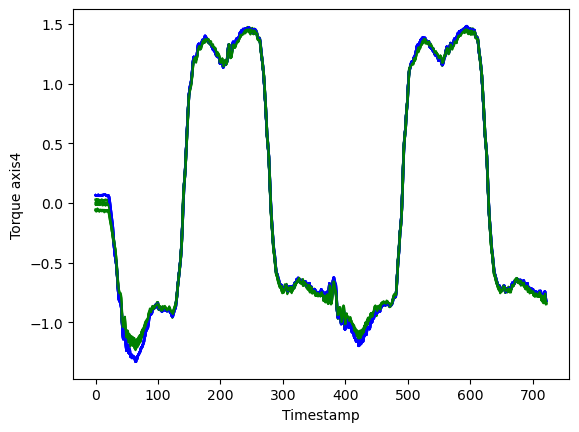

In [42]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC11_117360760_6640-108111/6640-108111_DIAGDATA_20160223_083249_3f0c9af8-e4b6-44de-ba75-53e13801feb1_MCC.zip'
ref_FC11, mean_FC11, stv_FC11 = process_file(file_path)
date_FC11 = date(2016, 4, 18)
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC11_117360760_6640-108111/MCCFiles'
RMS_Value_FC11,Stv_FC11,Impulse_factor_FC11,Shape_factor_FC11, torque_areaUnderSignal_FC11, torque_trimmedMean_FC11,torque_signalNoise_FC11, MAX_AMP_FC11,drop_FC11,CORR11 = generate_feature_refresh_reference(File_path,ref_FC11, mean_FC11, stv_FC11, date_FC11)

In [43]:
drop_FC11

15

In [44]:
RMS_Value_FC11 = RMS_Value_FC11.dropna(axis=0,how='any')
Stv_FC11 = Stv_FC11.dropna(axis=0,how='any')
torque_areaUnderSignal_FC11 = torque_areaUnderSignal_FC11.dropna(axis=0,how='any')
torque_trimmedMean_FC11 = torque_trimmedMean_FC11.dropna(axis=0,how='any')
torque_signalNoise_FC11 = torque_signalNoise_FC11.dropna(axis=0,how='any')
MAX_AMP_FC11 = MAX_AMP_FC11.dropna(axis=0,how='any')

In [45]:
RMS_Value_FC11 = RMS_Value_FC11.groupby(by='time').mean()
Stv_FC11 = Stv_FC11.groupby(by='time').mean()
torque_areaUnderSignal_FC11 = torque_areaUnderSignal_FC11.groupby(by='time').mean()
torque_trimmedMean_FC11 = torque_trimmedMean_FC11.groupby(by='time').mean()
torque_signalNoise_FC11 = torque_signalNoise_FC11.groupby(by='time').mean()
MAX_AMP_FC11 = MAX_AMP_FC11.groupby(by='time').mean()

<AxesSubplot:xlabel='time'>

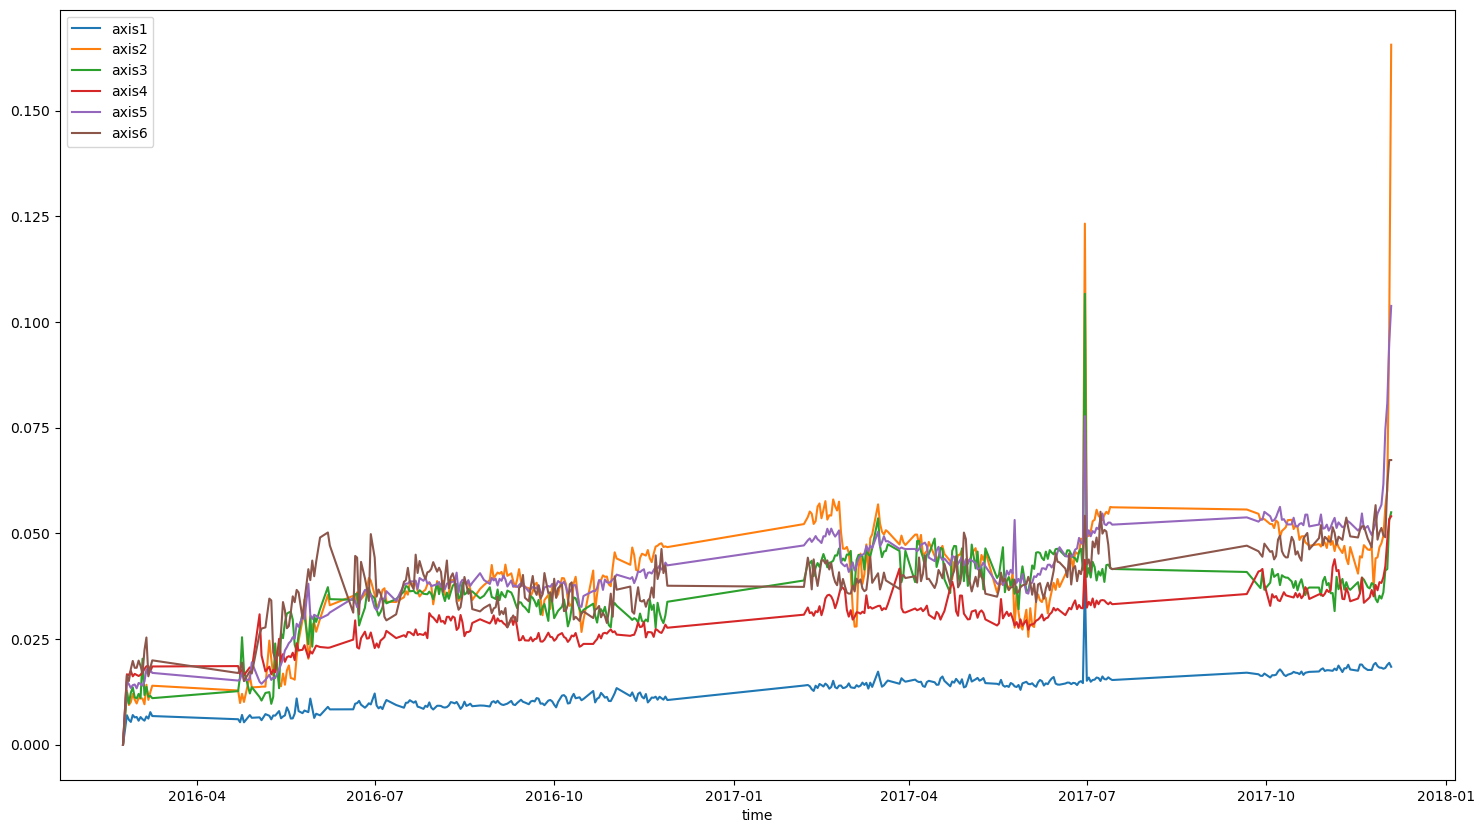

In [46]:
RMS_Value_FC11.plot(figsize=(18,10))

<AxesSubplot:xlabel='time'>

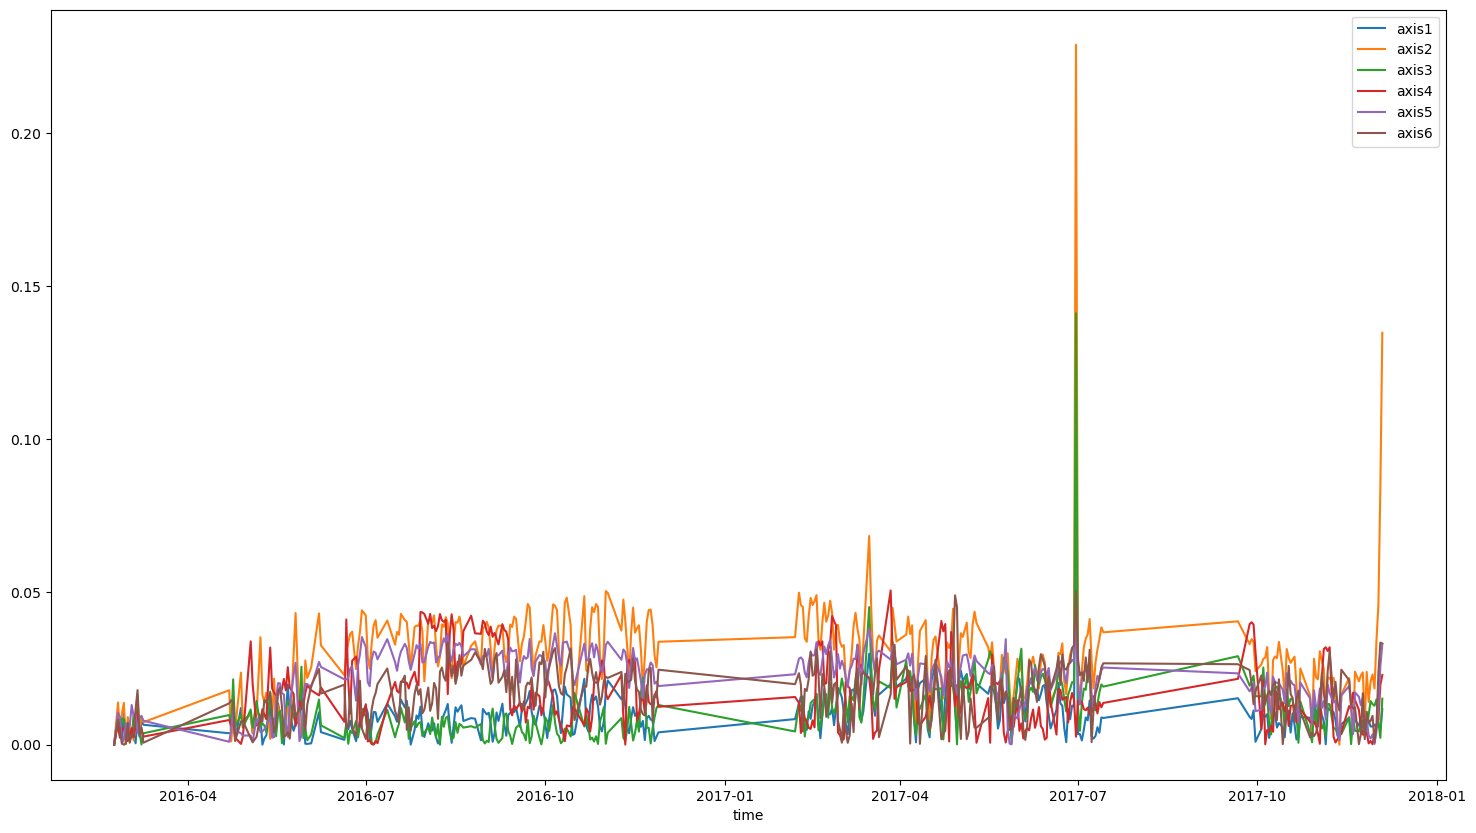

In [47]:
torque_areaUnderSignal_FC11.plot(figsize=(18,10))

In [48]:
torque_areaUnderSignal_FC11[330:]

axis1     axis2     axis3     axis4     axis5     axis6
time                                                                  
2017-10-17  0.011014  0.028477  0.012638  0.006156  0.020272  0.025777
2017-10-18  0.003974  0.026771  0.015080  0.012700  0.020937  0.016597
2017-10-19  0.010256  0.027837  0.014793  0.012852  0.019841  0.015374
2017-10-20  0.006571  0.028822  0.011361  0.012774  0.019483  0.007702
2017-10-21  0.001720  0.019237  0.010105  0.007262  0.013686  0.015010
2017-10-22  0.002262  0.007875  0.000634  0.012061  0.007210  0.017649
2017-10-23  0.009104  0.024950  0.014151  0.011633  0.020310  0.010937
2017-10-28  0.008809  0.016007  0.003763  0.007436  0.015141  0.002420
2017-10-29  0.002034  0.003588  0.000797  0.007558  0.006789  0.004034
2017-10-30  0.013461  0.028120  0.012715  0.007595  0.017772  0.002803
2017-10-31  0.011117  0.022052  0.006767  0.006147  0.012295  0.003873
2017-11-01  0.006115  0.021413  0.011810  0.003609  0.013028  0.006355
2017-11-02  0.013339  0.030589  0.014256  0.000304  0.018368  0.014113
2017-11-03  0.009654  0.027515  0.005326  0.021867  0.011995  0.023370
2017-11-04  0.007756  0.024930  0.006459  0.031309  0.014308  0.017272
2017-11-05  0.000139  0.010005  0.002735  0.031881  0.008244  0.011756
2017-11-06  0.011975  0.022179  0.013344  0.030686  0.019746  0.024001
2017-11-07  0.011441  0.021587  0.013232  0.031878  0.016886  0.030368
2017-11-09  0.010669  0.021867  0.005371  0.002639  0.013809  0.014631
2017-11-10  0.007999  0.018606  0.005263  0.000739  0.014454  0.020536
2017-11-11  0.002957  0.008093  0.003617  0.001747  0.005146  0.013525
2017-11-12  0.002233  0.000004  0.005518  0.002644  0.001497  0.011171
2017-11-13  0.006725  0.016417  0.003437  0.004043  0.016114  0.024551
2017-11-17  0.008835  0.021812  0.009039  0.012642  0.019218  0.021063
2017-11-18  0.002752  0.011336  0.000192  0.011638  0.013596  0.013190
2017-11-19  0.009171  0.003665  0.008452  0.017036  0.003495  0.011785
2017-11-20  0.008024  0.023923  0.004574  0.014580  0.017142  0.012243
2017-11-22  0.006238  0.020726  0.004330  0.011407  0.015698  0.000194
2017-11-23  0.008883  0.022639  0.007078  0.006180  0.012883  0.003463
2017-11-24  0.006195  0.023676  0.007848  0.003335  0.015414  0.016849
2017-11-25  0.003277  0.007212  0.003841  0.003273  0.004500  0.001847
2017-11-26  0.006432  0.023833  0.005131  0.003999  0.008502  0.010799
2017-11-27  0.007960  0.014012  0.009657  0.000445  0.002979  0.007202
2017-11-28  0.005973  0.020745  0.014279  0.001210  0.002041  0.007839
2017-11-29  0.005986  0.022998  0.013269  0.000159  0.003394  0.009452
2017-11-30  0.006594  0.018412  0.012765  0.003780  0.000264  0.000728
2017-12-01  0.005514  0.034026  0.014872  0.006623  0.004371  0.006168
2017-12-02  0.006809  0.045884  0.007627  0.008271  0.012554  0.023550
2017-12-03  0.005031  0.084125  0.002231  0.019568  0.025695  0.033409
2017-12-04  0.011619  0.134759  0.015069  0.022813  0.032920  0.033130

<zipfile.ZipFile filename='C:/Users/semihua/Desktop/Mingjie/test data/FC12_130270916_7600-102993/7600-102993_DIAGDATA_20160331_050019__MCC.zip' mode='r'>
<zipfile.ZipFile filename='C:/Users/semihua/Desktop/Mingjie/test data/FC12_130270916_7600-102993/MCCFiles\\7600-102993_DIAGDATA_20170519_142207_9c2f7b9c-67bd-4d35-8000-6e872e1b666f_MCC.zip' mode='r'>


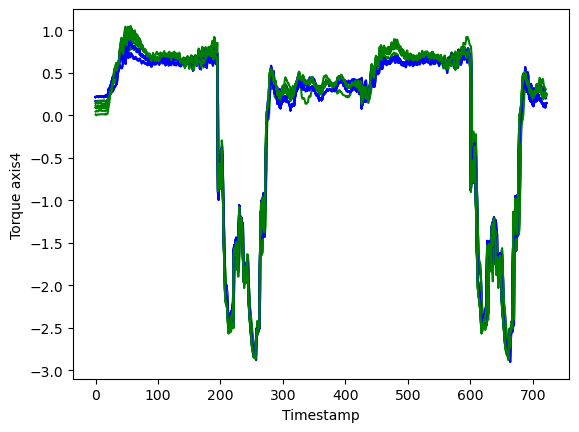

In [49]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC12_130270916_7600-102993/7600-102993_DIAGDATA_20160331_050019__MCC.zip'
ref_FC12, mean_FC12, stv_FC12 = process_file(file_path)
date_FC12 = date(2017, 5, 19)
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC12_130270916_7600-102993/MCCFiles'
RMS_Value_FC12,Stv_FC12,Impulse_factor_FC12,Shape_factor_FC12, torque_areaUnderSignal_FC12, torque_trimmedMean_FC12,torque_signalNoise_FC12, MAX_AMP_FC12,drop_FC12, CORR2 = generate_feature_refresh_reference(File_path,ref_FC12, mean_FC12, stv_FC12,date_FC12)

In [50]:
RMS_Value_FC12 = RMS_Value_FC12.dropna(axis=0,how='any')
Stv_FC12 = Stv_FC12.dropna(axis=0,how='any')
torque_areaUnderSignal_FC12 = torque_areaUnderSignal_FC12.dropna(axis=0,how='any')
torque_trimmedMean_FC12 = torque_trimmedMean_FC12.dropna(axis=0,how='any')
torque_signalNoise_FC12 = torque_signalNoise_FC12.dropna(axis=0,how='any')
MAX_AMP_FC12 = MAX_AMP_FC12.dropna(axis=0,how='any')

In [51]:
RMS_Value_FC12 = RMS_Value_FC12.groupby(by='time').mean()
Stv_FC12 = Stv_FC12.groupby(by='time').mean()
torque_areaUnderSignal_FC12 = torque_areaUnderSignal_FC12.groupby(by='time').mean()
torque_trimmedMean_FC12 = torque_trimmedMean_FC12.groupby(by='time').mean()
torque_signalNoise_FC12 = torque_signalNoise_FC12.groupby(by='time').mean()
MAX_AMP_FC12 = MAX_AMP_FC12.groupby(by='time').mean()

In [52]:
line_FC10 = [date(2019, 4, 18),date(2019, 6, 5)]
line_FC2 = [date(2015, 3, 20),date(2015, 4, 3)]
line_FC1 = [date(2016, 5, 6),date(2016, 5, 15)]
line_FC6 = [date(2016, 10, 1),date(2017, 2, 4)]
line_FC7 = [date(2017, 4, 20),date(2017, 4, 26)]
line_FC8 = [date(2016, 10, 19),date(2017, 1, 23)]
line_FC11 = [date(2017, 11, 26),date(2017, 12, 6)]
line_FC12 = [[date(2017, 12, 17),date(2017, 12, 22)],
            [date(2017,4,22), date(2017,4,27)]]
Failure_period = [line_FC10, line_FC2, line_FC1, line_FC6, line_FC7, line_FC8,line_FC11, line_FC12]

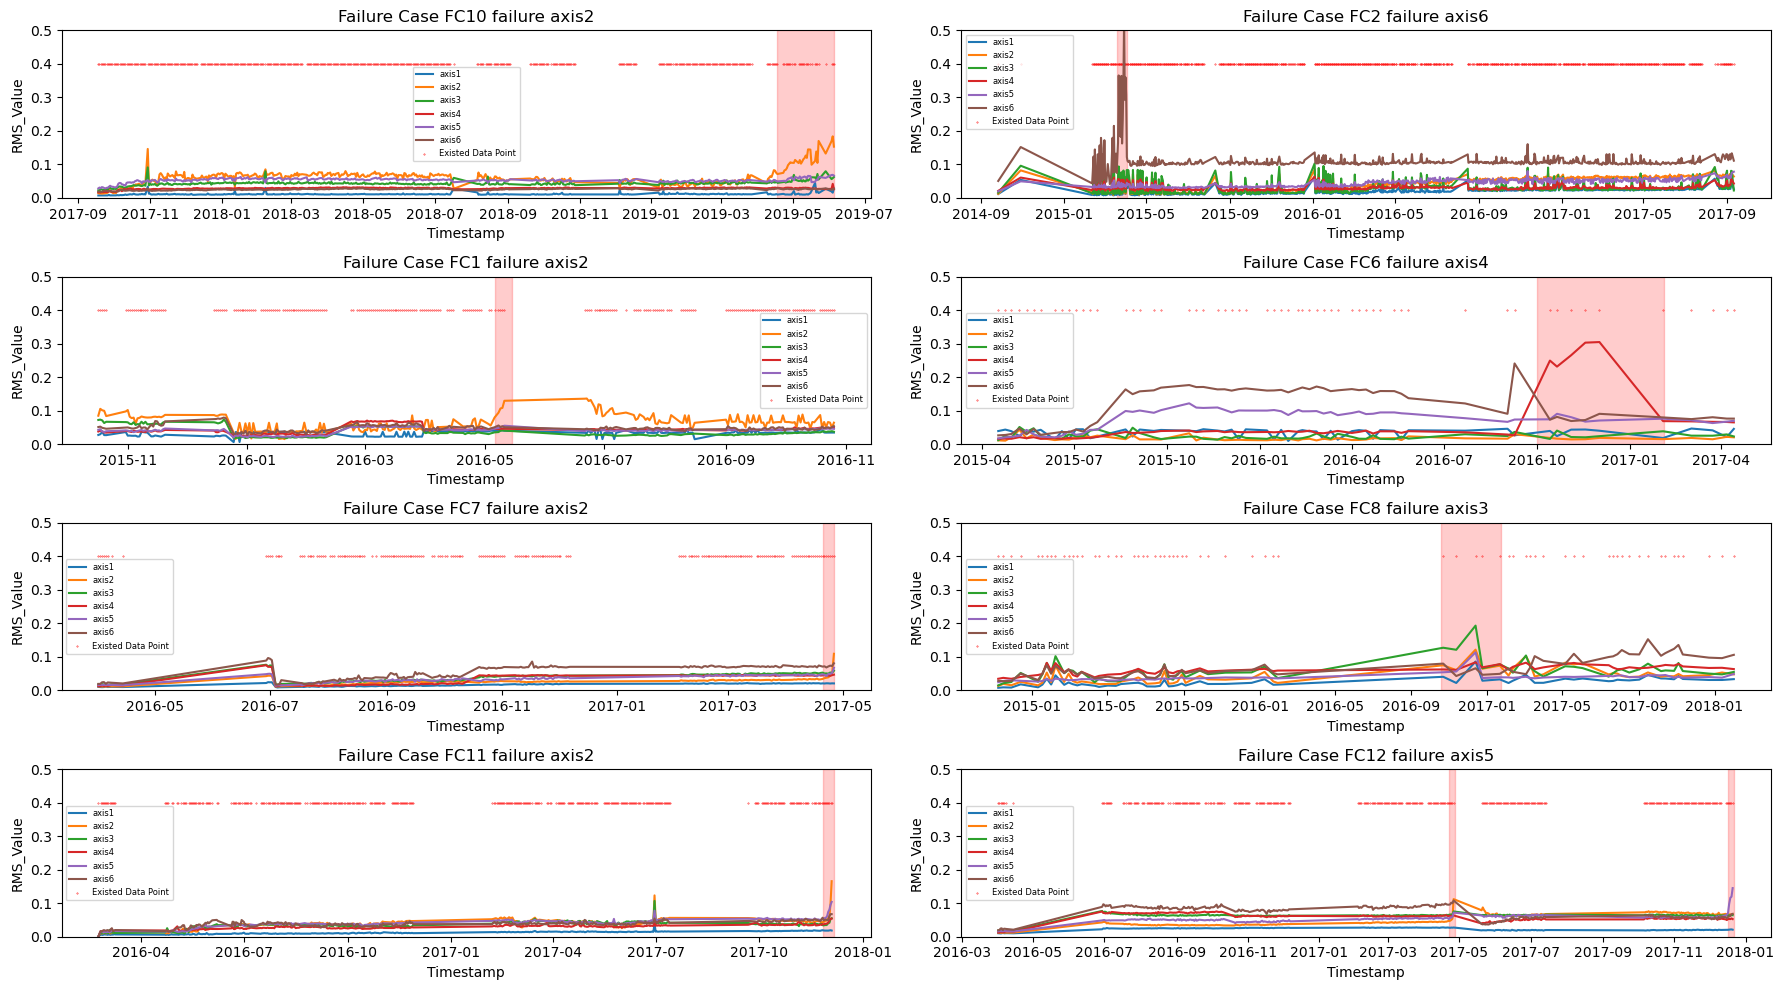

In [53]:

axis_list = ['axis1','axis2','axis3','axis4','axis5','axis6']
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18,10))

data = {
    'FC10 failure axis2': RMS_Value_FC10,
    'FC2 failure axis6': RMS_Value_FC2,
    'FC1 failure axis2': RMS_Value_FC1,
    'FC6 failure axis4': RMS_Value_FC6,
    'FC7 failure axis2': RMS_Value_FC7,
    'FC8 failure axis3': RMS_Value_FC8,
    'FC11 failure axis2': RMS_Value_FC11,
    'FC12 failure axis5': RMS_Value_FC12
}

for i, (fc, d) in enumerate(data.items()):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    for index in axis_list:
        ax.plot(d[index], label=index)
        ax.set_title(f'Failure Case {fc}')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('RMS_Value')
        ax.set_ylim(0, .5)
        ax.legend()
    if isinstance(Failure_period[i][0], list):
        for x in Failure_period[i]:
            ax.axvspan(x[0], x[1], alpha=0.2, color='red')
    else:
        ax.axvspan(Failure_period[i][0], Failure_period[i][1], alpha=0.2, color='red')
    ax.scatter(x = d.index, y =np.full(shape=len(d.index), fill_value=0.4),s=0.1, color='r', label= 'Existed Data Point' )
    ax.legend(loc= "best",fontsize="6")


plt.tight_layout()



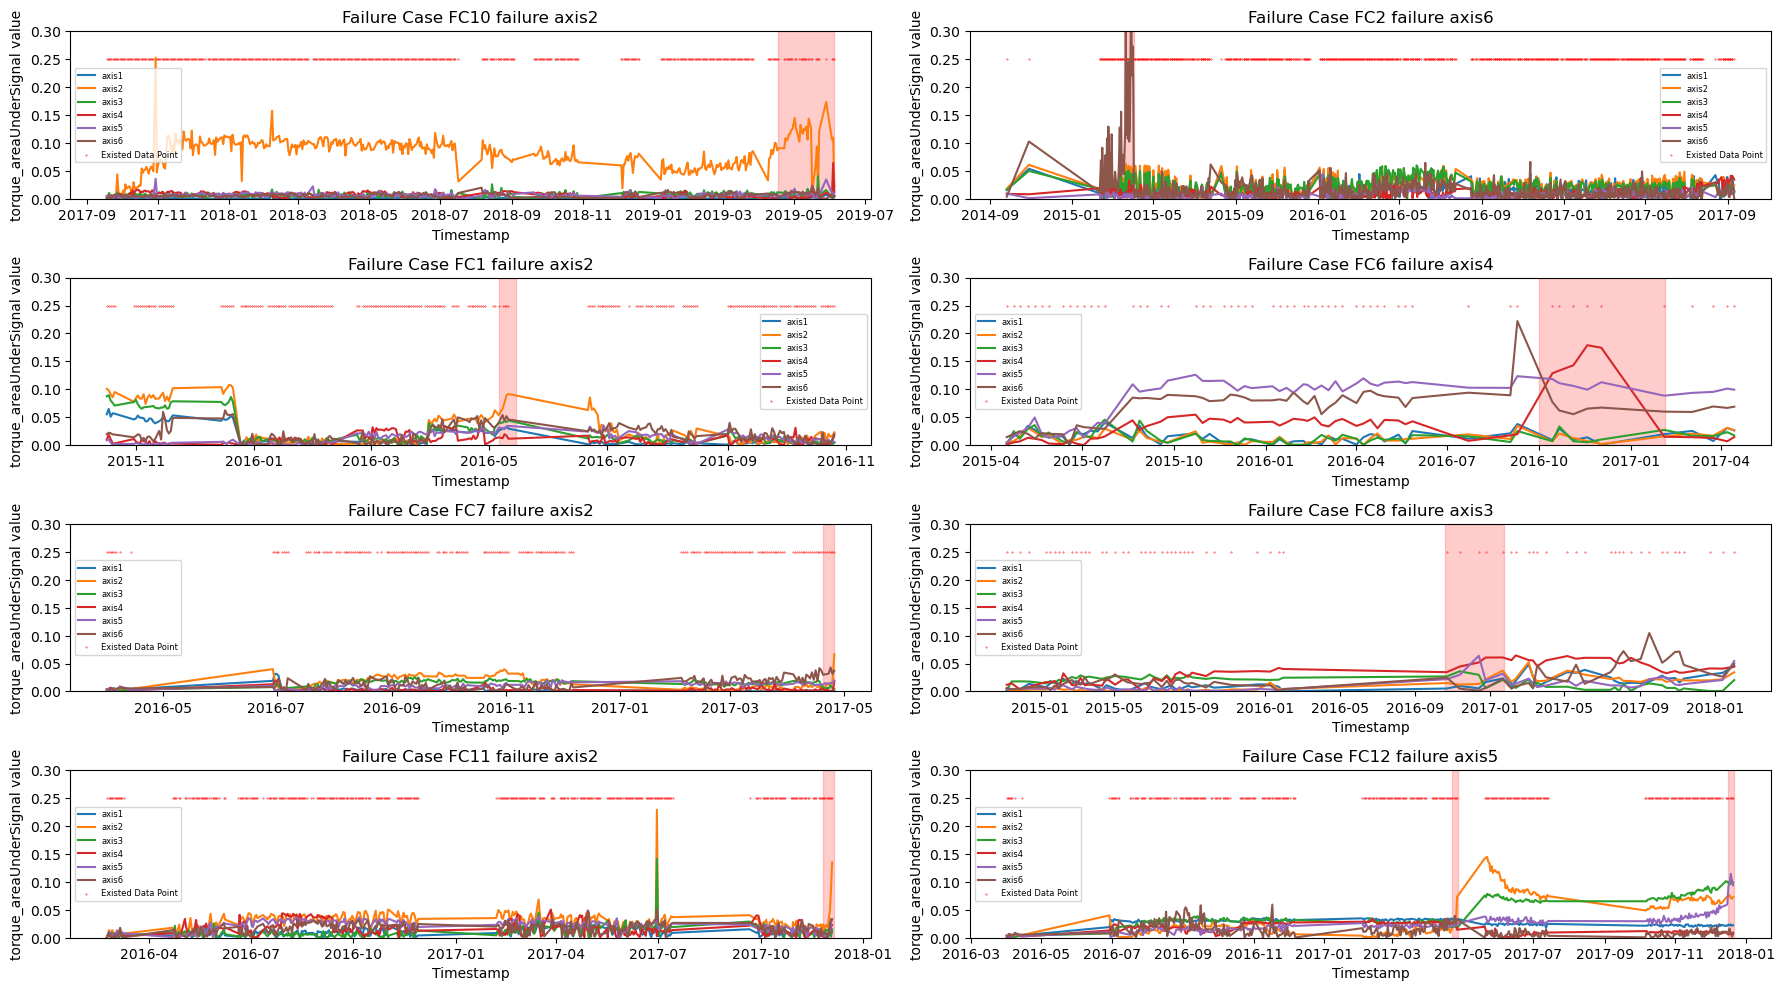

In [54]:
axis_list = ['axis1','axis2','axis3','axis4','axis5','axis6']
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18,10))

data = {
    'FC10 failure axis2': torque_areaUnderSignal_FC10,
    'FC2 failure axis6': torque_areaUnderSignal_FC2,
    'FC1 failure axis2': torque_areaUnderSignal_FC1,
    'FC6 failure axis4': torque_areaUnderSignal_FC6,
    'FC7 failure axis2': torque_areaUnderSignal_FC7,
    'FC8 failure axis3': torque_areaUnderSignal_FC8,
    'FC11 failure axis2': torque_areaUnderSignal_FC11,
    'FC12 failure axis5': torque_areaUnderSignal_FC12
}

for i, (fc, d) in enumerate(data.items()):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    for index in axis_list:
        ax.plot(d[index], label=index)
        ax.set_title(f'Failure Case {fc}')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('torque_areaUnderSignal value')
        ax.set_ylim(0, .3)
        ax.legend()
    if isinstance(Failure_period[i][0], list):
        for x in Failure_period[i]:
            ax.axvspan(x[0], x[1], alpha=0.2, color='red')
    else:
        ax.axvspan(Failure_period[i][0], Failure_period[i][1], alpha=0.2, color='red')
    ax.scatter(x = d.index, y =np.full(shape=len(d.index), fill_value=0.25),s=0.1, color='r', label= 'Existed Data Point' )
    ax.legend(loc= "best",fontsize="6")


plt.tight_layout()


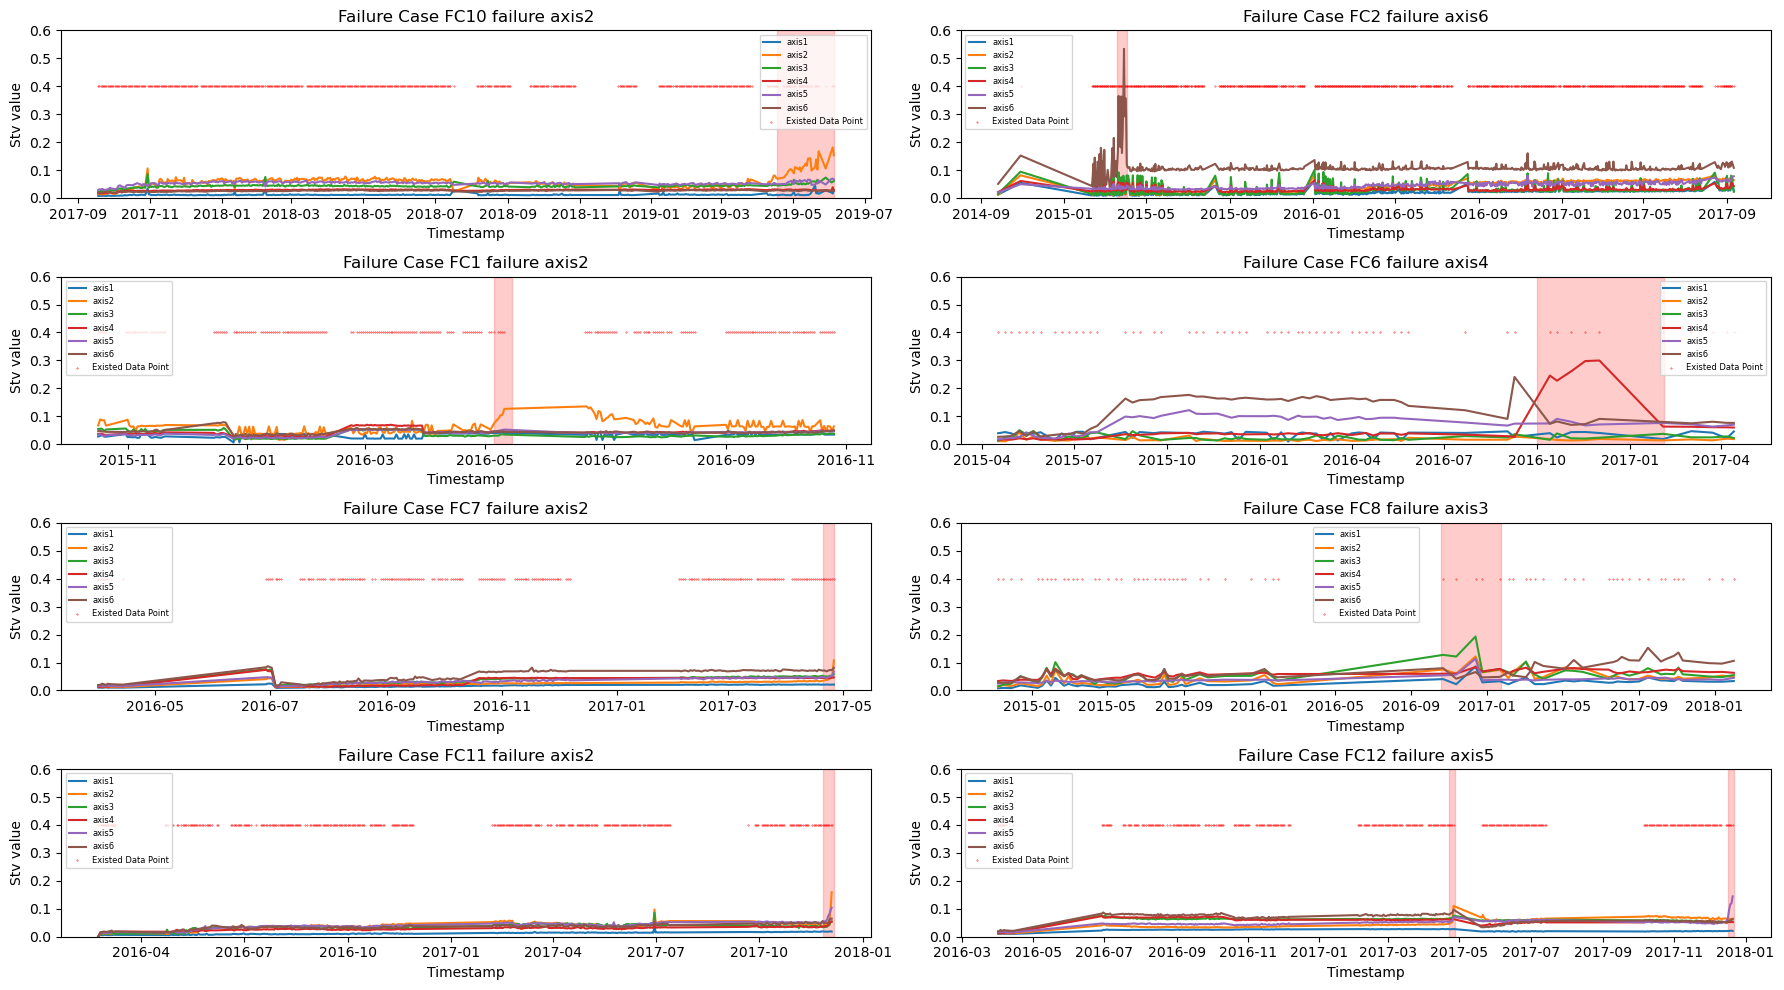

In [55]:
axis_list = ['axis1','axis2','axis3','axis4','axis5','axis6']
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18,10))

data = {
    'FC10 failure axis2': Stv_FC10,
    'FC2 failure axis6': Stv_FC2,
    'FC1 failure axis2': Stv_FC1,
    'FC6 failure axis4': Stv_FC6,
    'FC7 failure axis2': Stv_FC7,
    'FC8 failure axis3': Stv_FC8,
    'FC11 failure axis2': Stv_FC11,
    'FC12 failure axis5': Stv_FC12
}

for i, (fc, d) in enumerate(data.items()):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    for index in axis_list:
        ax.plot(d[index], label=index)
        ax.set_title(f'Failure Case {fc}')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Stv value')
        ax.set_ylim(0, .6)
        ax.legend()
        
    if isinstance(Failure_period[i][0], list):
        for x in Failure_period[i]:
            ax.axvspan(x[0], x[1], alpha=0.2, color='red')
    else:
        ax.axvspan(Failure_period[i][0], Failure_period[i][1], alpha=0.2, color='red')
    ax.scatter(x = d.index, y =np.full(shape=len(d.index), fill_value=0.4),s=0.1, color='r', label= 'Existed Data Point' )
    ax.legend(loc= "best",fontsize="6")

plt.tight_layout()


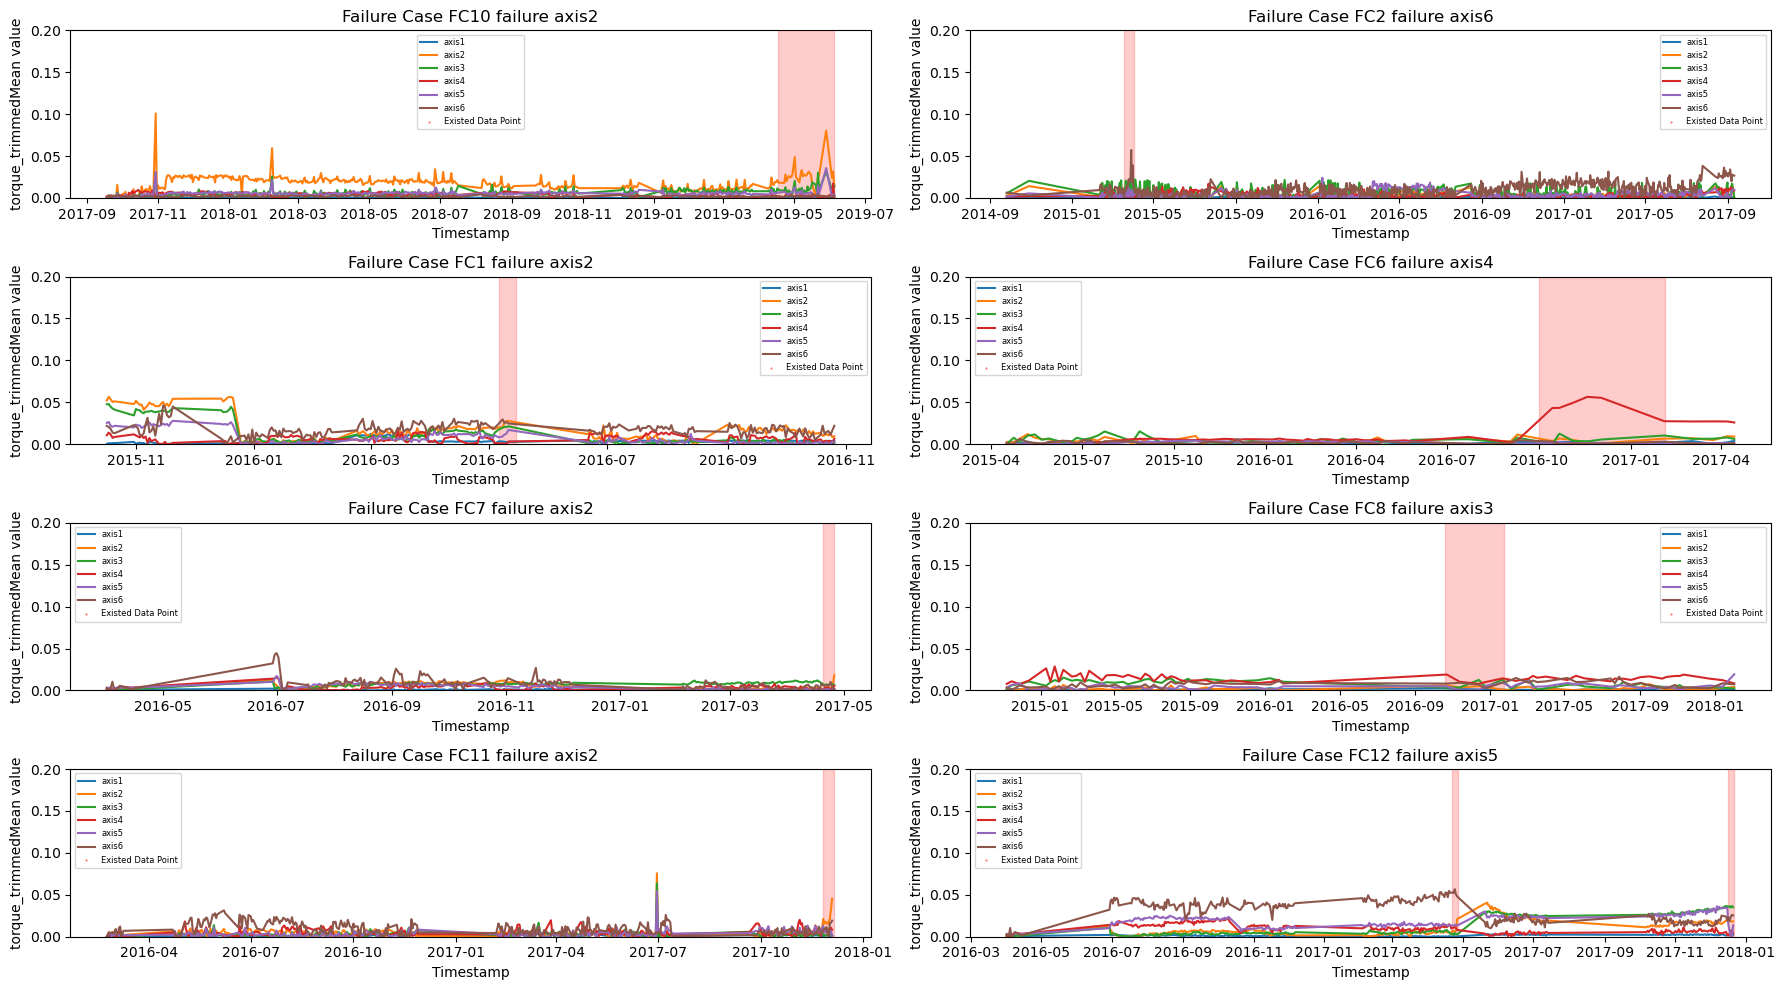

In [56]:
axis_list = ['axis1','axis2','axis3','axis4','axis5','axis6']
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18,10))

data = {
    'FC10 failure axis2': torque_trimmedMean_FC10,
    'FC2 failure axis6': torque_trimmedMean_FC2,
    'FC1 failure axis2': torque_trimmedMean_FC1,
    'FC6 failure axis4': torque_trimmedMean_FC6,
    'FC7 failure axis2': torque_trimmedMean_FC7,
    'FC8 failure axis3': torque_trimmedMean_FC8,
    'FC11 failure axis2': torque_trimmedMean_FC11,
    'FC12 failure axis5': torque_trimmedMean_FC12
}



for i, (fc, d) in enumerate(data.items()):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    for index in axis_list:
        

        
        ax.plot(d[index], label=index)
        ax.set_title(f'Failure Case {fc}')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('torque_trimmedMean value')
        ax.set_ylim(0, .2)
        ax.legend()
    if isinstance(Failure_period[i][0], list):
        for x in Failure_period[i]:
            ax.axvspan(x[0], x[1], alpha=0.2, color='red')
    else:
        ax.axvspan(Failure_period[i][0], Failure_period[i][1], alpha=0.2, color='red')
    
    ax.scatter(x = d.index, y =np.full(shape=len(d.index), fill_value=0.25),s=0.1, color='r', label= 'Existed Data Point' )
    ax.legend(loc= "best",fontsize="6")


plt.tight_layout()


In [57]:
torque_trimmedMean_FC12 = torque_trimmedMean_FC12.dropna(axis=0,how='any')
torque_signalNoise_FC12 = torque_signalNoise_FC12.dropna(axis=0,how='any')
MAX_AMP_FC12 = MAX_AMP_FC12.dropna(axis=0,how='any')

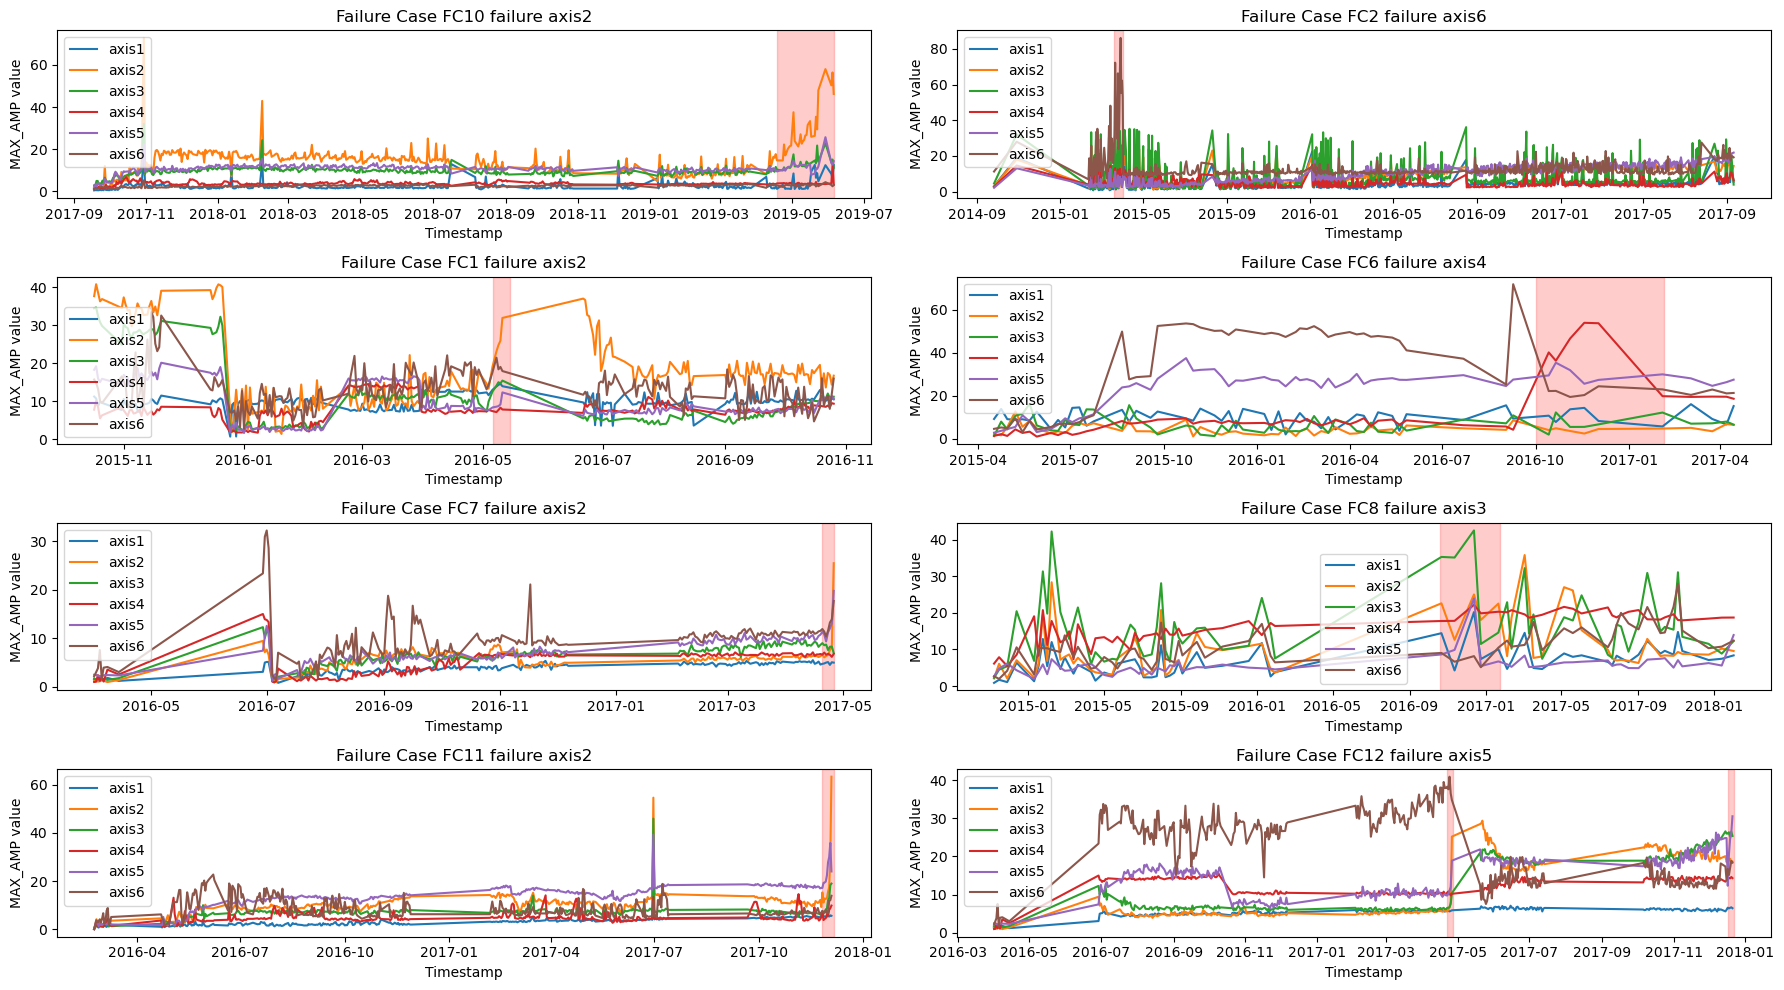

In [58]:
axis_list = ['axis1','axis2','axis3','axis4','axis5','axis6']
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18,10))

data = {
    'FC10 failure axis2':MAX_AMP_FC10,
    'FC2 failure axis6': MAX_AMP_FC2,
    'FC1 failure axis2': MAX_AMP_FC1,
    'FC6 failure axis4': MAX_AMP_FC6,
    'FC7 failure axis2': MAX_AMP_FC7,
    'FC8 failure axis3': MAX_AMP_FC8,
    'FC11 failure axis2': MAX_AMP_FC11,
    'FC12 failure axis5': MAX_AMP_FC12
}

for i, (fc, d) in enumerate(data.items()):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    for index in axis_list:
        ax.plot(d[index], label=index)
        ax.set_title(f'Failure Case {fc}')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('MAX_AMP value')
#         ax.set_ylim(0, .2)
        ax.legend()
    if isinstance(Failure_period[i][0], list):
        for x in Failure_period[i]:
            ax.axvspan(x[0], x[1], alpha=0.2, color='red')
    else:
        ax.axvspan(Failure_period[i][0], Failure_period[i][1], alpha=0.2, color='red')
    
plt.legend()
plt.tight_layout()


# Features for each axis

In [59]:
feature_axis1_FC2 = pd.concat([RMS_Value_FC2['axis1'],Stv_FC2['axis1'],torque_areaUnderSignal_FC2['axis1']],axis=1)
feature_axis1_FC2.columns = ['RMS','Stv','areaUnderSignal']

feature_axis1_FC10 = pd.concat([RMS_Value_FC10['axis1'],Stv_FC10['axis1'],torque_areaUnderSignal_FC10['axis1']],axis=1)
feature_axis1_FC10.columns = ['RMS','Stv','areaUnderSignal']

feature_axis2_FC2 = pd.concat([RMS_Value_FC2['axis2'],Stv_FC2['axis2'],torque_areaUnderSignal_FC2['axis2']],axis=1)
feature_axis2_FC2.columns = ['RMS','Stv','areaUnderSignal']

feature_axis2_FC10 = pd.concat([RMS_Value_FC10['axis2'],Stv_FC10['axis2'],torque_areaUnderSignal_FC10['axis2']],axis=1)
feature_axis2_FC10.columns = ['RMS','Stv','areaUnderSignal']

feature_axis3_FC2 = pd.concat([RMS_Value_FC2['axis3'],Stv_FC2['axis3'],torque_areaUnderSignal_FC2['axis3']],axis=1)
feature_axis3_FC2.columns = ['RMS','Stv','areaUnderSignal']

feature_axis3_FC10 = pd.concat([RMS_Value_FC10['axis3'],Stv_FC10['axis3'],torque_areaUnderSignal_FC10['axis3']],axis=1)
feature_axis3_FC10.columns = ['RMS','Stv','areaUnderSignal']

feature_axis4_FC2 = pd.concat([RMS_Value_FC2['axis4'],Stv_FC2['axis4'],torque_areaUnderSignal_FC2['axis4']],axis=1)
feature_axis4_FC2.columns = ['RMS','Stv','areaUnderSignal']

feature_axis4_FC10 = pd.concat([RMS_Value_FC10['axis4'],Stv_FC10['axis4'],torque_areaUnderSignal_FC10['axis4']],axis=1)
feature_axis4_FC10.columns = ['RMS','Stv','areaUnderSignal']

feature_axis5_FC2 = pd.concat([RMS_Value_FC2['axis5'],Stv_FC2['axis5'],torque_areaUnderSignal_FC2['axis5']],axis=1)
feature_axis5_FC2.columns = ['RMS','Stv','areaUnderSignal']

feature_axis5_FC10 = pd.concat([RMS_Value_FC10['axis5'],Stv_FC10['axis5'],torque_areaUnderSignal_FC10['axis5']],axis=1)
feature_axis5_FC10.columns = ['RMS','Stv','areaUnderSignal']

feature_axis6_FC2 = pd.concat([RMS_Value_FC2['axis6'],Stv_FC2['axis6'],torque_areaUnderSignal_FC2['axis6']],axis=1)
feature_axis6_FC2.columns = ['RMS','Stv','areaUnderSignal']

feature_axis6_FC10 = pd.concat([RMS_Value_FC10['axis6'],Stv_FC10['axis6'],torque_areaUnderSignal_FC10['axis6']],axis=1)
feature_axis6_FC10.columns = ['RMS','Stv','areaUnderSignal']

In [60]:
Failure_period = [line_FC10, line_FC2, line_FC1, line_FC6, line_FC7, line_FC8,line_FC11, line_FC12]

In [61]:
data1 = feature_axis1_FC2
data2 = feature_axis2_FC2
data3 = feature_axis3_FC2
data4 = feature_axis4_FC2
data5 = feature_axis5_FC2
data6 = feature_axis6_FC2
frames_FC2 = [data1, data2, data3, data4, data5, data6]



# Aggregating Features

1. Distance between the centriod of the reference cluster and the updated data points

In [62]:
# Global
def centriod_distance(ref_cluster,new):
    x = ref_cluster['RMS']
    y = ref_cluster['Stv']
    z = ref_cluster['areaUnderSignal']
    middle = np.average(x), np.average(y), np.average(z)
    D = np.linalg.norm(new - middle)
    return D
# Get the reference cluster
def plot_distance_local(frames,k,failure_Case,ax,Failure_period):
    
    
    ref_cluster_FCX = {
    'axis1': frames[0][0:k],
    'axis2': frames[1][0:k],
    'axis3': frames[2][0:k],
    'axis4': frames[3][0:k],
    'axis5': frames[4][0:k],
    'axis6': frames[5][0:k],

    }

    
    data = {
        'axis1': frames[0][k+1:],
        'axis2': frames[1][k+1:],
        'axis3': frames[2][k+1:],
        'axis4': frames[3][k+1:],
        'axis5': frames[4][k+1:],
        'axis6': frames[5][k+1:],

    }
    
    Dist = [[],[],[],[],[],[]]
    Distance_FCX = {}
    for i, (fc, d) in enumerate(data.items()):
        x = pd.to_datetime(d.index)
        for index, row in d.iterrows():
            Dist[i].append(centriod_distance(ref_cluster_FCX[fc],row))
        Distance_FCX[fc] = Dist[i]

        ax.plot(x, Distance_FCX[fc],label = fc)
    if isinstance(Failure_period[0], list):
        for x in Failure_period:
            ax.axvspan(x[0], x[1], alpha=0.2,  color='yellow',label='failure period')
    else:
        ax.axvspan(Failure_period[0], Failure_period[1], alpha=0.2, color='yellow')
#     ax.set_ylim(0, 0.5)
    ax.set_title(failure_Case)
    ax.legend()
    return Distance_FCX
    
    
def plot_distance_global(frames,k,failure_Case,ax,Failure_period):
        
    ref_cluster_FCX = pd.concat([frames[0][0:10],
                                 frames[1][0:10],
                                 frames[2][0:10],
                                 frames[3][0:10],
                                 frames[4][0:10],
                                 frames[5][0:10]],axis = 0)

    
    data = {
        'axis1': frames[0][k+1:],
        'axis2': frames[1][k+1:],
        'axis3': frames[2][k+1:],
        'axis4': frames[3][k+1:],
        'axis5': frames[4][k+1:],
        'axis6': frames[5][k+1:],

    }
    
    Dist = [[],[],[],[],[],[]]
    Distance_FCX = {}
    for i, (fc, d) in enumerate(data.items()):
        x = pd.to_datetime(d.index)
        for index, row in d.iterrows():
            Dist[i].append(centriod_distance(ref_cluster_FCX,row))
        Distance_FCX[fc] = Dist[i]

        ax.plot(x, Distance_FCX[fc],label = fc)
    if isinstance(Failure_period[0], list):
        for x in Failure_period:
            ax.axvspan(x[0], x[1], alpha=0.2,  color='yellow',label='failure period')
    else:
        ax.axvspan(Failure_period[0], Failure_period[1], alpha=0.2, color='yellow',label='failure period')
#     ax.set_ylim(0, 0.5)
    ax.set_title(failure_Case)
    ax.legend()
    return Distance_FCX


# K-means 

In [63]:
from sklearn.svm import OneClassSVM


def Kmeans(frames, k, title, failure_period):
    gamma = 2.0
    reference = pd.concat([frames[0][0:k],
                                         frames[1][0:k],
                                         frames[2][0:k],
                                         frames[3][0:k],
                                         frames[4][0:k],
                                         frames[5][0:k]],axis = 0)

    fig, ax = plt.subplots(1,figsize=(18,10))
    # Train the local outlier factor (LOF) model for novelty detection
    OneclassSVM_novelty = OneClassSVM(gamma=gamma, kernel="rbf", nu=0.05).fit(reference)
    # Predict novelties
    data = {
            'axis1': frames[0][k+1:],
            'axis2': frames[1][k+1:],
            'axis3': frames[2][k+1:],
            'axis4': frames[3][k+1:],
            'axis5': frames[4][k+1:],
            'axis6': frames[5][k+1:],

        }

    Dist = [[],[],[],[],[],[]]
    Distance_FCX = {}

    for i, (fc, d) in enumerate(data.items()):
        x = pd.to_datetime(data1[k+1:].index)

        for index, row in d.iterrows():
            row = row.to_numpy()
            row = row.reshape(1,3)
            prediction_novelty = OneclassSVM_novelty.predict(row)
            score = OneclassSVM_novelty.score_samples(row)
            Dist[i].append(1/score)
        Distance_FCX[fc] = Dist[i]
        ax.plot(x, Distance_FCX[fc],label = fc)
    if isinstance(failure_period[0], list):
        for x in failure_period:
            ax.axvspan(x[0], x[1], alpha=0.2, color='yellow',label='failure period')
    else:
        ax.axvspan(failure_period[0], failure_period[1], alpha=0.2, color='yellow',label='failure period')

    ax.set_title(title)
    ax.legend()
    return Distance_FCX


# Linear Regression

In [64]:
from sklearn.linear_model import LinearRegression

def Linear_Regression(Distance_FCX,data,failure_axis,threshold,ylim):
    window_size = 10
    k = 10
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18,10))
    columns=['axis1','axis2','axis3','axis4','axis5','axis6']
    date = pd.to_datetime(data[(k+window_size):].index)
 
    Dist = [[],[],[],[],[],[]]
    Trend = {}
    Threshold = {}
    MAX_trend = 0
    MIN_trend = 0
    for i, (fc, d) in enumerate(Distance_FCX.items()):
        row = i // 2
        col = i % 2
        ax = axs[row, col]
        
        for N in range(0, (len(d) - window_size + 1)):
            end_index = N + window_size
            data = d[N:end_index]
            x = np.arange(1,len(data)+1)
            model = LinearRegression().fit(x.reshape(-1,1),data)
            Dist[i].append(model.coef_[0])
        Trend[fc] = Dist[i]
        temp1 = max(Dist[i])
        
        if MAX_trend < temp1:
            MAX_trend = temp1
        temp2 = min(Dist[i])
        if MIN_trend > temp2:
            MIN_trend = temp2        
        ax.axhline(y = threshold, color = 'r', linestyle = '-',label= 'linear regression threshold')
        if fc == failure_axis:
            ax.set_title(f'{fc}',color = 'r')
        else:
            ax.set_title(f'{fc}')
        ax.plot(date, Trend[fc],label = fc)
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Slope Value')
#         ax.set_ylim(0, ylim)
        ax.legend(loc= "best",fontsize="6")

    plt.tight_layout()
    return Trend, MAX_trend, MIN_trend

In [65]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [66]:
def LR_Label(Trend, data, threshold,failure_axis,failure_period,k,window_size):
    LR_FCX_true = {}
    LR_FCX_predict = {}
    
    for i, (fc, d) in enumerate(Trend.items()):
        LR_true =pd.DataFrame(d)
        LR_predict =pd.DataFrame(d)
        x = pd.to_datetime(data[(k+window_size):].index)
        LR_true = LR_true.set_index(x)
        LR_true['class'] = 0
        LR_predict['class'] = 0
        if fc == failure_axis:
            LR_true['class'][failure_period[0]:failure_period[1]] = 1
        LR_FCX_true[fc] = LR_true

        for index, row in enumerate(d):
            if row > threshold:
                LR_predict.at[index,'class'] = 1

        LR_FCX_predict[fc] = LR_predict
        
    LR_FCX_predict_com = pd.concat([LR_FCX_predict['axis1']['class'],
                                     LR_FCX_predict['axis2']['class'],
                                     LR_FCX_predict['axis3']['class'],
                                     LR_FCX_predict['axis4']['class'],
                                     LR_FCX_predict['axis5']['class'],
                                     LR_FCX_predict['axis6']['class']],axis = 0)
    
    
    LR_FCX_true_com = pd.concat([LR_FCX_true['axis1']['class'],
                                     LR_FCX_true['axis2']['class'],
                                     LR_FCX_true['axis3']['class'],
                                     LR_FCX_true['axis4']['class'],
                                     LR_FCX_true['axis5']['class'],
                                     LR_FCX_true['axis6']['class']],axis = 0)
    
    pred_labels = LR_FCX_predict_com.to_numpy()
    true_labels = LR_FCX_true_com.to_numpy()
    
    TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))

    # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
    TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))
    # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
    FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))
    # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
    FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))
    TPR =TP/(TP+FN)
    FPR = FP/(FP+TN)
    Precision = TP/(TP+FP)
    return TPR,FPR,Precision

# Moving Average Window(Trend Detection)

In [67]:
def Label(average_dict_FCX, data, Average_FCX,failure_axis,failure_period):
    Aver_FCX_true = {}
    Aver_FCX_predict = {}
    w_z = 7
    for i, (fc, d) in enumerate(average_dict_FCX.items()):
        Aver_true =pd.DataFrame(d)
        
        Aver_predict =pd.DataFrame(d)
        x = pd.to_datetime(data[17:].index)
        Aver_true = Aver_true.set_index(x)
#         Aver_true = Aver_true.dropna(axis=0,how='any')
#         Aver_predict = Aver_predict.dropna(axis=0,how='any')
        Aver_true['class'] = 0
        Aver_predict['class'] = 0
        if fc == failure_axis:
            Aver_true['class'][failure_period[0]:failure_period[1]] = 1
        Aver_FCX_true[fc] = Aver_true
        for index, row in d.iteritems():

            if row > Average_FCX[fc]:
                Aver_predict.at[index,'class'] = 1

        Aver_FCX_predict[fc] = Aver_predict
    
    Aver_FCX_predict_com = pd.concat([Aver_FCX_predict['axis1']['class'],
                                     Aver_FCX_predict['axis2']['class'],
                                     Aver_FCX_predict['axis3']['class'],
                                     Aver_FCX_predict['axis4']['class'],
                                     Aver_FCX_predict['axis5']['class'],
                                     Aver_FCX_predict['axis6']['class']],axis = 0)
    
    
    Aver_FCX_true_com = pd.concat([Aver_FCX_true['axis1']['class'],
                                     Aver_FCX_true['axis2']['class'],
                                     Aver_FCX_true['axis3']['class'],
                                     Aver_FCX_true['axis4']['class'],
                                     Aver_FCX_true['axis5']['class'],
                                     Aver_FCX_true['axis6']['class']],axis = 0)
    
    pred_labels = Aver_FCX_predict_com.to_numpy()
    true_labels = Aver_FCX_true_com.to_numpy()
    
    TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))

    # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
    TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))
    # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
    FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))
    # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
    FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))
    TPR =TP/(TP+FN)
    FPR = FP/(FP+TN)
    Precision = TP/(TP+FP)
    return TPR,FPR,Precision
            

In [68]:
def max_min_MA(Average,d):
    Mult_max =(max(Average)-np.mean(d))/np.std(d)
    Mult_min =(min(Average)-np.mean(d))/np.std(d)
    return Mult_max,Mult_min

In [69]:

def Moving_Average(Distance_Global,Multiplier,failure_axis,ylim):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18,10))
    k = 10
    w_z = 7
    Mean = []
    std = []
    columns=['axis1','axis2','axis3','axis4','axis5','axis6']
    Distance =pd.DataFrame(columns=columns)
    average_dict = {}
    Moved_average_dict = {}
    Mult_max = 0
    Mult_min = 0
    for i, (fc, d) in enumerate(Distance_Global.items()):
        row = i // 2
        col = i % 2
        ax = axs[row, col]
        x = pd.to_datetime(data1[k+w_z:].index)
        Distance[fc] = d
        Average = Distance[fc].rolling(7).mean()
        Average = Average.dropna(axis=0,how='any')
        average_dict[fc] = Average
        Moved_average = np.mean(d) + np.std(d)*Multiplier
        Moved_average_dict[fc] = Moved_average
        temp_max,temp_min = max_min_MA(Average,d)
   
        if temp_max > Mult_max:
            
            Mult_max = temp_max
        if temp_min < Mult_min:
            Mult_min = temp_min
        
        ax.axhline(y = Moved_average, color = 'r', linestyle = '-', label= f'Moved average Multiplier {Multiplier}')
        ax.plot(x, Average,label = fc)
        if fc == failure_axis:
            ax.set_title(f'{fc}',color = 'r')
        else:
            ax.set_title(f'{fc}')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Centroid-based Value')
        ax.set_ylim(0, ylim)
        ax.legend(loc= "best",fontsize="6")

    plt.tight_layout()
    return average_dict, Moved_average_dict, Mult_max, Mult_min

# Distance-based local oulier

In [70]:
# Failure Case 2
from scipy.spatial.distance import pdist, squareform
def outer_distance(ref_cluster,new):
    Dist = []
    for index, row in ref_cluster.iterrows():
        Dist.append(np.linalg.norm(new - row))
    d_outer = sum(Dist)/len(ref_cluster)
    return d_outer

def Inner_distance(ref_cluster):
    distances = pdist(ref_cluster)
    k = len(ref_cluster)
    d_inner = sum(distances)/(k*(k-1))
    return d_inner

def Distance_based_lof_global(frames,k, title, ax, Failure_period):

    ref_cluster_FCX = pd.concat([frames[0][0:k],
                                     frames[1][0:k],
                                     frames[2][0:k],
                                     frames[3][0:k],
                                     frames[4][0:k],
                                     frames[5][0:k]],axis = 0)

    Inner_dist_FCX = Inner_distance(ref_cluster_FCX)
    #The rest data points
    data = {
        'axis1': frames[0][k+1:],
        'axis2': frames[1][k+1:],
        'axis3': frames[2][k+1:],
        'axis4': frames[3][k+1:],
        'axis5': frames[4][k+1:],
        'axis6': frames[5][k+1:],

    }

    Dist = [[],[],[],[],[],[]]
    Distance_FCX = {}

    for i, (fc, d) in enumerate(data.items()):
        x = pd.to_datetime(d.index)
        for index, row in d.iterrows():
            Dist[i].append(outer_distance(ref_cluster_FCX,row)/Inner_dist_FCX)
        Distance_FCX[fc] = Dist[i]
        ax.plot(x, Distance_FCX[fc],label = fc)
    if isinstance(Failure_period[0], list):
        for x in Failure_period:
            ax.axvspan(x[0], x[1], alpha=0.2, color='yellow',label='failure period')
    else:
        ax.axvspan(Failure_period[0], Failure_period[1], alpha=0.2, color='yellow',label='failure period')
    ax.set_title(title)
    ax.legend()
    return Distance_FCX
        
def Distance_based_lof_local(frames,k, title, ax, Failure_period):

    ref_cluster_FCX = {
    'axis1': frames[0][0:k],
    'axis2': frames[1][0:k],
    'axis3': frames[2][0:k],
    'axis4': frames[3][0:k],
    'axis5': frames[4][0:k],
    'axis6': frames[5][0:k],
    }
    
    Inner_dist_FCX = {}
    for i, (fc, d) in enumerate(ref_cluster_FCX.items()):
        Inner_dist_FCX[fc] = Inner_distance(d)

    #The rest data points
    data = {
            'axis1': frames[0][k+1:],
            'axis2': frames[1][k+1:],
            'axis3': frames[2][k+1:],
            'axis4': frames[3][k+1:],
            'axis5': frames[4][k+1:],
            'axis6': frames[5][k+1:],
    }


    Dist = [[],[],[],[],[],[]]
    Distance_FCX = {}

    for i, (fc, d) in enumerate(data.items()):
        x = pd.to_datetime(d.index)
        for index, row in d.iterrows():
            Dist[i].append(outer_distance(ref_cluster_FCX[fc],row)/Inner_dist_FCX[fc])
        Distance_FCX[fc] = Dist[i]
        ax.plot(x, Distance_FCX[fc],label = fc)
    if isinstance(Failure_period[0], list):
        for x in Failure_period:
            ax.axvspan(x[0], x[1], alpha=0.2, color='yellow',label='failure period')
    else:
        ax.axvspan(Failure_period[0], Failure_period[1], alpha=0.2, color='yellow',label='failure period')
    ax.set_title(title)
    ax.legend()
    return Distance_FCX
        


# Local Outlier Factor VS Isolation Forest

In [71]:
from sklearn.svm import OneClassSVM


def OneclassSVM(frames, k, title, failure_period):
    gamma = 2.0
    reference = pd.concat([frames[0][0:k],
                                         frames[1][0:k],
                                         frames[2][0:k],
                                         frames[3][0:k],
                                         frames[4][0:k],
                                         frames[5][0:k]],axis = 0)

    fig, ax = plt.subplots(1,figsize=(18,10))
    # Train the local outlier factor (LOF) model for novelty detection
    OneclassSVM_novelty = OneClassSVM(gamma=gamma, kernel="rbf", nu=0.05).fit(reference)
    # Predict novelties
    data = {
            'axis1': frames[0][k+1:],
            'axis2': frames[1][k+1:],
            'axis3': frames[2][k+1:],
            'axis4': frames[3][k+1:],
            'axis5': frames[4][k+1:],
            'axis6': frames[5][k+1:],

        }

    Dist = [[],[],[],[],[],[]]
    Distance_FCX = {}

    for i, (fc, d) in enumerate(data.items()):
        x = pd.to_datetime(data1[k+1:].index)

        for index, row in d.iterrows():
            row = row.to_numpy()
            row = row.reshape(1,3)
            prediction_novelty = OneclassSVM_novelty.predict(row)
            score = OneclassSVM_novelty.score_samples(row)
            Dist[i].append(1/score)
        Distance_FCX[fc] = Dist[i]
        ax.plot(x, Distance_FCX[fc],label = fc)
    if isinstance(failure_period[0], list):
        for x in failure_period:
            ax.axvspan(x[0], x[1], alpha=0.2, color='yellow',label='failure period')
    else:
        ax.axvspan(failure_period[0], failure_period[1], alpha=0.2, color='yellow',label='failure period')

    ax.set_title(title)
    ax.legend()
    return Distance_FCX


In [72]:
from sklearn.neighbors import LocalOutlierFactor


def classic_LOF(frames, k, title, failure_period):
    k = 10
    reference = pd.concat([frames[0][0:k],
                                         frames[1][0:k],
                                         frames[2][0:k],
                                         frames[3][0:k],
                                         frames[4][0:k],
                                         frames[5][0:k]],axis = 0)

    fig, ax = plt.subplots(1,figsize=(18,10))
    # Train the local outlier factor (LOF) model for novelty detection
    lof_novelty = LocalOutlierFactor(n_neighbors=5, novelty=True).fit(reference)
    # Predict novelties
    data = {
            'axis1': frames[0][k+1:],
            'axis2': frames[1][k+1:],
            'axis3': frames[2][k+1:],
            'axis4': frames[3][k+1:],
            'axis5': frames[4][k+1:],
            'axis6': frames[5][k+1:],

        }

    Dist = [[],[],[],[],[],[]]
    Distance_FCX = {}

    for i, (fc, d) in enumerate(data.items()):
        x = pd.to_datetime(data1[k+1:].index)
 
        for index, row in d.iterrows():
            row = row.to_numpy()
            row = row.reshape(1,3)
            prediction_novelty = lof_novelty.predict(row)
            score = lof_novelty.score_samples(row)
            Dist[i].append(abs(score))
        Distance_FCX[fc] = Dist[i]
        ax.plot(x, Distance_FCX[fc],label = fc)
    if isinstance(failure_period[0], list):
        for x in failure_period:
            ax.axvspan(x[0], x[1], alpha=0.2, color='yellow',label='failure period')
    else:
        ax.axvspan(failure_period[0], failure_period[1], alpha=0.2, color='yellow',label='failure period')

    ax.set_title(title)
    ax.legend()
    return Distance_FCX
    


# Autoencoder

In [73]:
import tensorflow
from pyod.models.auto_encoder import AutoEncoder


def autoencoder(frames,title,k,Failure_period):
    X_train = pd.concat([frames[0][0:10],
                                     frames[1][0:k],
                                     frames[2][0:k],
                                     frames[3][0:k],
                                     frames[4][0:k],
                                     frames[5][0:k]],axis = 0)
    X_test = {
        'axis1': frames[0][k+1:],
        'axis2': frames[1][k+1:],
        'axis3': frames[2][k+1:],
        'axis4': frames[3][k+1:],
        'axis5': frames[4][k+1:],
        'axis6': frames[5][k+1:],

    }

    fig = plt.figure(figsize=(18, 9))
    ax = fig.add_subplot(1, 1, 1)
    # train AutoEncoder detector
    clf_name = 'AutoEncoder'
    clf = AutoEncoder(epochs=100, hidden_neurons =[4, 2, 2, 4])
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)

    y_train_scores = clf.decision_scores_  # Reconstruction error

    # get the prediction on the test data

    Error = [[],[],[],[],[],[]]
    Error_FCX = {}

    for i, (fc, d) in enumerate(X_test.items()):
        x = pd.to_datetime(d.index)
        for index, row in d.iterrows():
            row = row.to_numpy()
            row = row.reshape(1,3)
            error = clf.decision_function(row)
            Error[i].append(error[0])
        Error_FCX[fc] = Error[i]
        ax.plot(x, Error_FCX[fc],label = fc)
    if isinstance(Failure_period[0], list):
        for x in Failure_period:
            ax.axvspan(x[0], x[1], alpha=0.2, color='yellow',label='failure period')
    else:
        ax.axvspan(Failure_period[0], Failure_period[1], alpha=0.2, color='yellow',label='failure period')
#         ax.set_ylim(0, 20)
    ax.set_title(title)
    ax.legend()
    return Error_FCX


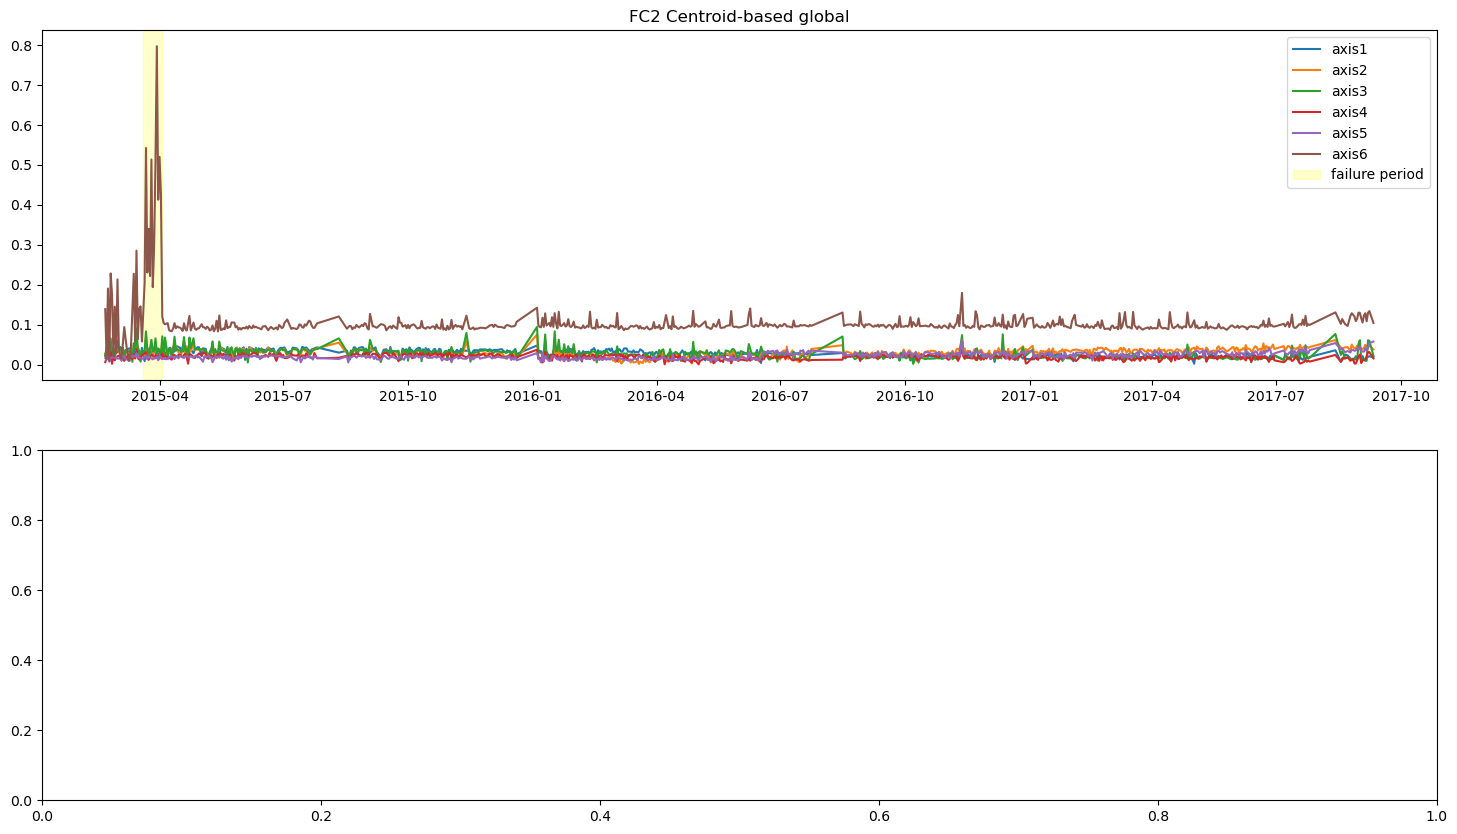

In [74]:
data1 = feature_axis1_FC2
data2 = feature_axis2_FC2
data3 = feature_axis3_FC2
data4 = feature_axis4_FC2
data5 = feature_axis5_FC2
data6 = feature_axis6_FC2
frames_FC2 = [data1, data2, data3, data4, data5, data6]


fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_FC2_Global = plot_distance_global(frames_FC2,10,'FC2 Centroid-based global',ax1,line_FC2)

# Distance_FC2_Local = plot_distance_local(frames_FC2,10, 'FC2 Centroid-based local',ax2,line_FC2)

In [75]:
interact(Moving_Average, Distance_Global=fixed(Distance_FC2_Global), Multiplier=(-2,7.5, 0.1),failure_axis=fixed('axis6'),ylim = fixed(1));

interactive(children=(FloatSlider(value=2.7, description='Multiplier', max=7.5, min=-2.0), Output()), _dom_cla…

In [76]:
interact(Linear_Regression, Distance_FCX=fixed(Distance_FC2_Global), data = fixed(feature_axis1_FC2), failure_axis=fixed('axis6'), threshold=(-0.08,0.05, 0.001),ylim = fixed(0.01));

interactive(children=(FloatSlider(value=-0.015, description='threshold', max=0.05, min=-0.08, step=0.001), Out…

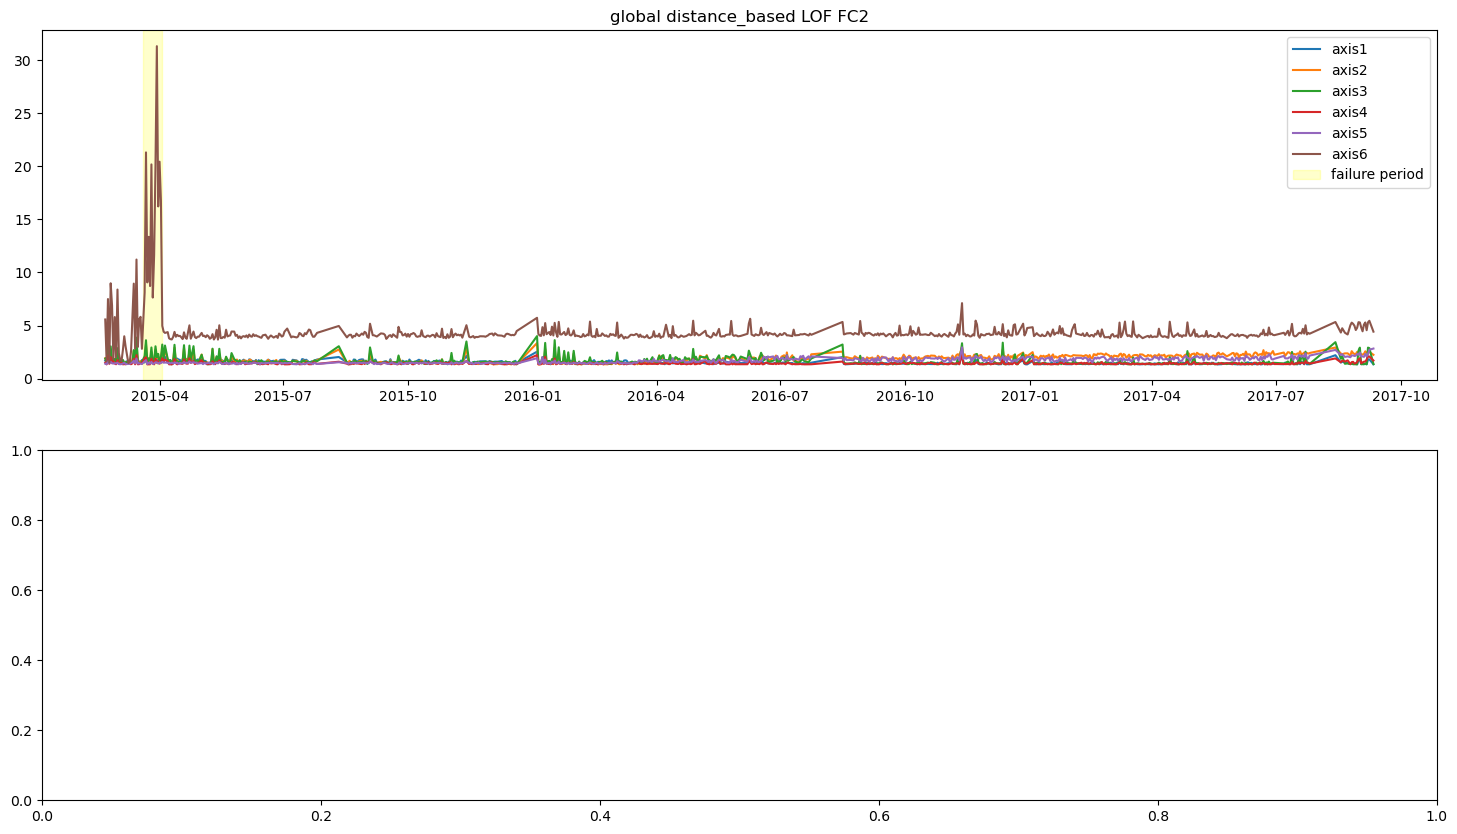

In [77]:
data1 = feature_axis1_FC2
data2 = feature_axis2_FC2
data3 = feature_axis3_FC2
data4 = feature_axis4_FC2
data5 = feature_axis5_FC2
data6 = feature_axis6_FC2
frames_FC2 = [data1, data2, data3, data4, data5, data6]
fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_based_lof_global_FC2 = Distance_based_lof_global(frames_FC2,10,'global distance_based LOF FC2',ax1,line_FC2)

# plot_distance_local(frames_FC2,10, 'FC2 Centroid-based local',ax2)

In [78]:
interact(Moving_Average, Distance_Global=fixed(Distance_based_lof_global_FC2), Multiplier=(-2,7.5, 0.01),failure_axis=fixed('axis6'),ylim = fixed(20));

interactive(children=(FloatSlider(value=2.75, description='Multiplier', max=7.5, min=-2.0, step=0.01), Output(…

In [79]:
interact(Linear_Regression, Distance_FCX=fixed(Distance_based_lof_global_FC2), data = fixed(feature_axis1_FC2), failure_axis=fixed('axis6'), threshold=(-3,2, 0.1),ylim = fixed(2));

interactive(children=(FloatSlider(value=-1.0, description='threshold', max=2.0, min=-3.0), Output()), _dom_cla…

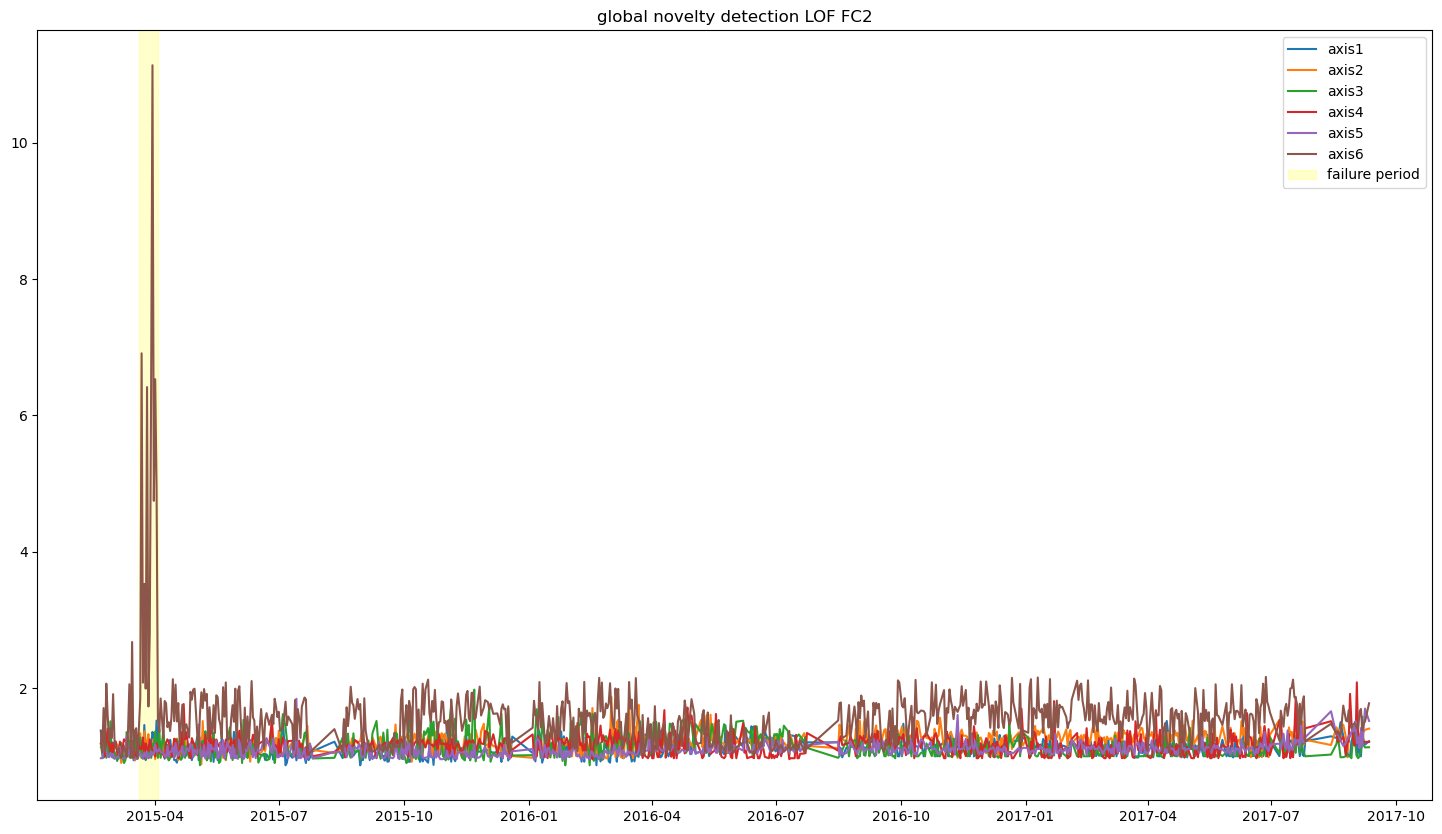

In [80]:
data1 = feature_axis1_FC2
data2 = feature_axis2_FC2
data3 = feature_axis3_FC2
data4 = feature_axis4_FC2
data5 = feature_axis5_FC2
data6 = feature_axis6_FC2
frames_FC2 = [data1, data2, data3, data4, data5, data6]
classic_LOF_global_FC2 = classic_LOF(frames_FC2,10,'global novelty detection LOF FC2',line_FC2)


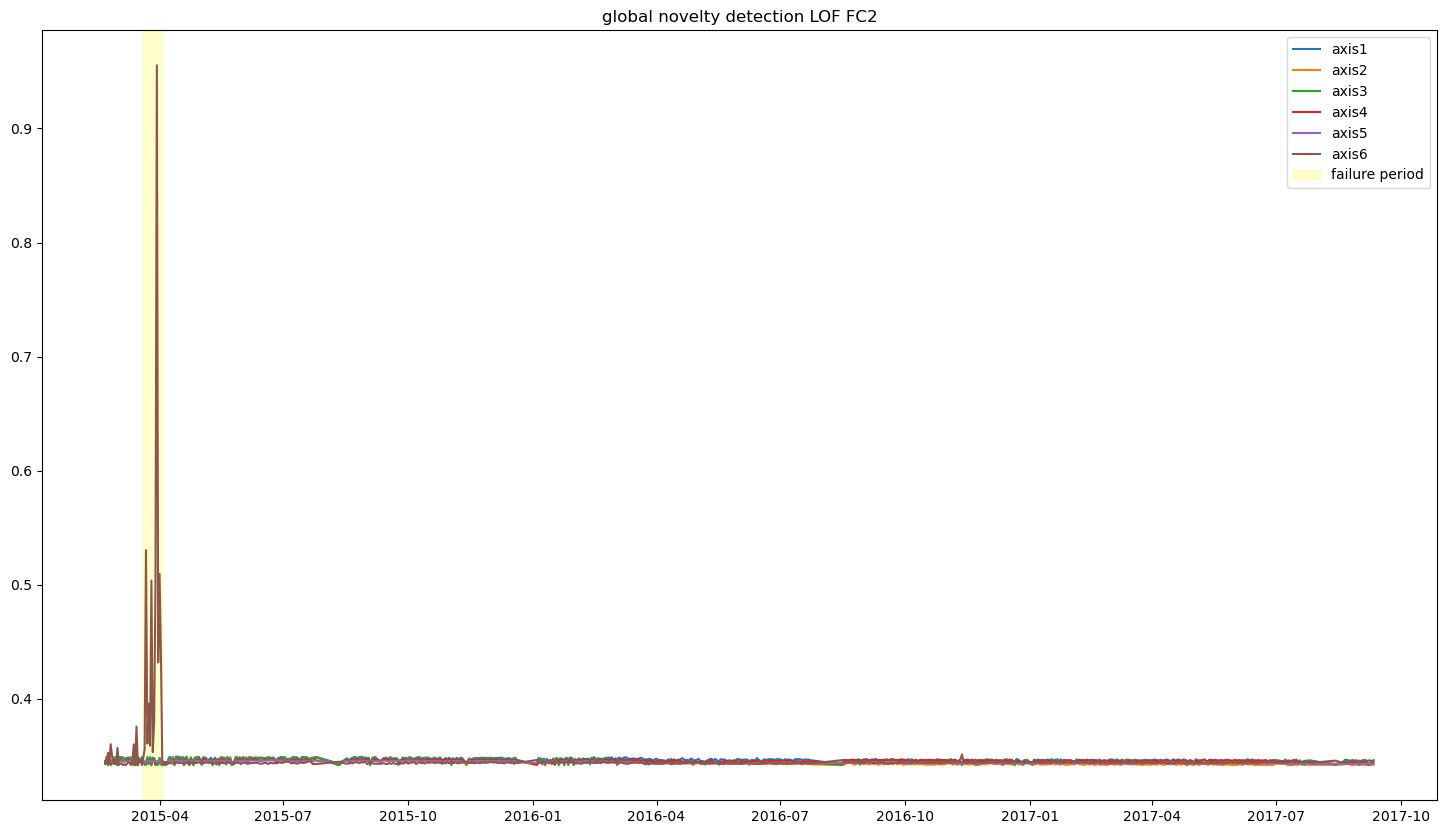

In [81]:
data1 = feature_axis1_FC2
data2 = feature_axis2_FC2
data3 = feature_axis3_FC2
data4 = feature_axis4_FC2
data5 = feature_axis5_FC2
data6 = feature_axis6_FC2
frames_FC2 = [data1, data2, data3, data4, data5, data6]
OneclassSVM_global_FC2 = OneclassSVM(frames_FC2,10,'global novelty detection LOF FC2',line_FC2)

In [82]:
interact(Moving_Average, Distance_Global=fixed(classic_LOF_global_FC2), Multiplier=(0.5, 2, 0.1),failure_axis=fixed('axis6'),ylim=fixed(10));

interactive(children=(FloatSlider(value=1.2000000000000002, description='Multiplier', max=2.0, min=0.5), Outpu…

In [83]:
interact(Moving_Average, Distance_Global=fixed(OneclassSVM_global_FC2), Multiplier=(-2,7.5, 0.1),failure_axis=fixed('axis6'),ylim=fixed(0.6));

interactive(children=(FloatSlider(value=2.7, description='Multiplier', max=7.5, min=-2.0), Output()), _dom_cla…

In [84]:
interact(Linear_Regression, Distance_FCX=fixed(classic_LOF_global_FC2), data = fixed(feature_axis1_FC2), failure_axis=fixed('axis6'), threshold=(0,0.5, 0.05),ylim = fixed(0.5));

interactive(children=(FloatSlider(value=0.25, description='threshold', max=0.5, step=0.05), Output()), _dom_cl…

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 12        
                                                                 
 dropout (Dropout)           (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense_2 (Dense)             (None, 4)                 16        
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1

2/2 [==============================] - 0s 19ms/step - loss: 1.3061 - val_loss: 1.2292
Epoch 63/100
2/2 [==============================] - 0s 19ms/step - loss: 1.2961 - val_loss: 1.2263
Epoch 64/100
2/2 [==============================] - 0s 18ms/step - loss: 1.2964 - val_loss: 1.2233
Epoch 65/100
2/2 [==============================] - 0s 20ms/step - loss: 1.2912 - val_loss: 1.2204
Epoch 66/100
2/2 [==============================] - 0s 19ms/step - loss: 1.2735 - val_loss: 1.2175
Epoch 67/100
2/2 [==============================] - 0s 19ms/step - loss: 1.2901 - val_loss: 1.2145
Epoch 68/100
2/2 [==============================] - 0s 20ms/step - loss: 1.2893 - val_loss: 1.2116
Epoch 69/100
2/2 [==============================] - 0s 19ms/step - loss: 1.2922 - val_loss: 1.2088
Epoch 70/100
2/2 [==============================] - 0s 20ms/step - loss: 1.2903 - val_loss: 1.2060
Epoch 71/100
2/2 [==============================] - 0s 19ms/step - loss: 1.2805 - val_loss: 1.2032
Epoch 72/100
2/2 [=====

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


KeyboardInterrupt: 

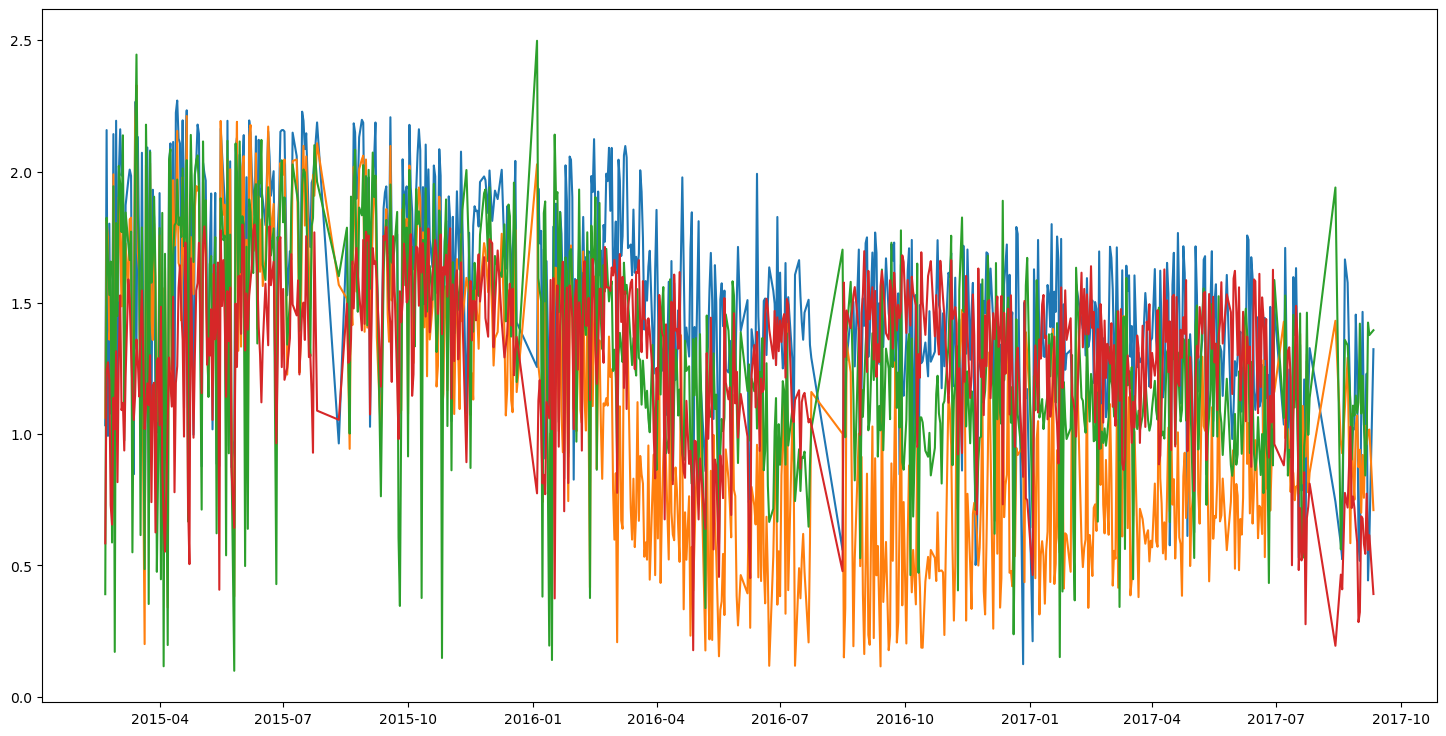

In [85]:
data1 = feature_axis1_FC2
data2 = feature_axis2_FC2
data3 = feature_axis3_FC2
data4 = feature_axis4_FC2
data5 = feature_axis5_FC2
data6 = feature_axis6_FC2
frames_FC2 = [data1, data2, data3, data4, data5, data6]
Autoencoder_FC2 = autoencoder(frames_FC2,'Autoencoder FC2',10,line_FC2)

In [ ]:
data1 = feature_axis1_FC2
len(data1)

In [ ]:
interact(Moving_Average, Distance_Global=fixed(Autoencoder_FC2), Multiplier=(0.5, 2, 0.1),failure_axis=fixed('axis6'),ylim=fixed(10));

In [ ]:
interact(Linear_Regression, Distance_FCX=fixed(Autoencoder_FC2), data = fixed(feature_axis1_FC2), failure_axis=fixed('axis6'), threshold=(0,0.5, 0.05),ylim = fixed(2));

In [ ]:

def ROC_Curve_Average(indicator,Failure_axis,failure_period,method,feature_axis1_FCX):
    T = []
    F = []
    P = []
    average_dict_FCX, Average_FCX, Mult_max, Mult_min = Moving_Average(indicator, 1, Failure_axis,40)
    plt.close()
    Multiplier_array = np.linspace(Mult_min, Mult_max, 300, endpoint = True)
    for Mult in Multiplier_array:
        average_dict_FCX, Average_FCX, A, B = Moving_Average(indicator, Mult,Failure_axis,10)
        TPR, FPR, Precision = Label(average_dict_FCX, feature_axis1_FCX, Average_FCX,Failure_axis,failure_period)
        plt.close()
        
        T.append(TPR)
        F.append(FPR)
        P.append(Precision)
    # Plotting the Graph
    
#     plt.title("Failure Case 2 Centorid-based distance indicator")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
    return T,F,P

In [ ]:
plt.figure(figsize=(6,6))


Indicators_FC2 = {'Centroid':Distance_FC2_Global, 'DB_LOF': Distance_based_lof_global_FC2, 'C_LOF':classic_LOF_global_FC2, 'O_SVM':OneclassSVM_global_FC2, 'Autoencoder':Autoencoder_FC2}
TPR_dict_FC2_MA = {}
FPR_dict_FC2_MA = {}
Precision_dict_FC2_MA = {}
for n, (fc, indicator) in enumerate(Indicators_FC2.items()):
    TPR_dict_FC2_MA[fc],FPR_dict_FC2_MA[fc],Precision_dict_FC2_MA[fc] = ROC_Curve_Average(indicator,'axis6',line_FC2,fc,feature_axis1_FC2)
    plt.plot(FPR_dict_FC2_MA[fc],TPR_dict_FC2_MA[fc],label = fc)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [ ]:
def ROC_Curve_LR(indicator,Failure_axis, failure_period,ind_label, feature_axis1_FCX):
    T = []
    F = []
    P = []
    Trend_FCX, MAX_trend, MIN_trend  = Linear_Regression(indicator,feature_axis1_FCX,Failure_axis,1,ylim= 0.05)
    plt.close()
    Multiplier_array = np.linspace(MIN_trend, MAX_trend, 300, endpoint = True)
    for mult in Multiplier_array:        
        TPR, FPR, Precision = LR_Label(Trend_FCX,feature_axis1_FCX, mult,Failure_axis,failure_period,10,10)
        T.append(TPR)
        F.append(FPR)
        P.append(Precision)
    # Plotting the Graph
    
    plt.plot(F,T,label = ind_label)
#     plt.title("Failure Case 2 Centorid-based distance indicator")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
    return T,F, P

In [ ]:
plt.figure(figsize=(6,6))
Indicators_FC2 = {'Centroid':Distance_FC2_Global, 'DB_LOF': Distance_based_lof_global_FC2, 'C_LOF':classic_LOF_global_FC2, 'O_SVM':OneclassSVM_global_FC2,'Autoencoder':Autoencoder_FC2}
TPR_dict_FC2_LR = {}
FPR_dict_FC2_LR = {}
Precision_dict_FC2_LR = {}

for n, (fc, indicator) in enumerate(Indicators_FC2.items()):
    TPR_dict_FC2_LR[fc],FPR_dict_FC2_LR[fc],Precision_dict_FC2_LR[fc] = ROC_Curve_LR(indicator,'axis6',line_FC2,fc,feature_axis1_FC2)


plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [ ]:
data1 = feature_axis1_FC10
data2 = feature_axis2_FC10
data3 = feature_axis3_FC10
data4 = feature_axis4_FC10
data5 = feature_axis5_FC10
data6 = feature_axis6_FC10
frames_FC10 = [data1, data2, data3, data4, data5, data6]


fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_FC10_Global = plot_distance_global(frames_FC10,10,'FC10 Centroid-based global',ax1,line_FC10)

Distance_FC10_Local = plot_distance_local(frames_FC10,10, 'FC10 Centroid-based local',ax2,line_FC10)

In [ ]:
interact(Moving_Average, Distance_Global=fixed(Distance_FC10_Global), data = fixed(feature_axis1_FC10), Multiplier=(0.5,2.5, 0.1),failure_axis=fixed('axis2'), ylim = fixed(0.5));

In [ ]:
interact(Linear_Regression, data = fixed(feature_axis1_FC10), Distance_FCX=fixed(Distance_FC10_Global), threshold=(0.001,0.01, 0.001),failure_axis=fixed('axis2'), ylim = fixed(0.05));

In [ ]:
data1 = feature_axis1_FC10
data2 = feature_axis2_FC10
data3 = feature_axis3_FC10
data4 = feature_axis4_FC10
data5 = feature_axis5_FC10
data6 = feature_axis6_FC10
frames_FC10 = [data1, data2, data3, data4, data5, data6]
fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_based_lof_global_FC10 = Distance_based_lof_global(frames_FC10,10,'global distance_based LOF FC10',ax1,line_FC10)
Distance_based_lof_local(frames_FC10,10,'local distance_based LOF FC10',ax2,line_FC10)

In [ ]:
interact(Moving_Average, Distance_Global=fixed(Distance_based_lof_global_FC10), data = fixed(feature_axis1_FC10), Multiplier=(0.5,2.5, 0.1),failure_axis=fixed('axis2'), ylim = fixed(50));

In [ ]:
interact(Linear_Regression, data = fixed(feature_axis1_FC10), Distance_FCX=fixed(Distance_based_lof_global_FC10), threshold=(0.1,1, 0.1),failure_axis=fixed('axis2'), ylim = fixed(1));

In [ ]:
data1 = feature_axis1_FC10
data2 = feature_axis2_FC10
data3 = feature_axis3_FC10
data4 = feature_axis4_FC10
data5 = feature_axis5_FC10
data6 = feature_axis6_FC10
frames_FC10 = [data1, data2, data3, data4, data5, data6]
classic_LOF_global_FC10 = classic_LOF(frames_FC10,10,'global novelty detection LOF FC10',line_FC10)

In [ ]:
interact(Moving_Average, Distance_Global=fixed(classic_LOF_global_FC10), data = fixed(feature_axis1_FC10), Multiplier=(0.5,2.5, 0.1),failure_axis=fixed('axis2'), ylim = fixed(50));

In [ ]:
interact(Linear_Regression, data = fixed(feature_axis1_FC10), Distance_FCX=fixed(classic_LOF_global_FC10), threshold=(0.1,1, 0.1),failure_axis=fixed('axis2'), ylim = fixed(2));

In [ ]:
data1 = feature_axis1_FC10
data2 = feature_axis2_FC10
data3 = feature_axis3_FC10
data4 = feature_axis4_FC10
data5 = feature_axis5_FC10
data6 = feature_axis6_FC10
frames_FC10 = [data1, data2, data3, data4, data5, data6]
OneclassSVM_global_FC10 = OneclassSVM(frames_FC10,10,'global novelty detection OneclassSVM FC10',line_FC10)

In [ ]:
interact(Linear_Regression, data = fixed(feature_axis1_FC10), Distance_FCX=fixed(OneclassSVM_global_FC10), threshold=(0.001,0.01, 0.001),failure_axis=fixed('axis2'), ylim = fixed(0.01));

In [ ]:
data1 = feature_axis1_FC10
data2 = feature_axis2_FC10
data3 = feature_axis3_FC10
data4 = feature_axis4_FC10
data5 = feature_axis5_FC10
data6 = feature_axis6_FC10
frames = [data1, data2, data3, data4, data5, data6]
Autoencoder_FC10 = autoencoder(frames,'Autoencoder FC10',10,line_FC10)

In [ ]:
len(data1)

In [ ]:
interact(Moving_Average, Distance_Global=fixed(Autoencoder_FC10), data = fixed(feature_axis1_FC10), Multiplier=(0.5,2.5, 0.1),failure_axis=fixed('axis2'), ylim = fixed(50));

In [ ]:
interact(Linear_Regression, data = fixed(feature_axis1_FC10), Distance_FCX=fixed(Autoencoder_FC10), threshold=(0.1,1, 0.1),failure_axis=fixed('axis2'), ylim = fixed(2));

In [ ]:
plt.figure(figsize=(6,6))


Indicators_FC10 = {'Centroid':Distance_FC10_Global, 'DB_LOF': Distance_based_lof_global_FC10, 'C_LOF':classic_LOF_global_FC10, 'O_SVM':OneclassSVM_global_FC10, 'Autoencoder':Autoencoder_FC10}
TPR_dict_FC10_MA = {}
FPR_dict_FC10_MA = {}
Precision_dict_FC10_MA = {}
for n, (fc, indicator) in enumerate(Indicators_FC10.items()):
    TPR_dict_FC10_MA[fc],FPR_dict_FC10_MA[fc],Precision_dict_FC10_MA[fc] = ROC_Curve_Average(indicator,'axis2',line_FC10,fc,feature_axis1_FC10)
    plt.plot(FPR_dict_FC10_MA[fc],TPR_dict_FC2_MA[fc],label = fc)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [ ]:


TPR_dict_FC10_LR = {}
FPR_dict_FC10_LR = {}
Precision_dict_FC10_LR = {}

for n, (fc, indicator) in enumerate(Indicators_FC10.items()):
    TPR_dict_FC10_LR[fc],FPR_dict_FC10_LR[fc],Precision_dict_FC10_LR[fc] = ROC_Curve_LR(indicator,'axis2',line_FC10,fc,feature_axis1_FC10)
    

plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [ ]:
feature_axis1_FC1 = pd.concat([RMS_Value_FC1['axis1'],Stv_FC1['axis1'],torque_areaUnderSignal_FC1['axis1']],axis=1)
feature_axis1_FC1.columns = ['RMS','Stv','areaUnderSignal']

feature_axis1_FC6 = pd.concat([RMS_Value_FC6['axis1'],Stv_FC6['axis1'],torque_areaUnderSignal_FC6['axis1']],axis=1)
feature_axis1_FC6.columns = ['RMS','Stv','areaUnderSignal']

feature_axis2_FC1 = pd.concat([RMS_Value_FC1['axis2'],Stv_FC1['axis2'],torque_areaUnderSignal_FC1['axis2']],axis=1)
feature_axis2_FC1.columns = ['RMS','Stv','areaUnderSignal']

feature_axis2_FC6 = pd.concat([RMS_Value_FC6['axis2'],Stv_FC6['axis2'],torque_areaUnderSignal_FC6['axis2']],axis=1)
feature_axis2_FC6.columns = ['RMS','Stv','areaUnderSignal']

feature_axis3_FC1 = pd.concat([RMS_Value_FC1['axis3'],Stv_FC1['axis3'],torque_areaUnderSignal_FC1['axis3']],axis=1)
feature_axis3_FC1.columns = ['RMS','Stv','areaUnderSignal']

feature_axis3_FC6 = pd.concat([RMS_Value_FC6['axis3'],Stv_FC6['axis3'],torque_areaUnderSignal_FC6['axis3']],axis=1)
feature_axis3_FC6.columns = ['RMS','Stv','areaUnderSignal']

feature_axis4_FC1 = pd.concat([RMS_Value_FC1['axis4'],Stv_FC1['axis4'],torque_areaUnderSignal_FC1['axis4']],axis=1)
feature_axis4_FC1.columns = ['RMS','Stv','areaUnderSignal']

feature_axis4_FC6 = pd.concat([RMS_Value_FC6['axis4'],Stv_FC6['axis4'],torque_areaUnderSignal_FC6['axis4']],axis=1)
feature_axis4_FC6.columns = ['RMS','Stv','areaUnderSignal']

feature_axis5_FC1 = pd.concat([RMS_Value_FC1['axis5'],Stv_FC1['axis5'],torque_areaUnderSignal_FC1['axis5']],axis=1)
feature_axis5_FC1.columns = ['RMS','Stv','areaUnderSignal']

feature_axis5_FC6 = pd.concat([RMS_Value_FC6['axis6'],Stv_FC6['axis5'],torque_areaUnderSignal_FC6['axis5']],axis=1)
feature_axis5_FC6.columns = ['RMS','Stv','areaUnderSignal']

feature_axis6_FC1 = pd.concat([RMS_Value_FC1['axis6'],Stv_FC1['axis6'],torque_areaUnderSignal_FC1['axis6']],axis=1)
feature_axis6_FC1.columns = ['RMS','Stv','areaUnderSignal']

feature_axis6_FC6 = pd.concat([RMS_Value_FC6['axis6'],Stv_FC6['axis6'],torque_areaUnderSignal_FC6['axis6']],axis=1)
feature_axis6_FC6.columns = ['RMS','Stv','areaUnderSignal']

# Centroid-based

In [ ]:
line_FC1 = [date(2016, 5, 6),date(2016, 5, 15)]
line_FC6 = [date(2016, 10, 1),date(2017, 2, 4)]


In [ ]:

data1 = feature_axis1_FC1
data2 = feature_axis2_FC1
data3 = feature_axis3_FC1
data4 = feature_axis4_FC1
data5 = feature_axis5_FC1
data6 = feature_axis6_FC1
frames_FC1 = [data1, data2, data3, data4, data5, data6]

fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_FC1_Global = plot_distance_global(frames_FC1,10,'FC1 Centroid-based global',ax1,line_FC1)

Distance_FC1_Local = plot_distance_local(frames_FC1,10, 'FC1 Centroid-based local',ax2,line_FC1)

In [ ]:
interact(Moving_Average, Distance_Global=fixed(Distance_FC1_Global), data = fixed(feature_axis1_FC1), Multiplier=(-2.5,7.5, 0.01),failure_axis=fixed('axis2'), ylim = fixed(0.2));

In [ ]:

interact(Linear_Regression, data = fixed(feature_axis1_FC1), Distance_FCX=fixed(Distance_FC1_Global), threshold=(-0.005,0.1, 0.01),failure_axis=fixed('axis2'), ylim = fixed(0.1));

# distance_based LOF

In [ ]:
data1 = feature_axis1_FC1
data2 = feature_axis2_FC1
data3 = feature_axis3_FC1
data4 = feature_axis4_FC1
data5 = feature_axis5_FC1
data6 = feature_axis6_FC1
frames_FC1 = [data1, data2, data3, data4, data5, data6]
fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_based_lof_global_FC1 = Distance_based_lof_global(frames_FC1,10,'global distance_based LOF FC1',ax1,line_FC1)
Distance_based_lof_local_FC1 = Distance_based_lof_local(frames_FC1,10,'local distance_based LOF FC1',ax2,line_FC1)
# plot_distance_local(frames_FC2,10, 'FC2 Centroid-based local',ax2)

In [ ]:
interact(Linear_Regression, data = fixed(feature_axis1_FC1), Distance_FCX=fixed(Distance_based_lof_global_FC1), threshold=(-0.005,0.5, 0.01),failure_axis=fixed('axis2'), ylim = fixed(0.1));

In [ ]:
interact(Moving_Average, Distance_Global=fixed(Distance_based_lof_global_FC1), data = fixed(feature_axis1_FC1), Multiplier=(-2.5,5, 0.01),failure_axis=fixed('axis2'), ylim = fixed(10));

In [ ]:
data1 = feature_axis1_FC1
data2 = feature_axis2_FC1
data3 = feature_axis3_FC1
data4 = feature_axis4_FC1
data5 = feature_axis5_FC1
data6 = feature_axis6_FC1
frames_FC1 = [data1, data2, data3, data4, data5, data6]
classic_LOF_global_FC1 = classic_LOF(frames_FC1,10,'global novelty detection LOF FC1',line_FC1)

In [ ]:
data1 = feature_axis1_FC1
data2 = feature_axis2_FC1
data3 = feature_axis3_FC1
data4 = feature_axis4_FC1
data5 = feature_axis5_FC1
data6 = feature_axis6_FC1
frames_FC1 = [data1, data2, data3, data4, data5, data6]
OneclassSVM_global_FC1 = OneclassSVM(frames_FC1,10,'global novelty detection OneclassSVM FC1',line_FC1)

In [ ]:
data1 = feature_axis1_FC1
data2 = feature_axis2_FC1
data3 = feature_axis3_FC1
data4 = feature_axis4_FC1
data5 = feature_axis5_FC1
data6 = feature_axis6_FC1
frames = [data1, data2, data3, data4, data5, data6]
Autoencoder_FC1 = autoencoder(frames,'Autoencoder FC1',10,line_FC1)

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))

Indicators_FC1 = {'Centroid':Distance_FC1_Global, 'DB_LOF': Distance_based_lof_global_FC1, 'C_LOF':classic_LOF_global_FC1, 'O_SVM':OneclassSVM_global_FC1, 'Autoencoder':Autoencoder_FC1}
TPR_dict_FC1_MA = {}
FPR_dict_FC1_MA = {}
Precision_dict_FC1_MA = {}
for n, (fc, indicator) in enumerate(Indicators_FC1.items()):
    TPR_dict_FC1_MA[fc],FPR_dict_FC1_MA[fc],Precision_dict_FC1_MA[fc] = ROC_Curve_Average(indicator,'axis2',line_FC1,fc,feature_axis1_FC1)
    
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()

In [ ]:

TPR_dict_FC1_LR = {}
FPR_dict_FC1_LR = {}
Precision_dict_FC1_LR = {}

for n, (fc, indicator) in enumerate(Indicators_FC1.items()):
    TPR_dict_FC1_LR[fc],FPR_dict_FC1_LR[fc],Precision_dict_FC1_LR[fc] = ROC_Curve_LR(indicator,'axis2',line_FC1,fc,feature_axis1_FC1)
    

plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [ ]:
plt.plot(FPR_dict_FC1_MA['DB_LOF'],TPR_dict_FC1_MA['DB_LOF'])


In [ ]:
data1 = feature_axis1_FC6
data2 = feature_axis2_FC6
data3 = feature_axis3_FC6
data4 = feature_axis4_FC6
data5 = feature_axis5_FC6
data6 = feature_axis6_FC6
frames_FC6 = [data1, data2, data3, data4, data5, data6]

fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_FC6_Global = plot_distance_global(frames_FC6,10,'FC6 Centroid-based global',ax1,line_FC6)

Distance_FC6_Local = plot_distance_local(frames_FC6,10, 'FC6 Centroid-based local',ax2,line_FC6)

In [ ]:
data1 = feature_axis1_FC6
data2 = feature_axis2_FC6
data3 = feature_axis3_FC6
data4 = feature_axis4_FC6
data5 = feature_axis5_FC6
data6 = feature_axis6_FC6
frames_FC6 = [data1, data2, data3, data4, data5, data6]
fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_based_lof_global_FC6 = Distance_based_lof_global(frames_FC6,10,'global distance_based LOF FC6',ax1,line_FC6)
Distance_based_lof_local(frames_FC6,10,'local distance_based LOF FC6',ax2,line_FC6)

In [ ]:
data1 = feature_axis1_FC6
data2 = feature_axis2_FC6
data3 = feature_axis3_FC6
data4 = feature_axis4_FC6
data5 = feature_axis5_FC6
data6 = feature_axis6_FC6
frames_FC6 = [data1, data2, data3, data4, data5, data6]
classic_LOF_global_FC6 = classic_LOF(frames_FC6,10,'global novelty detection LOF FC6',line_FC6)

In [ ]:
interact(Linear_Regression, data = fixed(feature_axis1_FC6), Distance_FCX=fixed(classic_LOF_global_FC6), threshold=(-0.005,0.5, 0.01),failure_axis=fixed('axis2'), ylim = fixed(0.1));

# Local Outlier Factor

In [ ]:
data1 = feature_axis1_FC6
data2 = feature_axis2_FC6
data3 = feature_axis3_FC6
data4 = feature_axis4_FC6
data5 = feature_axis5_FC6
data6 = feature_axis6_FC6
frames_FC6 = [data1, data2, data3, data4, data5, data6]
OneclassSVM_global_FC6 = OneclassSVM(frames_FC6,10,'global novelty detection OneclassSVM FC1',line_FC6)

# Autoencoder

In [ ]:
data1 = feature_axis1_FC6
data2 = feature_axis2_FC6
data3 = feature_axis3_FC6
data4 = feature_axis4_FC6
data5 = feature_axis5_FC6
data6 = feature_axis6_FC6
frames = [data1, data2, data3, data4, data5, data6]
Autoencoder_FC6 = autoencoder(frames,'Autoencoder FC6',10,line_FC6)

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))

Indicators_FC6 = {'Centroid':Distance_FC6_Global, 'DB_LOF': Distance_based_lof_global_FC6, 'C_LOF':classic_LOF_global_FC6, 'O_SVM':OneclassSVM_global_FC6, 'Autoencoder':Autoencoder_FC6}
TPR_dict_FC6_MA = {}
FPR_dict_FC6_MA = {}
Precision_dict_FC6_MA = {}
for n, (fc, indicator) in enumerate(Indicators_FC6.items()):
    TPR_dict_FC6_MA[fc],FPR_dict_FC6_MA[fc],Precision_dict_FC6_MA[fc] = ROC_Curve_Average(indicator,'axis4',line_FC6,fc,feature_axis1_FC6)
    
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()

In [ ]:
TPR_dict_FC6_LR = {}
FPR_dict_FC6_LR = {}
Precision_dict_FC6_LR = {}

for n, (fc, indicator) in enumerate(Indicators_FC6.items()):
    TPR_dict_FC6_LR[fc],FPR_dict_FC6_LR[fc],Precision_dict_FC6_LR[fc] = ROC_Curve_LR(indicator,'axis4',line_FC6,fc,feature_axis1_FC6)
    

plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [ ]:
plt.plot(TPR_dict_FC6_MA[fc],FPR_dict_FC6_MA[fc])

In [ ]:
feature_axis1_FC7 = pd.concat([RMS_Value_FC7['axis1'],Stv_FC7['axis1'],torque_areaUnderSignal_FC7['axis1']],axis=1)
feature_axis1_FC7.columns = ['RMS','Stv','areaUnderSignal']

feature_axis1_FC8 = pd.concat([RMS_Value_FC8['axis1'],Stv_FC8['axis1'],torque_areaUnderSignal_FC8['axis1']],axis=1)
feature_axis1_FC8.columns = ['RMS','Stv','areaUnderSignal']

feature_axis2_FC7 = pd.concat([RMS_Value_FC7['axis2'],Stv_FC7['axis2'],torque_areaUnderSignal_FC7['axis2']],axis=1)
feature_axis2_FC7.columns = ['RMS','Stv','areaUnderSignal']

feature_axis2_FC8 = pd.concat([RMS_Value_FC8['axis2'],Stv_FC8['axis2'],torque_areaUnderSignal_FC8['axis2']],axis=1)
feature_axis2_FC8.columns = ['RMS','Stv','areaUnderSignal']

feature_axis3_FC7 = pd.concat([RMS_Value_FC7['axis3'],Stv_FC7['axis3'],torque_areaUnderSignal_FC7['axis3']],axis=1)
feature_axis3_FC7.columns = ['RMS','Stv','areaUnderSignal']

feature_axis3_FC8 = pd.concat([RMS_Value_FC8['axis3'],Stv_FC8['axis3'],torque_areaUnderSignal_FC8['axis3']],axis=1)
feature_axis3_FC8.columns = ['RMS','Stv','areaUnderSignal']

feature_axis4_FC7 = pd.concat([RMS_Value_FC7['axis4'],Stv_FC7['axis4'],torque_areaUnderSignal_FC7['axis4']],axis=1)
feature_axis4_FC7.columns = ['RMS','Stv','areaUnderSignal']

feature_axis4_FC8 = pd.concat([RMS_Value_FC8['axis4'],Stv_FC8['axis4'],torque_areaUnderSignal_FC8['axis4']],axis=1)
feature_axis4_FC8.columns = ['RMS','Stv','areaUnderSignal']

feature_axis5_FC7 = pd.concat([RMS_Value_FC7['axis5'],Stv_FC7['axis5'],torque_areaUnderSignal_FC7['axis5']],axis=1)
feature_axis5_FC7.columns = ['RMS','Stv','areaUnderSignal']

feature_axis5_FC8 = pd.concat([RMS_Value_FC8['axis5'],Stv_FC8['axis5'],torque_areaUnderSignal_FC8['axis5']],axis=1)
feature_axis5_FC8.columns = ['RMS','Stv','areaUnderSignal']

feature_axis6_FC7 = pd.concat([RMS_Value_FC7['axis6'],Stv_FC7['axis6'],torque_areaUnderSignal_FC7['axis6']],axis=1)
feature_axis6_FC7.columns = ['RMS','Stv','areaUnderSignal']

feature_axis6_FC8 = pd.concat([RMS_Value_FC8['axis6'],Stv_FC8['axis6'],torque_areaUnderSignal_FC8['axis6']],axis=1)
feature_axis6_FC8.columns = ['RMS','Stv','areaUnderSignal']

In [ ]:
line_FC7 = [date(2017, 4, 20),date(2017, 4, 26)]
line_FC8 = [date(2016, 10, 19),date(2017, 1, 23)]


In [ ]:
data1 = feature_axis1_FC7
data2 = feature_axis2_FC7
data3 = feature_axis3_FC7
data4 = feature_axis4_FC7
data5 = feature_axis5_FC7
data6 = feature_axis6_FC7
frames_FC7 = [data1, data2, data3, data4, data5, data6]

fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_FC7_Global = plot_distance_global(frames_FC7,10,'FC7 Centroid-based global',ax1,line_FC7)

Distance_FC7_local = plot_distance_local(frames_FC7,10, 'FC7 Centroid-based local',ax2,line_FC7)

In [ ]:
data1 = feature_axis1_FC7
data2 = feature_axis2_FC7
data3 = feature_axis3_FC7
data4 = feature_axis4_FC7
data5 = feature_axis5_FC7
data6 = feature_axis6_FC7
frames_FC7 = [data1, data2, data3, data4, data5, data6]
fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_based_lof_global_FC7 = Distance_based_lof_global(frames_FC7,10,'global distance_based LOF FC7',ax1,line_FC7)
Distance_based_lof_local(frames_FC7,10,'local distance_based LOF FC7',ax2,line_FC7)

In [ ]:
data1 = feature_axis1_FC7
data2 = feature_axis2_FC7
data3 = feature_axis3_FC7
data4 = feature_axis4_FC7
data5 = feature_axis5_FC7
data6 = feature_axis6_FC7
frames_FC7 = [data1, data2, data3, data4, data5, data6]
classic_LOF_global_FC7 = classic_LOF(frames_FC7,10,'global novelty detection LOF FC7',line_FC7)

In [ ]:
interact(Moving_Average, Distance_Global=fixed(classic_LOF_global_FC7), data = fixed(feature_axis1_FC7), Multiplier=(0.5,2.5, 0.1),failure_axis=fixed('axis2'), ylim = fixed(10));

In [ ]:
data1 = feature_axis1_FC7
data2 = feature_axis2_FC7
data3 = feature_axis3_FC7
data4 = feature_axis4_FC7
data5 = feature_axis5_FC7
data6 = feature_axis6_FC7
frames_FC7 = [data1, data2, data3, data4, data5, data6]
OneclassSVM_global_FC7 = OneclassSVM(frames_FC7,10,'global novelty detection OneclassSVM FC7',line_FC7)

In [ ]:
data1 = feature_axis1_FC7
data2 = feature_axis2_FC7
data3 = feature_axis3_FC7
data4 = feature_axis4_FC7
data5 = feature_axis5_FC7
data6 = feature_axis6_FC7
frames = [data1, data2, data3, data4, data5, data6]
frames = [data1, data2, data3, data4, data5, data6]
Autoencoder_FC7= autoencoder(frames,'Autoencoder FC7',10,line_FC7)

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))

Indicators_FC7 = {'Centroid':Distance_FC7_Global, 'DB_LOF': Distance_based_lof_global_FC7, 'C_LOF':classic_LOF_global_FC7, 'O_SVM':OneclassSVM_global_FC7,'Autoencoder':Autoencoder_FC7}
TPR_dict_FC7_MA = {}
FPR_dict_FC7_MA = {}
Precision_dict_FC7_MA = {}
for n, (fc, indicator) in enumerate(Indicators_FC7.items()):
    TPR_dict_FC7_MA[fc],FPR_dict_FC7_MA[fc],Precision_dict_FC7_MA[fc] = ROC_Curve_Average(indicator,'axis2',line_FC7,fc,feature_axis1_FC7)
    
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()

In [ ]:
TPR_dict_FC7_LR = {}
FPR_dict_FC7_LR = {}
Precision_dict_FC7_LR = {}

for n, (fc, indicator) in enumerate(Indicators_FC7.items()):
    TPR_dict_FC7_LR[fc],FPR_dict_FC7_LR[fc],Precision_dict_FC7_LR[fc] = ROC_Curve_LR(indicator,'axis2',line_FC7,fc,feature_axis1_FC7)
    

plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [ ]:
data1 = feature_axis1_FC8
data2 = feature_axis2_FC8
data3 = feature_axis3_FC8
data4 = feature_axis4_FC8
data5 = feature_axis5_FC8
data6 = feature_axis6_FC8
frames_FC8 = [data1, data2, data3, data4, data5, data6]

fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_FC8_Global= plot_distance_global(frames_FC8,10,'FC8 Centroid-based global',ax1, line_FC8)

Distance_FC8_local = plot_distance_local(frames_FC8,10, 'FC8 Centroid-based local',ax2,line_FC8)

In [ ]:
data1 = feature_axis1_FC8
data2 = feature_axis2_FC8
data3 = feature_axis3_FC8
data4 = feature_axis4_FC8
data5 = feature_axis5_FC8
data6 = feature_axis6_FC8
frames_FC8 = [data1, data2, data3, data4, data5, data6]
fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_based_lof_global_FC8 = Distance_based_lof_global(frames_FC8,10,'global distance_based LOF FC8',ax1,line_FC8)
Distance_based_lof_local(frames_FC8,10,'local distance_based LOF FC8',ax2,line_FC8)

In [ ]:
data1 = feature_axis1_FC8
data2 = feature_axis2_FC8
data3 = feature_axis3_FC8
data4 = feature_axis4_FC8
data5 = feature_axis5_FC8
data6 = feature_axis6_FC8
frames_FC8 = [data1, data2, data3, data4, data5, data6]
classic_LOF_global_FC8 = classic_LOF(frames_FC8,10,'global novelty detection LOF FC8',line_FC8)

In [ ]:
data1 = feature_axis1_FC8
data2 = feature_axis2_FC8
data3 = feature_axis3_FC8
data4 = feature_axis4_FC8
data5 = feature_axis5_FC8
data6 = feature_axis6_FC8
frames_FC8 = [data1, data2, data3, data4, data5, data6]
OneclassSVM_global_FC8 = OneclassSVM(frames_FC8,10,'global novelty detection OneclassSVM FC8',line_FC8)

# Autoencoder

In [ ]:
data1 = feature_axis1_FC8
data2 = feature_axis2_FC8
data3 = feature_axis3_FC8
data4 = feature_axis4_FC8
data5 = feature_axis5_FC8
data6 = feature_axis6_FC8
frames = [data1, data2, data3, data4, data5, data6]
Autoencoder_FC8 = autoencoder(frames,'Autoencoder FC8',10,line_FC8)

In [ ]:

fig, ax = plt.subplots(1, figsize=(10,10))

Indicators_FC8 = {'Centroid':Distance_FC8_Global, 'DB_LOF': Distance_based_lof_global_FC8, 'C_LOF':classic_LOF_global_FC8, 'O_SVM':OneclassSVM_global_FC8,'Autoencoder':Autoencoder_FC8}
TPR_dict_FC8_MA = {}
FPR_dict_FC8_MA = {}
Precision_dict_FC8_MA = {}
for n, (fc, indicator) in enumerate(Indicators_FC8.items()):
    TPR_dict_FC8_MA[fc],FPR_dict_FC8_MA[fc],Precision_dict_FC8_MA[fc] = ROC_Curve_Average(indicator,'axis3',line_FC8,fc,feature_axis1_FC8)
    
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()

In [ ]:
ind = ['Centroid','DB_LOF', 'C_LOF', 'O_SVM','Autoencoder']
for i in ind:
    plt.plot(FPR_dict_FC8_MA[i],TPR_dict_FC8_MA[i],label = i)

In [ ]:
TPR_dict_FC8_LR = {}
FPR_dict_FC8_LR = {}
Precision_dict_FC8_LR = {}

for n, (fc, indicator) in enumerate(Indicators_FC8.items()):
    TPR_dict_FC8_LR[fc],FPR_dict_FC8_LR[fc],Precision_dict_FC8_LR[fc] = ROC_Curve_LR(indicator,'axis3',line_FC8,fc,feature_axis1_FC8)
    

plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [ ]:
Aver_tpr_MA = {}
Aver_fpr_MA = {}
Aver_Precision_MA = {}
for key in TPR_dict_FC8_LR:
    fpr_MA = np.array([FPR_dict_FC2_MA[key], FPR_dict_FC10_MA[key],  FPR_dict_FC6_MA[key]])
    tpr_MA = np.array([TPR_dict_FC2_MA[key], TPR_dict_FC10_MA[key],  TPR_dict_FC6_MA[key]])
    Precision_MA = np.array([Precision_dict_FC2_MA[key], Precision_dict_FC10_MA[key], Precision_dict_FC6_MA[key]])
    Aver_tpr_MA[key] = np.average(tpr_MA, axis=0)
    Aver_fpr_MA[key] = np.average(fpr_MA, axis=0)
    Aver_Precision_MA[key] = np.average(Precision_MA, axis=0)

In [ ]:
def F1_score(precision, recall):
    F1_score = 2*np.multiply(precision,recall)/(np.add(precision , recall))
    return F1_score

In [ ]:
F1_score_MA_FC2 = {}
F1_score_MA_FC10 = {}
# F1_score_MA_FC1 = {}
F1_score_MA_FC6 = {}
F1_score_MA_FC7 = {}
F1_score_MA_FC8 = {}

for k in FPR_dict_FC10_MA:

    F1_score_MA_FC2[k] = max(F1_score(Precision_dict_FC2_MA[k],TPR_dict_FC2_MA[k]))
    F1_score_MA_FC10[k] = max(F1_score(Precision_dict_FC10_MA[k],TPR_dict_FC10_MA[k]))
#     F1_score_MA_FC1[k] = max(F1_score(Precision_dict_FC1_MA[k],TPR_dict_FC1_MA[k]))
    F1_score_MA_FC6[k] = max(F1_score(Precision_dict_FC6_MA[k],TPR_dict_FC6_MA[k]))
    F1_score_MA_FC7[k] = max(F1_score(Precision_dict_FC7_MA[k],TPR_dict_FC7_MA[k]))
    F1_score_MA_FC8[k] = max(F1_score(Precision_dict_FC8_MA[k],TPR_dict_FC8_MA[k]))

In [ ]:
AUC_MA = {}
for key in Aver_fpr_MA:
    plt.plot(Aver_fpr_MA[key],Aver_tpr_MA[key], label = key, linewidth=1)
    x = Aver_fpr_MA[key]
    y = Aver_tpr_MA[key]
    z = Aver_Precision_MA[key]
    sorted_x, sorted_y = zip(*sorted(zip(x, y)))
    AUC_MA[key] = np.trapz(sorted_y, sorted_x)
    print(f"AUC of {key} in moving average is {AUC_MA[key]}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.legend() 

In [ ]:
F1_score_MA = {}
for k in FPR_dict_FC10_MA:
    F1_score_MA[k] = max(F1_score(Aver_Precision_MA[k],Aver_tpr_MA[k]))
    print(f"The avarage F1 score of {k} in moving average is {F1_score_MA[k]}")

In [ ]:
Aver_tpr_LR = {}
Aver_fpr_LR = {}
Aver_Precision_LR = {}
for key in TPR_dict_FC8_LR:
    fpr_LR = np.array([FPR_dict_FC2_LR[key], FPR_dict_FC10_LR[key], FPR_dict_FC6_LR[key]])
    tpr_LR = np.array([TPR_dict_FC2_LR[key], TPR_dict_FC10_LR[key], TPR_dict_FC6_LR[key]])
    Precision_LR = np.array([Precision_dict_FC2_LR[key], Precision_dict_FC10_LR[key], Precision_dict_FC6_LR[key]])
    Aver_tpr_LR[key] = np.average(tpr_LR, axis=0)
    Aver_fpr_LR[key] = np.average(fpr_LR, axis=0)
    Aver_Precision_LR[key] = np.average(Precision_LR, axis=0)



In [ ]:
AUC_LR = {}
for key in Aver_tpr_LR:
    plt.plot(Aver_fpr_LR[key],Aver_tpr_LR[key], label = key)
    x = Aver_fpr_LR[key]
    y = Aver_tpr_LR[key]
    sorted_x, sorted_y = zip(*sorted(zip(x, y)))
    AUC_LR[key] = np.trapz(sorted_y, sorted_x)
    print(f"AUC of {key} in linear regresssion is {AUC_LR[key]}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend() 

In [ ]:
F1_score_LR = {}
for k in FPR_dict_FC10_LR:
    F1_score_LR[k] = max(F1_score(Aver_Precision_LR[k],Aver_tpr_LR[k]))
    print(f"The avarage F1 score of {k} in linear regresssion is {F1_score_LR[k]}")

In [ ]:
AUC_MA

In [ ]:
feature_axis1_FC11 = pd.concat([RMS_Value_FC11['axis1'],Stv_FC11['axis1'],torque_areaUnderSignal_FC11['axis1']],axis=1)
feature_axis1_FC11.columns = ['RMS','Stv','areaUnderSignal']

feature_axis1_FC12 = pd.concat([RMS_Value_FC12['axis1'],Stv_FC12['axis1'],torque_areaUnderSignal_FC12['axis1']],axis=1)
feature_axis1_FC12.columns = ['RMS','Stv','areaUnderSignal']

feature_axis2_FC11 = pd.concat([RMS_Value_FC11['axis2'],Stv_FC11['axis2'],torque_areaUnderSignal_FC11['axis2']],axis=1)
feature_axis2_FC11.columns = ['RMS','Stv','areaUnderSignal']

feature_axis2_FC12 = pd.concat([RMS_Value_FC12['axis2'],Stv_FC12['axis2'],torque_areaUnderSignal_FC12['axis2']],axis=1)
feature_axis2_FC12.columns = ['RMS','Stv','areaUnderSignal']

feature_axis3_FC11 = pd.concat([RMS_Value_FC11['axis3'],Stv_FC11['axis3'],torque_areaUnderSignal_FC11['axis3']],axis=1)
feature_axis3_FC11.columns = ['RMS','Stv','areaUnderSignal']

feature_axis3_FC12 = pd.concat([RMS_Value_FC12['axis3'],Stv_FC12['axis3'],torque_areaUnderSignal_FC12['axis3']],axis=1)
feature_axis3_FC12.columns = ['RMS','Stv','areaUnderSignal']

feature_axis4_FC11 = pd.concat([RMS_Value_FC11['axis4'],Stv_FC11['axis4'],torque_areaUnderSignal_FC11['axis4']],axis=1)
feature_axis4_FC11.columns = ['RMS','Stv','areaUnderSignal']

feature_axis4_FC12 = pd.concat([RMS_Value_FC12['axis4'],Stv_FC12['axis4'],torque_areaUnderSignal_FC12['axis4']],axis=1)
feature_axis4_FC12.columns = ['RMS','Stv','areaUnderSignal']

feature_axis5_FC11 = pd.concat([RMS_Value_FC11['axis5'],Stv_FC11['axis5'],torque_areaUnderSignal_FC11['axis5']],axis=1)
feature_axis5_FC11.columns = ['RMS','Stv','areaUnderSignal']

feature_axis5_FC12 = pd.concat([RMS_Value_FC12['axis6'],Stv_FC12['axis5'],torque_areaUnderSignal_FC12['axis5']],axis=1)
feature_axis5_FC12.columns = ['RMS','Stv','areaUnderSignal']

feature_axis6_FC11 = pd.concat([RMS_Value_FC11['axis6'],Stv_FC11['axis6'],torque_areaUnderSignal_FC11['axis6']],axis=1)
feature_axis6_FC11.columns = ['RMS','Stv','areaUnderSignal']

feature_axis6_FC12 = pd.concat([RMS_Value_FC12['axis6'],Stv_FC12['axis6'],torque_areaUnderSignal_FC12['axis6']],axis=1)
feature_axis6_FC12.columns = ['RMS','Stv','areaUnderSignal']


In [ ]:
line_FC11 = [[date(2017, 11, 26),date(2017, 12, 3)],
             [date(2017, 12, 3),date(2017, 12, 6)]]

line_FC12 = [[date(2017, 12, 17),date(2017, 12, 22)],
            [date(2017,4,22), date(2017,4,27)]]

In [ ]:
data1 = feature_axis1_FC11
data2 = feature_axis2_FC11
data3 = feature_axis3_FC11
data4 = feature_axis4_FC11
data5 = feature_axis5_FC11
data6 = feature_axis6_FC11
frames_FC11 = [data1, data2, data3, data4, data5, data6]

fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_FC11_Global = plot_distance_global(frames_FC11,10,'FC11 Centroid-based global',ax1,line_FC11)

Distance_FC11_local = plot_distance_local(frames_FC11,10, 'FC11 Centroid-based local',ax2,line_FC11)

In [ ]:
data1 = feature_axis1_FC12
data2 = feature_axis2_FC12
data3 = feature_axis3_FC12
data4 = feature_axis4_FC12
data5 = feature_axis5_FC12
data6 = feature_axis6_FC12
frames_FC12 = [data1, data2, data3, data4, data5, data6]

fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_FC12_Global = plot_distance_global(frames_FC12,10,'FC12 Centroid-based global',ax1, line_FC12)

Distance_FC12_local = plot_distance_local(frames_FC12,10, 'FC12 Centroid-based local',ax2, line_FC12)

In [ ]:
data1 = feature_axis1_FC11
data2 = feature_axis2_FC11
data3 = feature_axis3_FC11
data4 = feature_axis4_FC11
data5 = feature_axis5_FC11
data6 = feature_axis6_FC11
frames_FC11 = [data1, data2, data3, data4, data5, data6]
fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_based_lof_global_F11 = Distance_based_lof_global(frames_FC11,10,'global distance_based LOF FC11',ax1,line_FC11)

In [ ]:
data1 = feature_axis1_FC8
data2 = feature_axis2_FC8
data3 = feature_axis3_FC8
data4 = feature_axis4_FC8
data5 = feature_axis5_FC8
data6 = feature_axis6_FC8
frames_FC8 = [data1, data2, data3, data4, data5, data6]
classic_LOF_global_FC8 = classic_LOF(frames_FC8,10,'global novelty detection LOF FC8',line_FC8)

In [ ]:
data1 = feature_axis1_FC12
data2 = feature_axis2_FC12
data3 = feature_axis3_FC12
data4 = feature_axis4_FC12
data5 = feature_axis5_FC12
data6 = feature_axis6_FC12
frames_FC12 = [data1, data2, data3, data4, data5, data6]
fig, (ax1, ax2) = plt.subplots(2,figsize=(18,10))
Distance_based_lof_global(frames_FC12,10,'global distance_based LOF FC12',ax1,line_FC12)
Distance_based_lof_local(frames_FC12,10,'local distance_based LOF FC12',ax2,line_FC12)